
# Project 3 Improved: Substitute Products in Case of Stock-Outs

- Run Apriori **per subcategory**.
- Select subcategories by **revenue** or **purchase frequency**.
- Focus on **lift < 1** rules → candidate substitutes.
- Visualize brand switching, price changes.
- Provide recommendations.

---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from collections import Counter
import seaborn as sns
import re
import networkx as nx

## 1. Data Import and Preprocessing
In this section we loaded the data, clean it, and prepare it for analysis.
* The data from sales, product and account info tables were merged to create a single fact table.
* We added two columns: 
    - the unit price for each product by dividing the net sales amount by the quantity.
    - the unit size for each product
* We check for missing values and ensure the data is clean before analysis.

In [15]:
# Load Data
df1 = pd.read_csv('/Users/pedrosilva/Downloads/Sales_info.csv', sep=None, engine='python')
df2 = pd.read_csv('/Users/pedrosilva/Downloads/Product_info.csv', sep=None, engine='python')
df3 = pd.read_csv('/Users/pedrosilva/Downloads/Account_info.csv', sep=None, engine='python')
df_temp = pd.merge(df1,df2,on ='encrypt_sku',how = 'left') 
df_final = pd.merge (df_temp,df3,on ='account_no',how = 'left' )
df_final = df_final[df_final['qty'] > 0]
df_final['unit_price'] = df_final['net_sls_amt'] / df_final['qty']
#print(df_final.head())

In [17]:
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
#print(df_final)

In [19]:
df_final.isnull().sum()

account_no                    0
transaction_id                0
time_key                      0
pos_tp_cd                     0
encrypt_sku                   0
qty                           0
net_sls_amt                   0
gross_sls_amt                 0
direct_dscnt_amt              0
trans_direct_dscnt_amt        0
prod_dscnt_issued_amt         0
product_dsc                   0
sub_cat_cd                    0
subcat_dsc_ext                0
catg_cd                       0
cat_dsc_ext                   0
department_cd                 0
department_dsc_ext            0
brand_cd                      0
brand_dsc                     0
capacity_unit                 0
conversion_factor             0
family_members                0
segment_gender_f              0
segment_gender_m              0
age_group                  2979
district                   8452
region                    17488
segment_cd_lifestyle          0
segment_dsc_lifestyle         0
segment_cd_lifestage          0
segment_

In [21]:
# Considering these are the columns with missing values I will use the Mode because are categories / string, not numeric.

# Copy your original DataFrame
df_clean = df_final.copy()

# Fill missing values using mode for categorical columns
df_clean['age_group'] = df_clean['age_group'].fillna(df_clean['age_group'].mode()[0])
df_clean['district'] = df_clean['district'].fillna(df_clean['district'].mode()[0])
df_clean['region'] = df_clean['region'].fillna(df_clean['region'].mode()[0])

In [23]:
# Check for missing values
missing_counts = df_clean.isna().sum()
# Filter to show only columns with missing values
missing_counts = missing_counts[missing_counts > 0]
# Print result
#print(missing_counts)

In [7]:
#print(df_clean["product_dsc"])

In [25]:
df_clean['product_dsc'].nunique()

2906

In [27]:
products_frequency = df_clean['product_dsc'].value_counts()
#products_frequency

In [31]:
top20 = products_frequency.head(20)
#top20

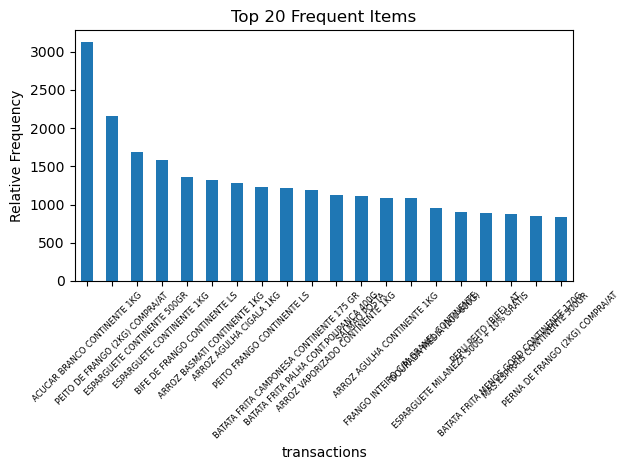

In [33]:
top20.plot (kind = "bar")
plt.title('Top 20 Frequent Items')
plt.ylabel('Relative Frequency')
plt.xlabel('transactions')
plt.xticks(rotation=45, fontsize = 6)
plt.tight_layout() 
plt.show()

In [35]:
df_clean['transaction_id_shortcut'] = df_clean['transaction_id'].astype(str).str[:8] + '...'

In [37]:
# Função para extrair o tamanho 
def extract_unit_size(text):
    match = re.search(r'(\d+(?:[\.,]\d+)?)\s?(ml|l|cl|d|g|kg|un|uni|unidad|units)', text.lower())
    if match:
        qty = float(match.group(1).replace(',', '.'))
        unit = match.group(2)
        
        # Normaliza unidade para comparação
        if unit == 'kg':
            qty *= 1000  # kg → g
        elif unit == 'l':
            qty *= 1000  # l → ml
        elif unit in ['un', 'uni', 'unidad', 'units']:
            qty = qty  # unidades → mantêm
        
        return qty
    else:
        return np.nan  # Se não encontrar, retorna NaN

# Função para criar um label legível (para o heatmap)
def extract_unit_size_label(text):
    match = re.search(r'(\d+(?:[\.,]\d+)?)\s?(ml|l|cl|d|g|kg|un|uni|unidad|units)', text.lower())
    if match:
        qty = float(match.group(1).replace(',', '.'))
        unit = match.group(2)
        
        # Normaliza para o label
        if unit == 'kg':
            qty *= 1000
            unit = 'g'
        elif unit == 'l':
            qty *= 1000
            unit = 'ml'
        elif unit in ['un', 'uni', 'unidad', 'units']:
            unit = 'un'
        
        return f'{int(qty)} {unit}'
    else:
        return 'Unknown Size'

In [39]:
df_clean['unit_size_ml_or_g'] = df_clean['product_dsc'].apply(extract_unit_size)
df_clean['unit_size_label'] = df_clean['product_dsc'].apply(extract_unit_size_label)

## 2. Exploratory Data Analysis (EDA)
This preliminar analysis is important because it helps us select the subcategories where it makes sense to search for substitutes.
* Revenue importance → focus on subcategories where stock-outs would impact sales. 
* Brand diversity → sSubcategories with many brands have more potential for substitution between brands.
* Assortment richness (product_count) → focus on categories with enough products to enable substitution.
* Volume purchased → indicates if the category has high customer engagement. If many products are actually being bought, substitution is more likely to occur naturally.                                                                                                                                           

In [41]:
# Métricas
brand_count_per_subcat = df_clean.groupby('subcat_dsc_ext')['brand_dsc'].nunique().reset_index(name='Total Brands')
product_count_per_subcat = df_clean.groupby('subcat_dsc_ext')['product_dsc'].nunique().reset_index(name='Total Products')
unit_purchased_per_subcat = df_clean.groupby('subcat_dsc_ext')['qty'].sum().reset_index(name='Total Units Purchased')
revenue_per_subcat = df_clean.groupby('subcat_dsc_ext')['net_sls_amt'].sum().reset_index(name='Total Revenue')

# Merge final
final_count = pd.merge(brand_count_per_subcat, product_count_per_subcat, on='subcat_dsc_ext')
final_count = pd.merge(final_count, unit_purchased_per_subcat, on='subcat_dsc_ext')
final_count = pd.merge(final_count, revenue_per_subcat, on='subcat_dsc_ext')

# Ordenar
final_count_sorted = final_count.sort_values(by= 'Total Revenue', ascending=False)

# Mostrar top 10
print("Top 10 Frequent Items:")
top10 = final_count_sorted.head(10)
display(top10)

Top 10 Frequent Items:


subcat_dsc_ext  Total Brands  Total Products  Total Units Purchased  \
19             bovino at             9              76               5490.551   
16        aves/coelho ls            17             133              12186.250   
23  cerv.branca nacional             8              74              17260.000   
14        aves/coelho at            11              23              10312.040   
29       det.maq.liquido            20             185               4171.000   
12                 arroz            18              84              17183.000   
39                massas            27             318              24929.000   
21             bovino ls            12              80               1881.227   
17          batata frita            13              74              19165.000   
11           aquacultura             1              20               3057.200   

    Total Revenue  
19     56770.3175  
16     55967.7161  
23     41725.6791  
14     40091.5463  
29     30735.9314  
12     26543.9853  
39     25110.4587  
21     24172.2815  
17     24107.5143  
11     21916.6340

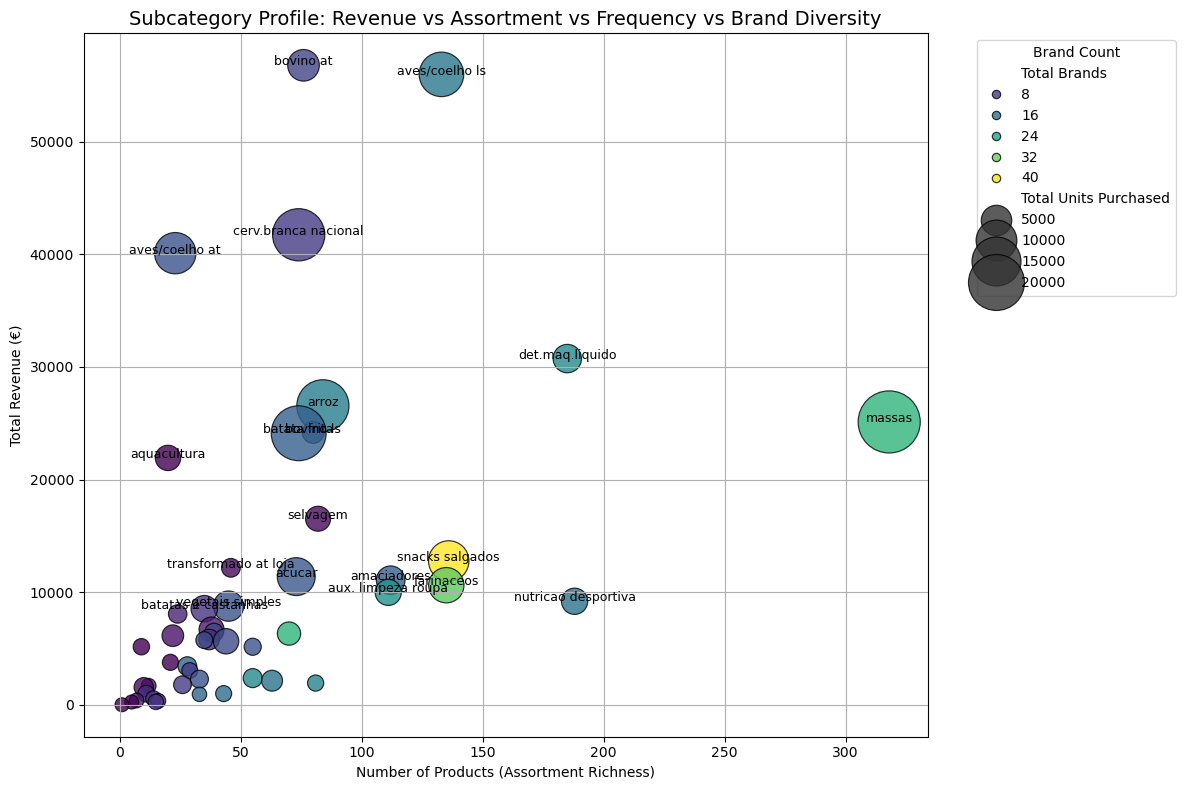

In [45]:
# Bubble chart → Subcategory profile

plt.figure(figsize=(12,8))

# Create scatterplot
sns.scatterplot(
    data=final_count_sorted,
    x='Total Products',
    y='Total Revenue',
    size='Total Units Purchased',
    hue='Total Brands',
    palette='viridis',
    sizes=(100, 2000),  # Adjust bubble size range
    alpha=0.8,
    edgecolor='black'
)

# Add labels for top categories
for i, row in final_count_sorted.head(20).iterrows():
    plt.text(
        row['Total Products'], 
        row['Total Revenue'], 
        row['subcat_dsc_ext'], 
        fontsize=9, 
        ha='center'
    )

plt.title('Subcategory Profile: Revenue vs Assortment vs Frequency vs Brand Diversity', fontsize=14)
plt.xlabel('Number of Products (Assortment Richness)')
plt.ylabel('Total Revenue (€)')
plt.legend(title='Brand Count', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
# So, we will select for further analysis the following subcategories (based on revenue, assortment, frequency, and brand diversity):

selected_subcategory = 'cerv.branca nacional'

In [49]:
# To check if unit sizes are ok.
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc', 'unit_size_ml_or_g', 'unit_size_label']].sample(10))


Sample for subcategory: cerv.branca nacional


product_dsc  unit_size_ml_or_g  \
107737          CERV. C/ALC. LATA GUTBIER 6*33CL               33.0   
137384          CERV. C/ALC. LATA GUTBIER 6*33CL               33.0   
35950          CERV. C/ALC. LATA SUPER BOCK 33CL               33.0   
17245                 CERV. C/ALC. T/R CORAL 1LT             1000.0   
90968           CERV. C/ALC. T/P SUPER BOCK 33CL               33.0   
82896   CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL               20.0   
130199       CERV C/ALC SUPER BOCK SKY TP 6X20CL               20.0   
128183    CERV.C/ALC.T/P SUPER BOCK MINI 15*20CL               20.0   
146007             CERV. C/ALC. LATA SAGRES 33CL               33.0   
1174             CERVEJA C/ALC. T/R CORAL 6*20CL               20.0   

       unit_size_label  
107737           33 cl  
137384           33 cl  
35950            33 cl  
17245          1000 ml  
90968            33 cl  
82896            20 cl  
130199           20 cl  
128183           20 cl  
146007           33 cl  
1174             20 cl

In [75]:
# -----------------------------
# Analysis for Subcategory: cerv.branca nacional
# -----------------------------
selected_subcategory = 'cerv.branca nacional'

print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][[
    'product_dsc', 'unit_size_ml_or_g', 'unit_size_label'
]].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))

df_cervbranca_nacional = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]
# Continue your analysis with df_cervbranca_nacional here



Sample for subcategory: cerv.branca nacional


product_dsc  unit_size_ml_or_g  \
107770        CERV. C/ALC. LATA GUTBIER 6*33CL               33.0   
10535       CERV C/ALC LATA SUPER BOCK 24X50CL               50.0   
21383        CERV. C/ALC. LATA SUPER BOCK 50CL               50.0   
86242        CERV. C/ALC. LATA SUPER BOCK 33CL               33.0   
11375        CERV. C/ALC. LATA SUPER BOCK 50CL               50.0   
93669                  CERVEJA GUTBIER 24X25CL               25.0   
90410         CERV C/ÁLC SUPER BOCK TP 35X20CL               20.0   
24392   CERVEJA C/ÁLC SAGRES BRANCA TP 35X25CL               25.0   
50714        CERV. C/ALC. LATA SUPER BOCK 50CL               50.0   
133236       CERV. C/ALC. LATA SUPER BOCK 33CL               33.0   

       unit_size_label  
107770           33 cl  
10535            50 cl  
21383            50 cl  
86242            33 cl  
11375            50 cl  
93669            25 cl  
90410            20 cl  
24392            25 cl  
50714            50 cl  
133236           33 cl

In [84]:
# -----------------------------
# Analysis for Subcategory: bovino at
# -----------------------------
selected_subcategory = 'bovino at'

print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))

df_bovino_at = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]
# Continue your analysis with df_bovino_at here



Sample for subcategory: bovino at


product_dsc
32963   VITELÃO COSTELA/ABA C/OSS CNT COMP/AT KG
10126               VITELÃO BIFE DO REDONDO - AT
134759                        VITELÃO ESTUFAR AT
134654            ACÉM COMPRIDO NOV LIMOUSINE AT
81154                     NOVILHO BIFE ACÉM - AT
77732          VAZIO ALT C/OSS NOV. LIMOUSINE AT
25950                         VITELÃO PÁ/ACÉM AT
62883                NOVILHO JARDINEIRA ANGUS AT
102030              VITELÃO BIFE DO REDONDO - AT
62664                         VITELÃO COZER - AT

In [86]:
selected_subcategory = 'aves/coelho ls'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_aves_coelho_ls = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: aves/coelho ls


product_dsc
37839                BIFE DE PERU CONTINENTE LS
60628              ASAS DE FRANGO CONTINENTE LS
132294            FRANGO FRICASSÉ ATM SODIPRAVE
18172       FRANGO PARA CHURRASCO CONTINENTE LS
3061               ASAS DE FRANGO CONTINENTE LS
90687   ESCALOPES PERU EXTRAFINOS CONTINENTE LS
91260       PERNA FRANGO EMB.FAM. CONTINENTE LS
116356         PERNINHA DE FRANGO CONTINENTE LS
13104              BIFE DE FRANGO CONTINENTE LS
84301                BIFE DE PERU CONTINENTE LS

In [88]:
selected_subcategory = 'aves/coelho at'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_aves_coelho_at = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: aves/coelho at


product_dsc
32234        PERNA DE FRANGO (2KG) COMPRA/AT
35029        PERNA DE FRANGO (2KG) COMPRA/AT
138643  FRANGO INTEIRO C/M GRANEL CONTINENTE
81525        PEITO DE FRANGO (2KG) COMPRA/AT
61893        PEITO DE FRANGO (2KG) COMPRA/AT
87030        PEITO DE FRANGO (2KG) COMPRA/AT
22306        PEITO DE FRANGO (2KG) COMPRA/AT
142391       PEITO DE FRANGO (2KG) COMPRA/AT
44086        (MD) FRANGO PEITO S/ OSSO VÁCUO
56654        PEITO DE FRANGO (2KG) COMPRA/AT

In [90]:
selected_subcategory = 'det.maq.liquido'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc', 'unit_size_ml_or_g', 'unit_size_label']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_detmaqliquido = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: det.maq.liquido


product_dsc  unit_size_ml_or_g  \
83493    DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D               76.0   
86918        DET LIQ MÁQ ROUPA SURF TROPICAL 84D               84.0   
111254         DET LIQ MÁQ ROUPA COLÓNIA CNT 46D               46.0   
88563   DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 100D              100.0   
51284              DET LIQ MÁQ ROUPA A+ BABY 56D               56.0   
59341          DET LIQ MÁQ ROUPA COLÓNIA CNT 46D               46.0   
70820          DET LIQ ULTIMATE CONT.POWER+ 40DS               40.0   
142209      DET LIQ MÁQ ROUPA GAMA TRADIÇÃO 100D              100.0   
137370  DET LIQ MÁQ ROUPA CONTINENTE DO BEBÉ 66D               66.0   
44824   DET LIQ SABÃO NATURAL CONT.POUPANCA 86DS               86.0   

       unit_size_label  
83493             76 d  
86918             84 d  
111254            46 d  
88563            100 d  
51284             56 d  
59341             46 d  
70820             40 d  
142209           100 d  
137370            66 d  
44824             86 d

In [152]:
selected_subcategory = 'arroz'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc', 'unit_size_ml_or_g', 'unit_size_label']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_arroz = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: arroz


product_dsc  unit_size_ml_or_g  \
111637                 ARROZ AGULHA CIGALA 1KG             1000.0   
99047              ARROZ AGULHA CONTINENTE 1KG             1000.0   
67674   ARROZ LONGO EXTRA AGULHA CAÇAROLA 2 KG             2000.0   
131661   RISOTTO DE COGUMELOS CNT SELEÇÃO 280G              280.0   
25468            ARROZ CAROLINO CONTINENTE 1KG             1000.0   
32992          ARROZ VAPORIZADO CONTINENTE 1KG             1000.0   
124981     ARROZ CAROLINO TRADIÇÃO CASARÃO 1KG             1000.0   
61406             ARROZ BASMATI CONTINENTE 1KG             1000.0   
48985    ARROZ CAROL PATO REAL MALANDRINHO 1KG             1000.0   
48214         ARROZ THAI JASMIN CONTINENTE 1KG             1000.0   

       unit_size_label  
111637          1000 g  
99047           1000 g  
67674           2000 g  
131661           280 g  
25468           1000 g  
32992           1000 g  
124981          1000 g  
61406           1000 g  
48985           1000 g  
48214           1000 g

In [142]:
selected_subcategory = 'massas'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_massas = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: massas


product_dsc
88038              MAS.ESPIRAIS CONTINENTE 500GR
109255               ESPARGUETE CONTINENTE 500GR
14052                 MAS.CONCHAS MILANEZA 500GR
37515              MAS.ESPIRAIS CONTINENTE 500GR
56469                    ESPARGUETE BARILLA 500G
65986   TAGLIATELLE NIDO C/OVO NR91 DELVERDE250G
136488                   CUSCUS CONTINENTE 250GR
27628                  ESPARGUETE CONTINENTE 1KG
52763                ESPARGUETE CONTINENTE 500GR
57076        MAS. MACARRONETE GD. MILANEZA 500GR

In [114]:
selected_subcategory = 'bovino ls'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_bovino_ls = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: bovino ls


product_dsc
28598          NOVILHO JARDINEIRA/GUISAR KG - LS
37731          NOVILHO ESCALOPES NACIONAL CNT LS
111019         NOVILHO MEDALHÕES IGP AÇORES SKIN
79115                       BOVINO PICANHA UE LS
146748            BOVINO PICANHA DA AM. SUL - LS
54665   NOVILHO COSTELETA NACIONAL CONTINENTE LS
84026              VITELÃO POSTA/BIFE REDONDO LS
95050                      ENTRECÔTE NOVILHO SKP
101334     NOVILHO BIFE TRASEIRO NACIONAL CNT LS
89300           ESCALOPES/ BIFE FRANCESINHA - LS

In [96]:
selected_subcategory = 'batata frita'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc', 'unit_size_ml_or_g', 'unit_size_label']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_batata_frita = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: batata frita


product_dsc  unit_size_ml_or_g  \
91034     BATATA LAY'S GOURMET ONDULADA SAL 150G              150.0   
111812   BATATA FRITA EM AZEITE CONTINENTE 150 G              150.0   
131950         BATATA FRITA RODELA SALOINHA 200G              200.0   
1256        BAT. FRITA ONDULADA CNT KETCHUP 170G              170.0   
24705      BATATA FRITA PALHA CONT.POUPANCA 400G              400.0   
20395    BAT FRITA LAY'S GOURMET FINISSIMAS 170G              170.0   
129377   BATATA FRITA CONTINENTE OND./LISA 6*30G               30.0   
77090    (I)BATATA FRITA CONT.POUPANCA LISA 240G              240.0   
133400           BATATA FRITA ONDULADA CNT 200 G              200.0   
42641   (I)BATATA FRITA CONT.POUP. ONDULADA 240G              240.0   

       unit_size_label  
91034            150 g  
111812           150 g  
131950           200 g  
1256             170 g  
24705            400 g  
20395            170 g  
129377            30 g  
77090            240 g  
133400           200 g  
42641            240 g

In [98]:
selected_subcategory = 'aquacultura'
print(f"\nSample for subcategory: {selected_subcategory}")
display(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory][['product_dsc', 'unit_size_ml_or_g', 'unit_size_label']].sample(min(10, len(df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]))))
df_aquacultura = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]



Sample for subcategory: aquacultura


product_dsc  unit_size_ml_or_g unit_size_label
64961           DOURADA GRANDE (+600G)              600.0           600 g
109821        DOURADA MÉDIA (200-600G)              600.0           600 g
44909           DOURADA GRANDE (+600G)              600.0           600 g
35737         DOURADA MÉDIA (200-600G)              600.0           600 g
111883  DOURADA NACIONAL (200-600G) KG              600.0           600 g
81010    ROBALO NACIONAL (200-600G) KG              600.0           600 g
47311              ROBALO GRANDE +600G              600.0           600 g
83992   DOURADA NACIONAL (200-600G) KG              600.0           600 g
108940        DOURADA MÉDIA (200-600G)              600.0           600 g
81785    ROBALO NACIONAL (200-600G) KG              600.0           600 g

## 3. Applying apriori
- We first applied a filter to only see the products from the choosen subcategory.
- Then, we generated transaction array using one hot encoding. Each account_no (customer) is treated as one "basket" containing all products purchased across all transactions.
- Next, we calculated the frequent itemsets using the apriori() function and defined the min support. 
- Finally, we performed association rule mining using the association_rules() function and defined the confidence.

In [19]:
# Filtrar pela subcategoria desejada
df_subcat = df_clean[df_clean['subcat_dsc_ext'] == selected_subcategory]

In [20]:
num_transactions = df_subcat['transaction_id'].nunique()
print(num_transactions)
num_products = df_subcat['encrypt_sku'].nunique()
print(num_products)

6319
74


In [51]:
# Preparar o basket (por cliente)
def prepare_transactions(df, subcat=None):
   
    if subcat is not None:
        df_filtered = df[df['subcat_dsc_ext'] == subcat]

    basket = df_filtered.groupby('account_no')['product_dsc'].apply(list).reset_index(name='transactions')
    #basket = df_filtered.groupby('transaction_id')['product_dsc'].apply(list).reset_index(name='transactions')

    te = TransactionEncoder()
    transactions_matrix = te.fit_transform(basket['transactions'])

    encoded_df = pd.DataFrame(transactions_matrix, columns=te.columns_)

    return encoded_df, basket

In [53]:
encoded_df, basket = prepare_transactions(df_clean, subcat=selected_subcategory)
print(f"Número de transações: {len(basket)}")
print(basket)

Número de transações: 1326
        account_no                                       transactions
0     839899368213  [CERV. C/ALC. LATA SAGRES 33CL, CERV. C/ALC. T...
1     839900290565  [CERV. C/ALC. LATA SUPER BOCK 33CL, CERV. C/AL...
2     839900677628  [CERV. C/ALC. T/P CRISTAL 6*33CL, CERV. C/ALC....
3     839900721277  [CERV. C/ALC. LATA SUPER BOCK 50CL, CERV. C/AL...
4     839900744436  [CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO, CERV....
...            ...                                                ...
1321  849632931398           [CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO]
1322  849634248340  [CERV C/ALC SAGRES BR 15X25CL, CERV C/ALC SAGR...
1323  849635089461                 [CERV C/ÁLC SUPER BOCK TP 35X20CL]
1324  849635433561                    [CERV. C/ALC. LATA SAGRES 33CL]
1325  849638852895  [CERV. C/ALC. SUPER BOCK LATA 24*33CL, CERV.C/...

[1326 rows x 2 columns]


In [102]:
#APRIORI TODOS OS PRODUTOS


# Function now accepts a specific subcategory DataFrame (e.g., df_aquacultura)
def prepare_transactions(df_subcat):
    # Group products by account_no to form baskets
    basket = df_subcat.groupby('account_no')['product_dsc'].apply(list).reset_index(name='transactions')

    # Encode transactions
    te = TransactionEncoder()
    transactions_matrix = te.fit_transform(basket['transactions'])

    encoded_df = pd.DataFrame(transactions_matrix, columns=te.columns_)

    return encoded_df, basket

# Example usage for 'aquacultura'
encoded_df_aquacultura, basket_aquacultura = prepare_transactions(df_aquacultura)

print(f"Número de transações: {len(basket_aquacultura)}")
print(basket_aquacultura)


Número de transações: 732
       account_no                                       transactions
0    839899439729                     [DOURADA NACIONAL (+ 800G) KG]
1    839900677628     [DOURADA GRANDE (+600G), DOURADA EXTRA + 800G]
2    839900721277                    [ROBALO NACIONAL (200-600G) KG]
3    839901119523                   [SALMAO INT. PEQUENO (1 A 3 KG)]
4    839903042287  [DOURADA MÉDIA (200-600G), ROBALO MÉDIO (200-6...
..            ...                                                ...
727  849625490335  [ROBALO GRANDE +600G, DOURADA MÉDIA (200-600G)...
728  849625697277  [SALMAO INT. PEQUENO (1 A 3 KG), SALMAO INT. P...
729  849627535563         [ROBALO GRANDE +600G, ROBALO GRANDE +600G]
730  849634248340                         [DOURADA MÉDIA (200-600G)]
731  849638805600  [DOURADA GRANDE (+600G), DOURADA MÉDIA (200-60...

[732 rows x 2 columns]


In [154]:
# Prepare transactions for bovino at
encoded_df_bovino_at, basket_bovino_at = prepare_transactions(df_bovino_at)
print(f"Número de transações em bovino at: {len(basket_bovino_at)}")
print(basket_bovino_at.head())

# Prepare transactions for aves/coelho ls
encoded_df_aves_coelho_ls, basket_aves_coelho_ls = prepare_transactions(df_aves_coelho_ls)
print(f"Número de transações em aves/coelho ls: {len(basket_aves_coelho_ls)}")
print(basket_aves_coelho_ls.head())

# Prepare transactions for cerv.branca nacional
encoded_df_cervbranca_nacional, basket_cervbranca_nacional = prepare_transactions(df_cervbranca_nacional)
print(f"Número de transações em cerv.branca nacional: {len(basket_cervbranca_nacional)}")
print(basket_cervbranca_nacional.head())

# Prepare transactions for aves/coelho at
encoded_df_aves_coelho_at, basket_aves_coelho_at = prepare_transactions(df_aves_coelho_at)
print(f"Número de transações em aves/coelho at: {len(basket_aves_coelho_at)}")
print(basket_aves_coelho_at.head())

# Prepare transactions for det.maq.liquido
encoded_df_detmaqliquido, basket_detmaqliquido = prepare_transactions(df_detmaqliquido)
print(f"Número de transações em det.maq.liquido: {len(basket_detmaqliquido)}")
print(basket_detmaqliquido.head())

# Prepare transactions for arroz
encoded_df_arroz, basket_arroz = prepare_transactions(df_arroz)
print(f"Número de transações em arroz: {len(basket_arroz)}")
print(basket_arroz.head())

# Prepare transactions for massas
encoded_df_massas, basket_massas = prepare_transactions(df_massas)
print(f"Número de transações em massas: {len(basket_massas)}")
print(basket_massas.head())

# Prepare transactions for bovino ls
encoded_df_bovino_ls, basket_bovino_ls = prepare_transactions(df_bovino_ls)
print(f"Número de transações em bovino ls: {len(basket_bovino_ls)}")
print(basket_bovino_ls.head())

# Prepare transactions for batata frita
encoded_df_batata_frita, basket_batata_frita = prepare_transactions(df_batata_frita)
print(f"Número de transações em batata frita: {len(basket_batata_frita)}")
print(basket_batata_frita.head())



Número de transações em bovino at: 1001
     account_no                                       transactions
0  839899368213                             [VITELÃO ALCATRA - AT]
1  839899736852           [NOVILHO BIFE PÁ AT, VITELÃO ESTUFAR AT]
2  839900677628                           [NOVILHO BIFE ACÉM - AT]
3  839900721277  [VITELÃO COSTELETAS ATENDIMENTO, VAZIO ALTO C/...
4  839900744436  [ALCATRA NOV ANGUS AT, NOVILHO BIFE PÁ AT, NOV...
Número de transações em aves/coelho ls: 1747
     account_no                                       transactions
0  839899131480          [PERNA FRANGO C/COSTA EMB FAM CONTINENTE]
1  839899152393  [COXAS DE FRANGO CONTINENTE LS, LOMBINHOS DE F...
2  839899368213  [ESCALOPES PERU EXTRAFINOS CONTINENTE LS, PEIT...
3  839899439729  [COXAS DE FRANGO EMB. FAM. CNT LS, BIFES DA PE...
4  839899736852                   [MOELAS DE FRANGO CONTINENTE LS]
Número de transações em cerv.branca nacional: 1326
     account_no                                       transa

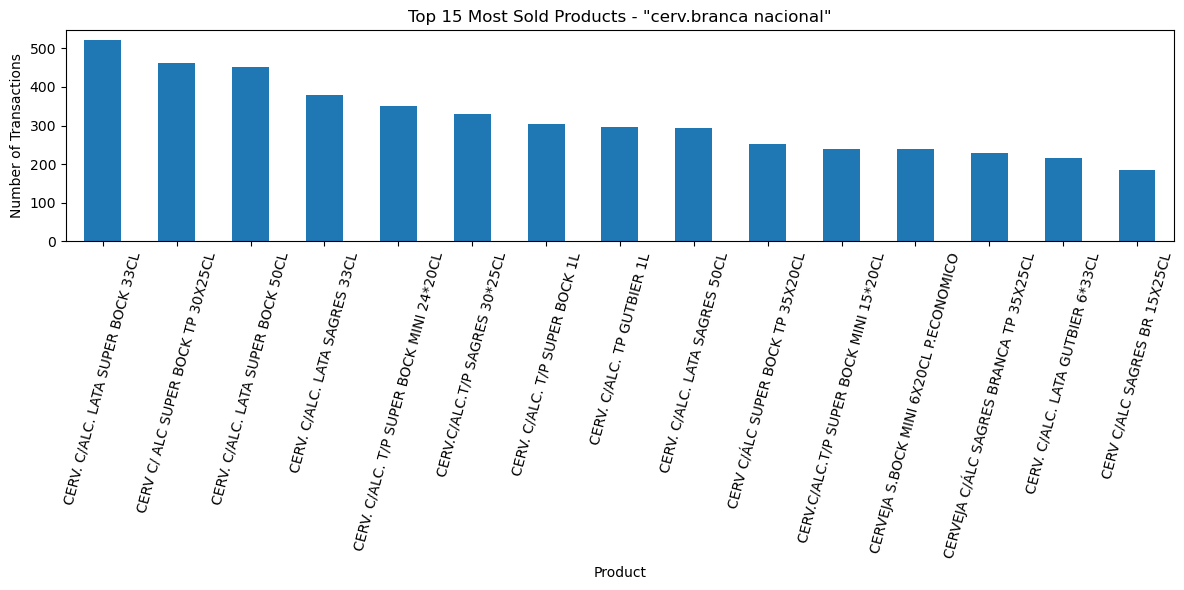

In [120]:
# Top 15 produtos mais vendidos (número de transações em que aparecem)
all_products = basket['transactions'].explode()
product_counts = all_products.value_counts()

# Gráfico: produtos mais vendidos
plt.figure(figsize=(12,6))
product_counts.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "cerv.branca nacional"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

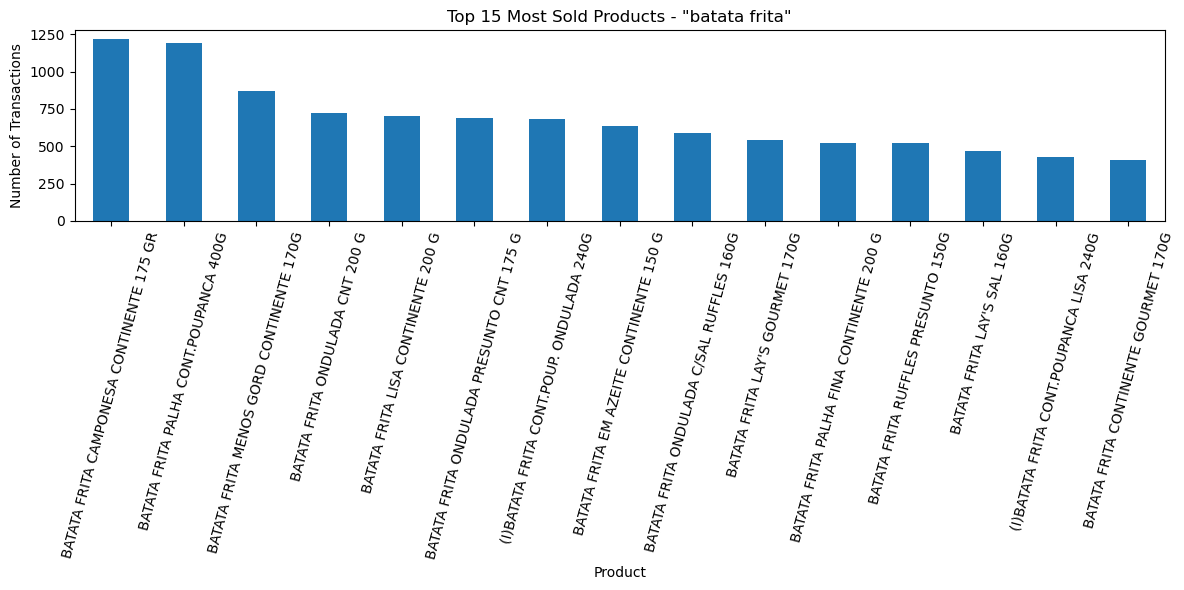

In [122]:
import matplotlib.pyplot as plt

# Top 15 produtos mais vendidos para batata frita
all_products_batata = basket_batata_frita['transactions'].explode()
product_counts_batata = all_products_batata.value_counts()

# Gráfico: produtos mais vendidos em batata frita
plt.figure(figsize=(12, 6))
product_counts_batata.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "batata frita"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


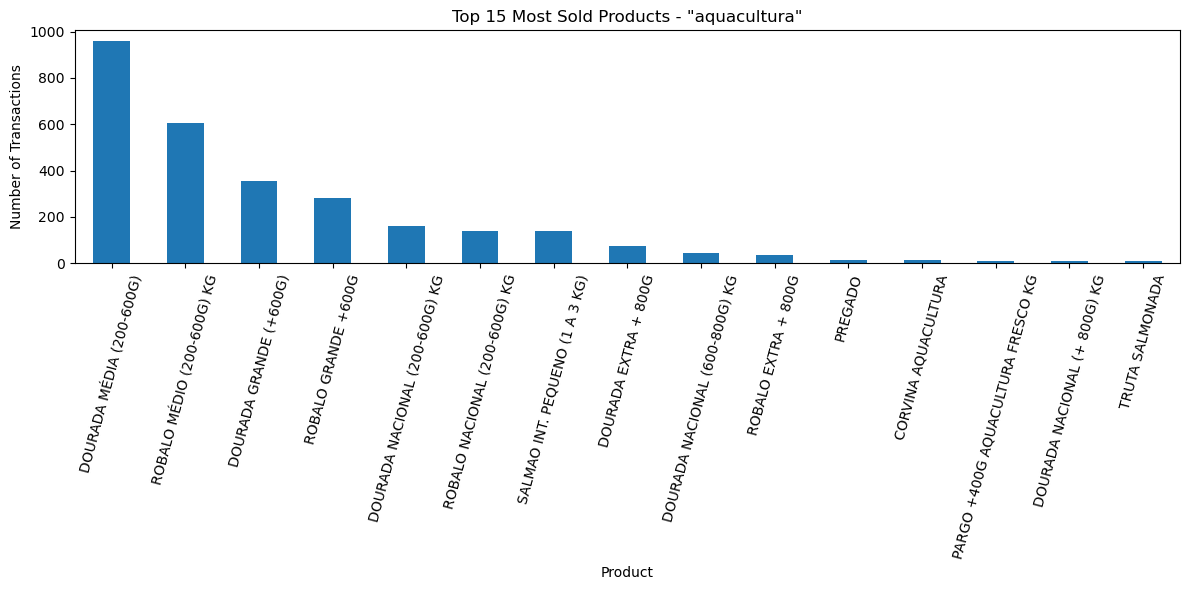

In [124]:
# Top 15 produtos mais vendidos para aquacultura
all_products_aquacultura = basket_aquacultura['transactions'].explode()
product_counts_aquacultura = all_products_aquacultura.value_counts()

# Gráfico: produtos mais vendidos em aquacultura
plt.figure(figsize=(12, 6))
product_counts_aquacultura.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "aquacultura"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

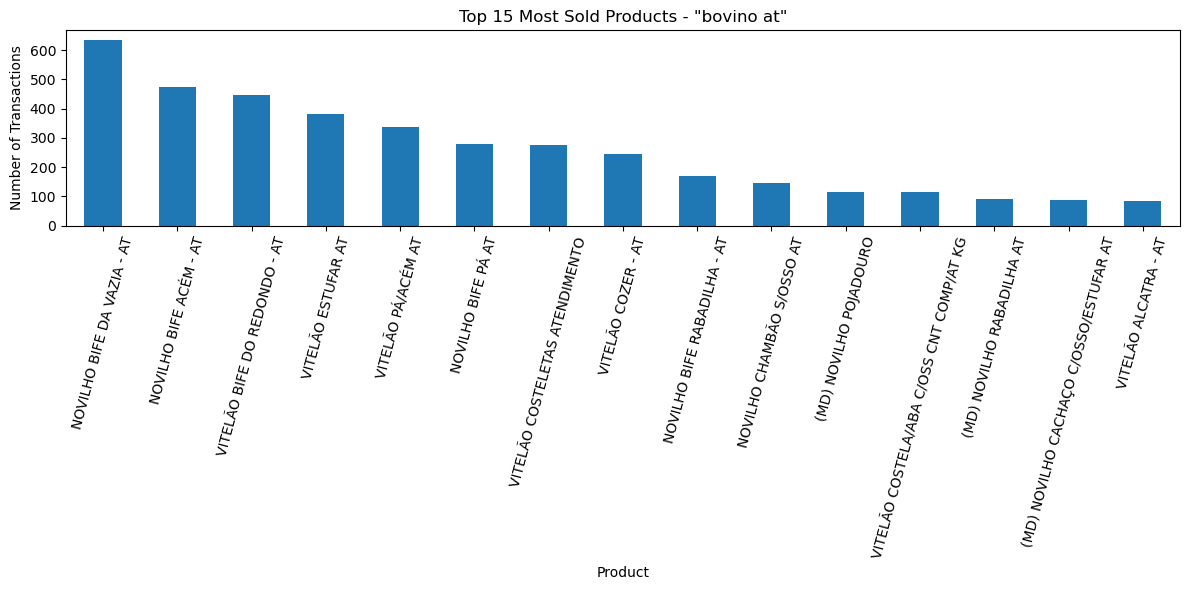

In [128]:
# Top 15 produtos mais vendidos para bovino at
all_products_bovino_at = basket_bovino_at['transactions'].explode()
product_counts_bovino_at = all_products_bovino_at.value_counts()

plt.figure(figsize=(12, 6))
product_counts_bovino_at.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "bovino at"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


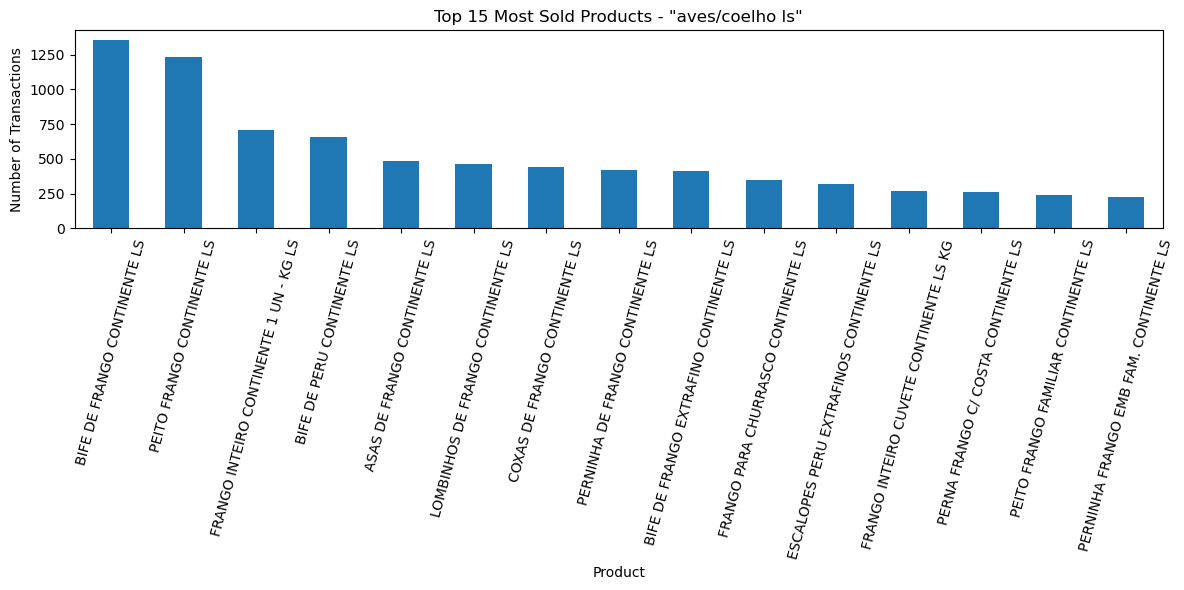

In [130]:

# Top 15 produtos mais vendidos para aves/coelho ls
all_products_aves_coelho_ls = basket_aves_coelho_ls['transactions'].explode()
product_counts_aves_coelho_ls = all_products_aves_coelho_ls.value_counts()

plt.figure(figsize=(12, 6))
product_counts_aves_coelho_ls.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "aves/coelho ls"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


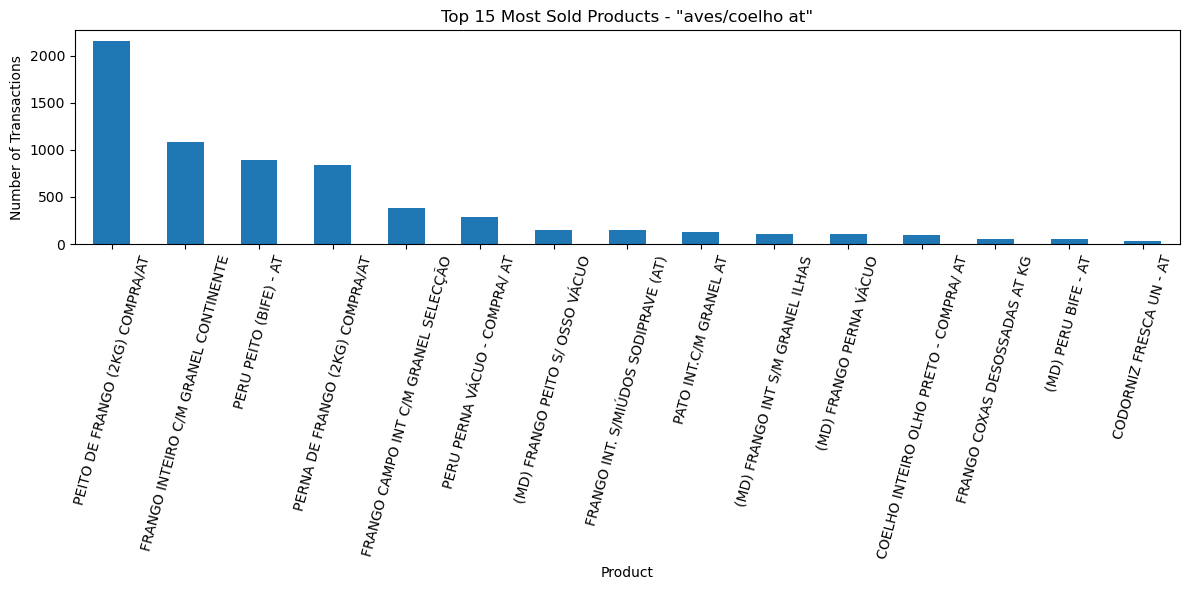

In [132]:

# Top 15 produtos mais vendidos para aves/coelho at
all_products_aves_coelho_at = basket_aves_coelho_at['transactions'].explode()
product_counts_aves_coelho_at = all_products_aves_coelho_at.value_counts()

plt.figure(figsize=(12, 6))
product_counts_aves_coelho_at.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "aves/coelho at"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


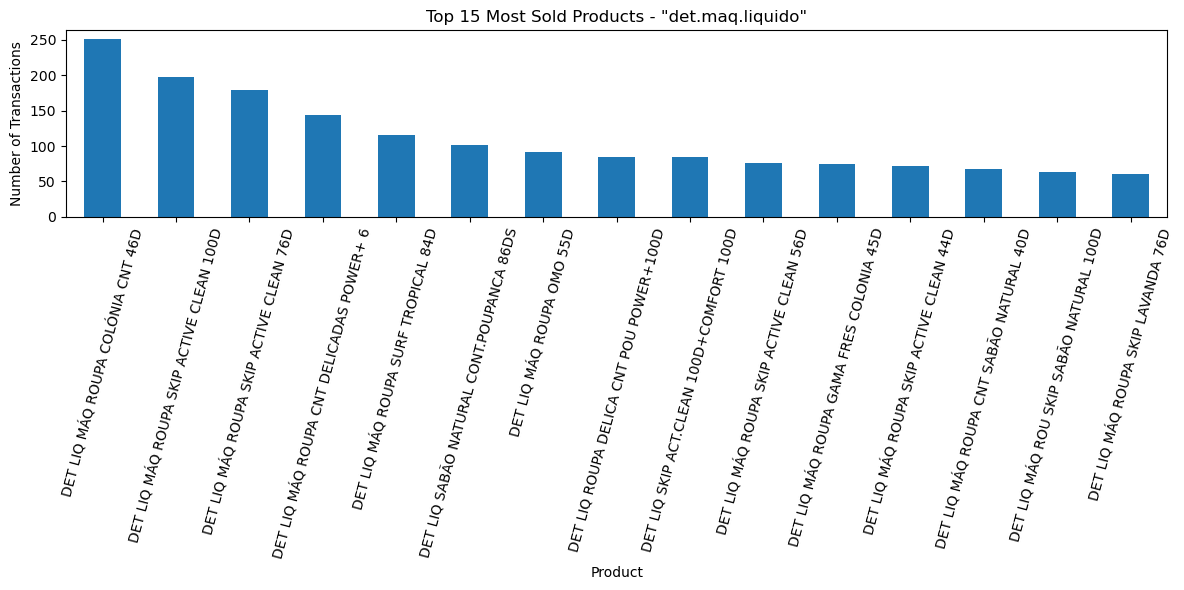

In [134]:

# Top 15 produtos mais vendidos para det.maq.liquido
all_products_detmaqliquido = basket_detmaqliquido['transactions'].explode()
product_counts_detmaqliquido = all_products_detmaqliquido.value_counts()

plt.figure(figsize=(12, 6))
product_counts_detmaqliquido.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "det.maq.liquido"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


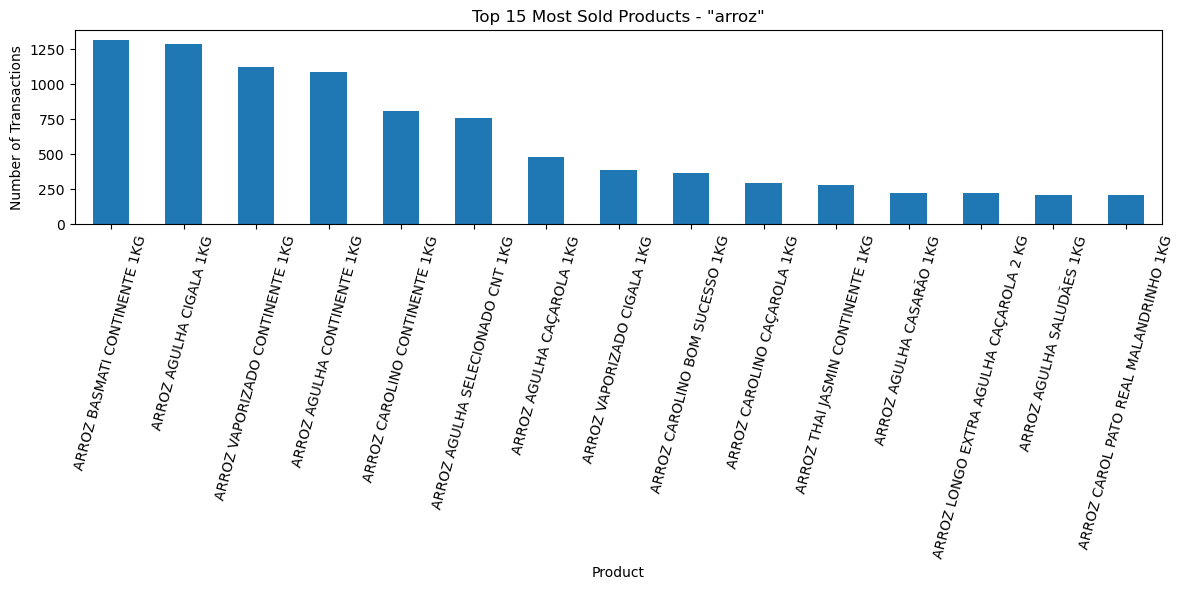

In [156]:

# Top 15 produtos mais vendidos para arroz
all_products_arroz = basket_arroz['transactions'].explode()
product_counts_arroz = all_products_arroz.value_counts()

plt.figure(figsize=(12, 6))
product_counts_arroz.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "arroz"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

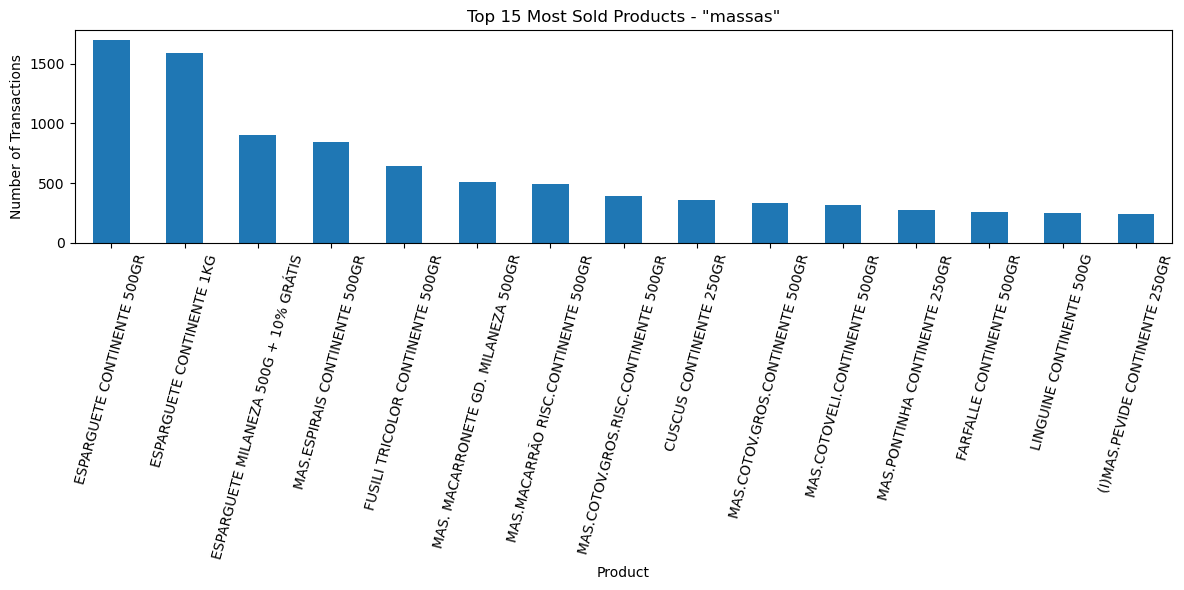

In [148]:

# Top 15 produtos mais vendidos para massas
all_products_massas = basket_massas['transactions'].explode()
product_counts_massas = all_products_massas.value_counts()

plt.figure(figsize=(12, 6))
product_counts_massas.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "massas"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


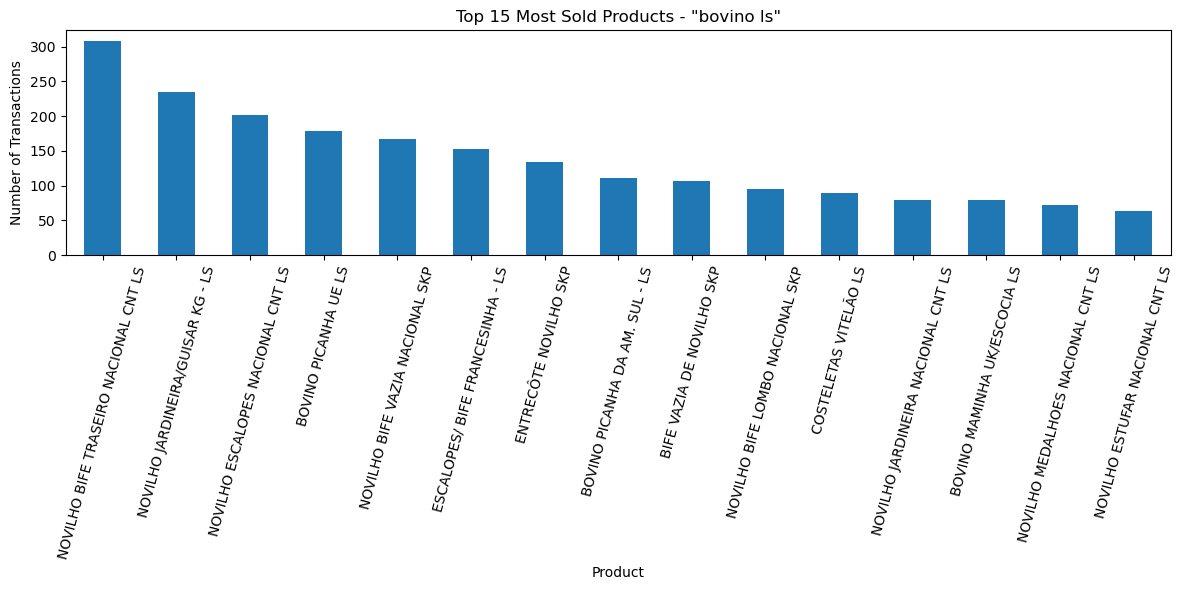

In [140]:

# Top 15 produtos mais vendidos para bovino ls
all_products_bovino_ls = basket_bovino_ls['transactions'].explode()
product_counts_bovino_ls = all_products_bovino_ls.value_counts()

plt.figure(figsize=(12, 6))
product_counts_bovino_ls.head(15).plot(kind='bar')
plt.title('Top 15 Most Sold Products - "bovino ls"')
plt.ylabel('Number of Transactions')
plt.xlabel('Product')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


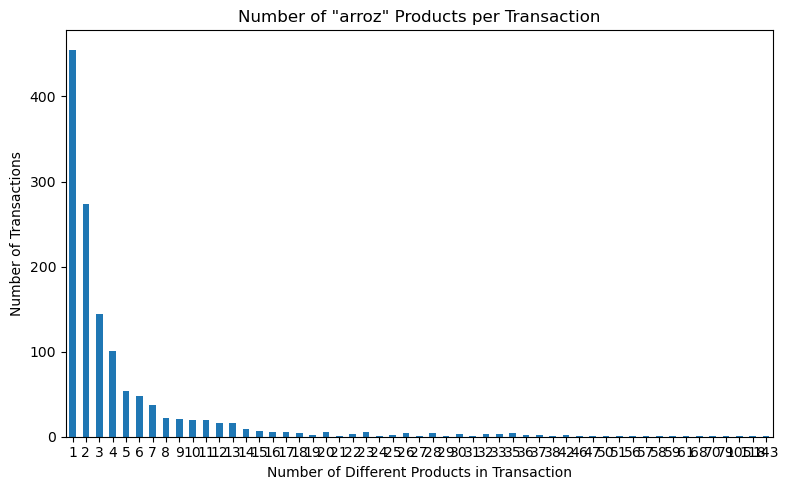

In [158]:
# Calcular o número de produtos diferentes por transação (tamanho da lista)
num_products_per_transaction = basket['transactions'].apply(len)

# Gráfico: distribuição do número de produtos por transação
plt.figure(figsize=(8,5))
num_products_per_transaction.value_counts().sort_index().plot(kind='bar')
plt.title(f'Number of "{selected_subcategory}" Products per Transaction')
plt.xlabel('Number of Different Products in Transaction')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### Setting the paramaters -min support & confidence

1. Output example of min support and confidence established (just to visualize how this works)

In [59]:
# Aplicar o apriori

frequent_itemsets = apriori(encoded_df, min_support=0.01, use_colnames=True)
frequent_itemsets

support                                           itemsets
0   0.165913                (CERV C/ ALC SUPER BOCK TP 30X25CL)
1   0.010558                     (CERV C/ALC CRISTAL TP 6X25CL)
2   0.033183                     (CERV C/ALC LATA GUTBIER 50CL)
3   0.011312            (CERV C/ALC S.BOCK S/ GLUTEN TP 6X33CL)
4   0.076169                     (CERV C/ALC SAGRES BR 15X25CL)
..       ...                                                ...
93  0.015083  (CERV C/ ALC SUPER BOCK TP 30X25CL, CERV. C/AL...
94  0.012066  (CERV C/ ALC SUPER BOCK TP 30X25CL, CERV. C/AL...
95  0.012066  (CERV C/ÁLC SUPER BOCK TP 35X20CL, CERV. C/ALC...
96  0.010558  (CERV. C/ALC. LATA SUPER BOCK 33CL, CERV. C/AL...
97  0.011312  (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO, CERV....

[98 rows x 2 columns]

In [61]:
# Gerar regras de associação
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)

rules = rules[rules['antecedents'] != rules['consequents']]

rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

antecedents  \
0                  (CERV C/ ALC SUPER BOCK TP 30X25CL)   
1                   (CERV C/ÁLC SUPER BOCK TP 35X20CL)   
2                  (CERV C/ ALC SUPER BOCK TP 30X25CL)   
3                  (CERV. C/ALC. LATA SUPER BOCK 33CL)   
4                  (CERV C/ ALC SUPER BOCK TP 30X25CL)   
..                                                 ...   
131  (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO, CERV....   
132  (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL, CER...   
133           (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)   
134         (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL)   
135           (CERV.C/ALC.T/P SUPER BOCK MINI 15*20CL)   

                                           consequents   support  confidence  \
0                   (CERV C/ÁLC SUPER BOCK TP 35X20CL)  0.037707    0.227273   
1                  (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.037707    0.357143   
2                  (CERV. C/ALC. LATA SUPER BOCK 33CL)  0.012066    0.072727   
3                  (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.012066    0.100629   
4                  (CERV. C/ALC. LATA SUPER BOCK 50CL)  0.010558    0.063636   
..                                                 ...       ...         ...   
131         (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL)  0.011312    0.500000   
132           (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)  0.011312    0.319149   
133  (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL, CER...  0.011312    0.114504   
134  (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO, CERV....  0.011312    0.083799   
135  (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO, CERV....  0.011312    0.104167   

         lift  
0    2.152597  
1    2.152597  
2    0.606518  
3    0.606518  
4    0.555144  
..        ...  
131  3.703911  
132  3.230469  
133  3.230469  
134  3.703911  
135  5.755208  

[136 rows x 5 columns]

In [162]:
# Apriori for bovino at
frequent_itemsets_bovino_at = apriori(encoded_df_bovino_at, min_support=0.01, use_colnames=True)
rules_bovino_at = association_rules(frequent_itemsets_bovino_at, metric="confidence", min_threshold=0.01)
rules_bovino_at = rules_bovino_at[rules_bovino_at['antecedents'] != rules_bovino_at['consequents']]

print("\nAssociation Rules for bovino at")
display(rules_bovino_at[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Association Rules for bovino at


antecedents  \
362   ((MD) NOVILHO CHÃ FORA AT, (MD) NOVILHO ACÉM C...   
367                      ((MD)NOVILHO GANSO REDONDO AT)   
1325  ((MD) NOVILHO ACÉM C/OSSO AT, (MD) NOVILHO RAB...   
1320  ((MD) NOVILHO POJADOURO, (MD) NOVILHO CACHAÇO ...   
381   ((MD) NOVILHO ACÉM C/OSSO AT, (MD) NOVILHO RAB...   
384                      ((MD)NOVILHO GANSO REDONDO AT)   
374   ((MD) NOVILHO POJADOURO, (MD) NOVILHO ACÉM C/O...   
379                      ((MD)NOVILHO GANSO REDONDO AT)   
383                       ((MD) NOVILHO ACÉM C/OSSO AT)   
382   ((MD)NOVILHO GANSO REDONDO AT, (MD) NOVILHO RA...   

                                            consequents   support  confidence  \
362                      ((MD)NOVILHO GANSO REDONDO AT)  0.010989    0.733333   
367   ((MD) NOVILHO CHÃ FORA AT, (MD) NOVILHO ACÉM C...  0.010989    0.550000   
1325  ((MD) NOVILHO POJADOURO, (MD) NOVILHO CACHAÇO ...  0.010989    0.647059   
1320  ((MD) NOVILHO ACÉM C/OSSO AT, (MD) NOVILHO RAB...  0.010989    0.578947   
381                      ((MD)NOVILHO GANSO REDONDO AT)  0.010989    0.647059   
384   ((MD) NOVILHO ACÉM C/OSSO AT, (MD) NOVILHO RAB...  0.010989    0.550000   
374                      ((MD)NOVILHO GANSO REDONDO AT)  0.011988    0.631579   
379   ((MD) NOVILHO POJADOURO, (MD) NOVILHO ACÉM C/O...  0.011988    0.600000   
383   ((MD)NOVILHO GANSO REDONDO AT, (MD) NOVILHO RA...  0.010989    0.392857   
382                       ((MD) NOVILHO ACÉM C/OSSO AT)  0.010989    0.846154   

           lift  
362   36.703333  
367   36.703333  
1325  34.089783  
1320  34.089783  
381   32.385294  
384   32.385294  
374   31.610526  
379   31.610526  
383   30.250000  
382   30.250000

In [240]:

# Apriori for aves/coelho ls
frequent_itemsets_aves_coelho_ls = apriori(encoded_df_aves_coelho_ls, min_support=0.01, use_colnames=True)
rules_aves_coelho_ls = association_rules(frequent_itemsets_aves_coelho_ls, metric="confidence", min_threshold=0.01)
rules_aves_coelho_ls = rules_aves_coelho_ls[rules_aves_coelho_ls['antecedents'] != rules_aves_coelho_ls['consequents']]

print("\nAssociation Rules for aves/coelho ls")
display(rules_aves_coelho_ls[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))




Association Rules for aves/coelho ls


antecedents  \
1666  (BIFE DE FRANGO CONTINENTE LS, ESCALOPES PERU ...   
1663  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, ESCAL...   
1665  (ESCALOPES PERU EXTRAFINOS CONTINENTE LS, BIFE...   
1664  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, ESCAL...   
1569  (BIFE DE FRANGO CONTINENTE LS, ESCALOPES PERU ...   
1564  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...   
2321  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...   
2340  (ESCALOPES PERU EXTRAFINOS CONTINENTE LS, BIFE...   
2329  (PEITO FRANGO CONTINENTE LS, ESCALOPES PERU EX...   
2332  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...   

                                            consequents   support  confidence  \
1666  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, ESCAL...  0.010303    0.461538   
1663  (BIFE DE FRANGO CONTINENTE LS, ESCALOPES PERU ...  0.010303    0.339623   
1665  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, ESCAL...  0.010303    0.214286   
1664  (ESCALOPES PERU EXTRAFINOS CONTINENTE LS, BIFE...  0.010303    0.666667   
1569  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...  0.012593    0.564103   
1564  (BIFE DE FRANGO CONTINENTE LS, ESCALOPES PERU ...  0.012593    0.285714   
2321  (ESCALOPES PERU EXTRAFINOS CONTINENTE LS, BIFE...  0.014310    0.595238   
2340  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...  0.014310    0.297619   
2329  (BIFE DE FRANGO EXTRAFINO CONTINENTE LS, BIFE ...  0.014310    0.480769   
2332  (PEITO FRANGO CONTINENTE LS, ESCALOPES PERU EX...  0.014310    0.324675   

           lift  
1666  15.213353  
1663  15.213353  
1665  13.865079  
1664  13.865079  
1569  12.798535  
1564  12.798535  
2321  12.379535  
2340  12.379535  
2329  10.907842  
2332  10.907842

In [164]:


# Apriori for aves/coelho at
frequent_itemsets_aves_coelho_at = apriori(encoded_df_aves_coelho_at, min_support=0.01, use_colnames=True)
rules_aves_coelho_at = association_rules(frequent_itemsets_aves_coelho_at, metric="confidence", min_threshold=0.01)
rules_aves_coelho_at = rules_aves_coelho_at[rules_aves_coelho_at['antecedents'] != rules_aves_coelho_at['consequents']]

print("\nAssociation Rules for aves/coelho at")
display(rules_aves_coelho_at[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Association Rules for aves/coelho at


antecedents  \
72  ((MD) FRANGO PEITO S/ OSSO VÁCUO, FRANGO INT. ...   
77                 ((MD) FRANGO INT S/M GRANEL ILHAS)   
76              (FRANGO INT. S/MIÚDOS SODIPRAVE (AT))   
73  ((MD) FRANGO PEITO S/ OSSO VÁCUO, (MD) FRANGO ...   
4               (FRANGO INT. S/MIÚDOS SODIPRAVE (AT))   
5                  ((MD) FRANGO INT S/M GRANEL ILHAS)   
74  (FRANGO INT. S/MIÚDOS SODIPRAVE (AT), (MD) FRA...   
75                  ((MD) FRANGO PEITO S/ OSSO VÁCUO)   
0                   ((MD) FRANGO PEITO S/ OSSO VÁCUO)   
1                  ((MD) FRANGO INT S/M GRANEL ILHAS)   

                                          consequents   support  confidence  \
72                 ((MD) FRANGO INT S/M GRANEL ILHAS)  0.013043    0.714286   
77  ((MD) FRANGO PEITO S/ OSSO VÁCUO, FRANGO INT. ...  0.013043    0.483871   
76  ((MD) FRANGO PEITO S/ OSSO VÁCUO, (MD) FRANGO ...  0.013043    0.428571   
73              (FRANGO INT. S/MIÚDOS SODIPRAVE (AT))  0.013043    0.789474   
4                  ((MD) FRANGO INT S/M GRANEL ILHAS)  0.020000    0.657143   
5               (FRANGO INT. S/MIÚDOS SODIPRAVE (AT))  0.020000    0.741935   
74                  ((MD) FRANGO PEITO S/ OSSO VÁCUO)  0.013043    0.652174   
75  (FRANGO INT. S/MIÚDOS SODIPRAVE (AT), (MD) FRA...  0.013043    0.405405   
0                  ((MD) FRANGO INT S/M GRANEL ILHAS)  0.016522    0.513514   
1                   ((MD) FRANGO PEITO S/ OSSO VÁCUO)  0.016522    0.612903   

         lift  
72  26.497696  
77  26.497696  
76  25.939850  
73  25.939850  
4   24.377880  
5   24.377880  
74  20.270270  
75  20.270270  
0   19.049695  
1   19.049695

In [166]:

# Apriori for det.maq.liquido
frequent_itemsets_detmaqliquido = apriori(encoded_df_detmaqliquido, min_support=0.01, use_colnames=True)
rules_detmaqliquido = association_rules(frequent_itemsets_detmaqliquido, metric="confidence", min_threshold=0.01)
rules_detmaqliquido = rules_detmaqliquido[rules_detmaqliquido['antecedents'] != rules_detmaqliquido['consequents']]

print("\nAssociation Rules for det.maq.liquido")
display(rules_detmaqliquido[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Association Rules for det.maq.liquido


antecedents  \
17   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)   
16   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 56D)   
13  (DET LIQ MÁQ ROUPA SKIP ACTIVE FRESH 100D)   
12  (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 100D)   
5    (DET LIQ ROUPA DELICA CNT POU POWER+100D)   
4   (DET LIQ MÁQ ROUPA CNT DELICADAS POWER+ 6)   
0    (DET LIQ MÁQ ROU SKIP SABÃO NATURAL 100D)   
1   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 100D)   
19   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)   
18   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)   

                                   consequents   support  confidence      lift  
17   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 56D)  0.014252    0.339623  6.918442  
16   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)  0.014252    0.290323  6.918442  
13  (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 100D)  0.013460    0.586207  6.610530  
12  (DET LIQ MÁQ ROUPA SKIP ACTIVE FRESH 100D)  0.013460    0.151786  6.610530  
5   (DET LIQ MÁQ ROUPA CNT DELICADAS POWER+ 6)  0.012668    0.290909  4.536027  
4    (DET LIQ ROUPA DELICA CNT POU POWER+100D)  0.012668    0.197531  4.536027  
0   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 100D)  0.012668    0.333333  3.758929  
1    (DET LIQ MÁQ ROU SKIP SABÃO NATURAL 100D)  0.012668    0.142857  3.758929  
19   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)  0.013460    0.320755  3.215184  
18   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)  0.013460    0.134921  3.215184

In [168]:

# Apriori for arroz
frequent_itemsets_arroz = apriori(encoded_df_arroz, min_support=0.01, use_colnames=True)
rules_arroz = association_rules(frequent_itemsets_arroz, metric="confidence", min_threshold=0.01)
rules_arroz = rules_arroz[rules_arroz['antecedents'] != rules_arroz['consequents']]

print("\nAssociation Rules for arroz")
display(rules_arroz[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Association Rules for arroz


antecedents  \
21                      (ARROZ AGULHA BOM SUCESSO 1KG)   
20                    (ARROZ CAROLINO BOM SUCESSO 1KG)   
144  (ARROZ AGULHA CIGALA 1KG, ARROZ AGULHA SALUDÃE...   
145                        (ARROZ AGULHA CAÇAROLA 1KG)   
146                        (ARROZ AGULHA SALUDÃES 1KG)   
143  (ARROZ AGULHA CAÇAROLA 1KG, ARROZ AGULHA CIGAL...   
12                         (ARROZ AGULHA SALUDÃES 1KG)   
13               (ARR CAROLINO EXT LONGO SALUDÃES 1KG)   
14             (ARROZ CAROL PATO REAL MALANDRINHO 1KG)   
15               (ARR CAROLINO EXT LONGO SALUDÃES 1KG)   

                                           consequents   support  confidence  \
21                    (ARROZ CAROLINO BOM SUCESSO 1KG)  0.013333    0.393939   
20                      (ARROZ AGULHA BOM SUCESSO 1KG)  0.013333    0.209677   
144                        (ARROZ AGULHA CAÇAROLA 1KG)  0.012821    0.531915   
145  (ARROZ AGULHA CIGALA 1KG, ARROZ AGULHA SALUDÃE...  0.012821    0.125000   
146  (ARROZ AGULHA CAÇAROLA 1KG, ARROZ AGULHA CIGAL...  0.012821    0.240385   
143                        (ARROZ AGULHA SALUDÃES 1KG)  0.012821    0.257732   
12               (ARR CAROLINO EXT LONGO SALUDÃES 1KG)  0.012821    0.240385   
13                         (ARROZ AGULHA SALUDÃES 1KG)  0.012821    0.245098   
14               (ARR CAROLINO EXT LONGO SALUDÃES 1KG)  0.010256    0.212766   
15             (ARROZ CAROL PATO REAL MALANDRINHO 1KG)  0.010256    0.196078   

         lift  
21   6.195015  
20   6.195015  
144  5.186170  
145  5.186170  
146  4.832474  
143  4.832474  
12   4.595588  
13   4.595588  
14   4.067584  
15   4.067584

In [170]:

# Apriori for massas
frequent_itemsets_massas = apriori(encoded_df_massas, min_support=0.01, use_colnames=True)
rules_massas = association_rules(frequent_itemsets_massas, metric="confidence", min_threshold=0.01)
rules_massas = rules_massas[rules_massas['antecedents'] != rules_massas['consequents']]

print("\nAssociation Rules for massas")
display(rules_massas[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))



Association Rules for massas


antecedents  \
1436  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS, MAS.MA...   
1441         (MAS MACA RISCADO MILANEZA 500G + 10% GRÁ)   
1440               (MAS.MACARR. RISCADO MILANEZA 500GR)   
1437  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS, MAS MA...   
1491  (MAS.ESPIRAIS MILANEZA 500GR, ESPARGUETE MILAN...   
1494          (MASSA ESPIRAIS MILANEZA 500G+10% GRÁTIS)   
1492  (MASSA ESPIRAIS MILANEZA 500G+10% GRÁTIS, ESPA...   
1493                      (MAS.ESPIRAIS MILANEZA 500GR)   
436                (MAS.MACARR. RISCADO MILANEZA 500GR)   
437          (MAS MACA RISCADO MILANEZA 500G + 10% GRÁ)   

                                            consequents   support  confidence  \
1436         (MAS MACA RISCADO MILANEZA 500G + 10% GRÁ)  0.011467    0.480000   
1441  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS, MAS.MA...  0.011467    0.269663   
1440  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS, MAS MA...  0.011467    0.220183   
1437               (MAS.MACARR. RISCADO MILANEZA 500GR)  0.011467    0.585366   
1491          (MASSA ESPIRAIS MILANEZA 500G+10% GRÁTIS)  0.011467    0.533333   
1494  (MAS.ESPIRAIS MILANEZA 500GR, ESPARGUETE MILAN...  0.011467    0.203390   
1492                      (MAS.ESPIRAIS MILANEZA 500GR)  0.011467    0.489796   
1493  (MASSA ESPIRAIS MILANEZA 500G+10% GRÁTIS, ESPA...  0.011467    0.212389   
436          (MAS MACA RISCADO MILANEZA 500G + 10% GRÁ)  0.019589    0.376147   
437                (MAS.MACARR. RISCADO MILANEZA 500GR)  0.019589    0.460674   

           lift  
1436  11.288090  
1441  11.288090  
1440  11.240098  
1437  11.240098  
1491   9.459887  
1494   9.459887  
1492   9.072061  
1493   9.072061  
436    8.845789  
437    8.845789

In [172]:

# Apriori for bovino ls
frequent_itemsets_bovino_ls = apriori(encoded_df_bovino_ls, min_support=0.01, use_colnames=True)
rules_bovino_ls = association_rules(frequent_itemsets_bovino_ls, metric="confidence", min_threshold=0.01)
rules_bovino_ls = rules_bovino_ls[rules_bovino_ls['antecedents'] != rules_bovino_ls['consequents']]

print("\nAssociation Rules for bovino ls")
display(rules_bovino_ls[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))




Association Rules for bovino ls


antecedents  \
92                  (NOVILHO BIFE LOMBO NACIONAL SKP)   
89  (ENTRECÔTE NOVILHO SKP, NOVILHO BIFE VAZIA NAC...   
88  (ENTRECÔTE NOVILHO SKP, NOVILHO BIFE LOMBO NAC...   
93                  (NOVILHO BIFE VAZIA NACIONAL SKP)   
84  (NOVILHO BIFE VAZIA NACIONAL SKP, BIFE VAZIA D...   
85                            (ENTRECÔTE NOVILHO SKP)   
52                  (NOVILHO BIFE LOMBO NACIONAL SKP)   
53                  (NOVILHO BIFE VAZIA NACIONAL SKP)   
91                            (ENTRECÔTE NOVILHO SKP)   
90  (NOVILHO BIFE LOMBO NACIONAL SKP, NOVILHO BIFE...   

                                          consequents   support  confidence  \
92  (ENTRECÔTE NOVILHO SKP, NOVILHO BIFE VAZIA NAC...  0.012210    0.370370   
89                  (NOVILHO BIFE LOMBO NACIONAL SKP)  0.012210    0.476190   
88                  (NOVILHO BIFE VAZIA NACIONAL SKP)  0.012210    0.909091   
93  (ENTRECÔTE NOVILHO SKP, NOVILHO BIFE LOMBO NAC...  0.012210    0.156250   
84                            (ENTRECÔTE NOVILHO SKP)  0.010989    0.750000   
85  (NOVILHO BIFE VAZIA NACIONAL SKP, BIFE VAZIA D...  0.010989    0.126761   
52                  (NOVILHO BIFE VAZIA NACIONAL SKP)  0.020757    0.629630   
53                  (NOVILHO BIFE LOMBO NACIONAL SKP)  0.020757    0.265625   
91  (NOVILHO BIFE LOMBO NACIONAL SKP, NOVILHO BIFE...  0.012210    0.140845   
90                            (ENTRECÔTE NOVILHO SKP)  0.012210    0.588235   

         lift  
92  14.444444  
89  14.444444  
88  11.633523  
93  11.633523  
84   8.651408  
85   8.651408  
52   8.057292  
53   8.057292  
91   6.785418  
90   6.785418

In [174]:
# Apriori for batata frita
frequent_itemsets_batata_frita = apriori(encoded_df_batata_frita, min_support=0.01, use_colnames=True)
rules_batata_frita = association_rules(frequent_itemsets_batata_frita, metric="confidence", min_threshold=0.01)
rules_batata_frita = rules_batata_frita[rules_batata_frita['antecedents'] != rules_batata_frita['consequents']]

print("\nAssociation Rules for batata frita")
display(rules_batata_frita[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))




Association Rules for batata frita


antecedents  \
1256  (BATATA FRITA ONDULADA CNT 200 G, (I)BATATA FR...   
1261  (BATATA FRITA LISA CONTINENTE 200 G, (I)BATATA...   
1259  ((I)BATATA FRITA CONT.POUPANCA LISA 240G, (I)B...   
1258  (BATATA FRITA ONDULADA CNT 200 G, BATATA FRITA...   
843                   (BATATA FRITA LAY'S GOURMET 170G)   
838   (BATATA FRITA LAY'S MEDITERRÂNEAS 150G, BAT FR...   
1427  (BATATA FRITA ONDULADA CNT 200 G, BATATA FRITA...   
1426  (BATATA FRITA ONDULADA PRESUNTO CNT 175 G, BAT...   
848           (BAT FRITA LAY'S GOURMET FINISSIMAS 170G)   
845   (BATATA FRITA LAY'S SAL 160G, BATATA FRITA LAY...   

                                            consequents   support  confidence  \
1256  (BATATA FRITA LISA CONTINENTE 200 G, (I)BATATA...  0.016098    0.447368   
1261  (BATATA FRITA ONDULADA CNT 200 G, (I)BATATA FR...  0.016098    0.306306   
1259  (BATATA FRITA ONDULADA CNT 200 G, BATATA FRITA...  0.016098    0.365591   
1258  ((I)BATATA FRITA CONT.POUPANCA LISA 240G, (I)B...  0.016098    0.298246   
843   (BATATA FRITA LAY'S MEDITERRÂNEAS 150G, BAT FR...  0.010890    0.094650   
838                   (BATATA FRITA LAY'S GOURMET 170G)  0.010890    0.766667   
1427  (BATATA FRITA ONDULADA PRESUNTO CNT 175 G, BAT...  0.014205    0.236220   
1426  (BATATA FRITA ONDULADA CNT 200 G, BATATA FRITA...  0.014205    0.384615   
848   (BATATA FRITA LAY'S SAL 160G, BATATA FRITA LAY...  0.013258    0.142132   
845           (BAT FRITA LAY'S GOURMET FINISSIMAS 170G)  0.013258    0.595745   

          lift  
1256  8.512091  
1261  8.512091  
1259  6.773062  
1258  6.773062  
843   6.663374  
838   6.663374  
1427  6.396124  
1426  6.396124  
848   6.386867  
845   6.386867

In [178]:
# Apriori for aquacultura
frequent_itemsets_aquacultura = apriori(encoded_df_aquacultura, min_support=0.01, use_colnames=True)
rules_aquacultura = association_rules(frequent_itemsets_aquacultura, metric="confidence", min_threshold=0.01)
rules_aquacultura = rules_aquacultura[rules_aquacultura['antecedents'] != rules_aquacultura['consequents']]

print("\nAssociation Rules for aquacultura")
display(rules_aquacultura[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))




Association Rules for aquacultura


antecedents  \
86                    (DOURADA NACIONAL (600-800G) KG)   
83    (DOURADA EXTRA + 800G, DOURADA MÉDIA (200-600G))   
80                    (DOURADA NACIONAL (600-800G) KG)   
77      (DOURADA EXTRA + 800G, DOURADA GRANDE (+600G))   
521  (ROBALO MÉDIO (200-600G) KG, DOURADA NACIONAL ...   
508  (ROBALO GRANDE +600G, ROBALO NACIONAL (200-600...   
507  (ROBALO GRANDE +600G, ROBALO MÉDIO (200-600G) ...   
522  (ROBALO NACIONAL (200-600G) KG, DOURADA MÉDIA ...   
437  (ROBALO NACIONAL (200-600G) KG, DOURADA MÉDIA ...   
432  (DOURADA NACIONAL (200-600G) KG, ROBALO MÉDIO ...   

                                           consequents   support  confidence  \
86    (DOURADA EXTRA + 800G, DOURADA MÉDIA (200-600G))  0.010929    0.222222   
83                    (DOURADA NACIONAL (600-800G) KG)  0.010929    0.470588   
80      (DOURADA EXTRA + 800G, DOURADA GRANDE (+600G))  0.010929    0.222222   
77                    (DOURADA NACIONAL (600-800G) KG)  0.010929    0.421053   
521  (ROBALO GRANDE +600G, ROBALO NACIONAL (200-600...  0.010929    0.177778   
508  (ROBALO MÉDIO (200-600G) KG, DOURADA NACIONAL ...  0.010929    0.500000   
507  (ROBALO NACIONAL (200-600G) KG, DOURADA MÉDIA ...  0.010929    0.470588   
522  (ROBALO GRANDE +600G, ROBALO MÉDIO (200-600G) ...  0.010929    0.186047   
437  (DOURADA NACIONAL (200-600G) KG, ROBALO MÉDIO ...  0.025956    0.441860   
432  (ROBALO NACIONAL (200-600G) KG, DOURADA MÉDIA ...  0.025956    0.422222   

         lift  
86   9.568627  
83   9.568627  
80   8.561404  
77   8.561404  
521  8.133333  
508  8.133333  
507  8.010944  
522  8.010944  
437  7.187597  
432  7.187597

### Setting the min support - find the most sutable for the analysis

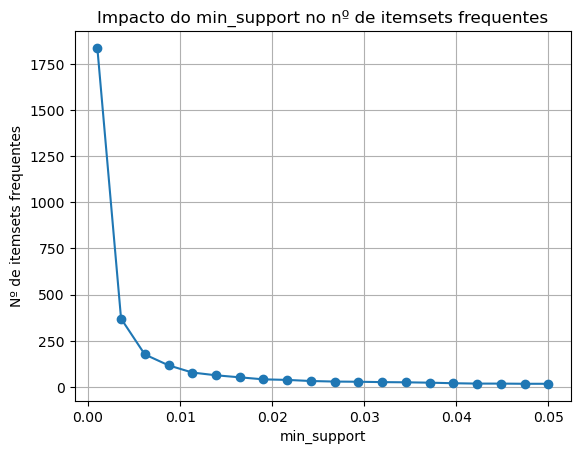

In [180]:
# Define the min support

support_values = np.linspace(0.001, 0.05, 20)
num_itemsets = []

for s in support_values:
    frequent_itemsets = apriori(encoded_df, min_support=s, use_colnames=True)
    num_itemsets.append(len(frequent_itemsets))

plt.plot(support_values, num_itemsets, marker='o')
plt.title("Impacto do min_support no nº de itemsets frequentes")
plt.xlabel("min_support")
plt.ylabel("Nº de itemsets frequentes")
plt.grid(True)
plt.show()


### Setting the min confidence - find the most sutable for the analysis

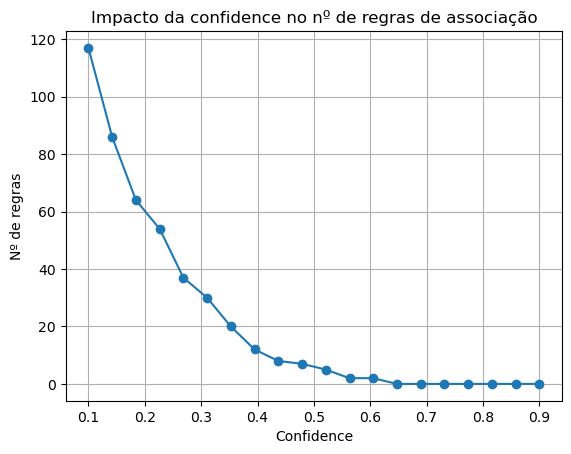

In [65]:
# Define the confidence

# Primeiro: gerar os frequent_itemsets com o min_support já escolhido
frequent_itemsets = apriori(encoded_df, min_support=0.005, use_colnames=True)

# Gerar todas as regras com lift >= 1.0 (mínimo recomendado para não gerar regras inúteis)
#rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Preparar análise para vários thresholds de confidence
confidence_values = np.linspace(0.1, 0.9, 20)
num_rules = []

for c in confidence_values:
    filtered_rules = rules[rules['confidence'] >= c]
    # Também podemos aqui já evitar regras triviais:
    filtered_rules = filtered_rules[filtered_rules['antecedents'] != filtered_rules['consequents']]
    num_rules.append(len(filtered_rules))

# Plot do impacto da confidence
plt.plot(confidence_values, num_rules, marker='o')
plt.title("Impacto da confidence no nº de regras de associação")
plt.xlabel("Confidence")
plt.ylabel("Nº de regras")
plt.grid(True)
plt.show()


### Gráfico de dispersão: Lift vs Conviction

In [67]:
def run_apriori(df, subcategory_name, min_support=0.005, min_confidence=0.4):
    print(f"\n=== Running Apriori for Subcategory: {subcategory_name} ===")

    encoded_df, basket = prepare_transactions(df, subcat=subcategory_name)
    
    frequent_itemsets = apriori(encoded_df, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"⚠️ No frequent itemsets found for subcategory: {subcategory_name} → skipping.")
        return pd.DataFrame()
    
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
    rules = rules[rules['antecedents'] != rules['consequents']]
    
    return rules


=== Running Apriori for Subcategory: cerv.branca nacional ===


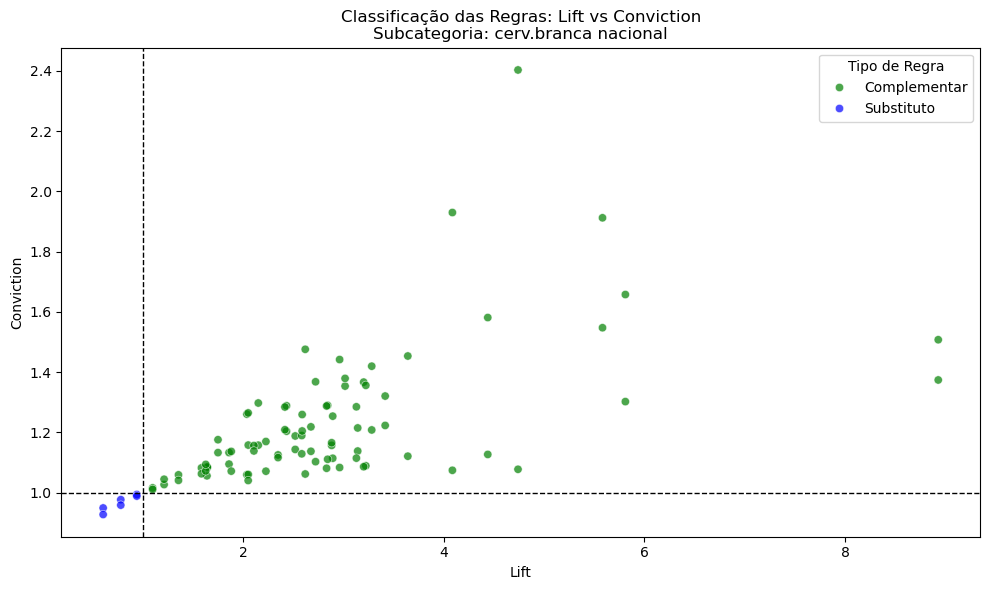

In [69]:
# Executar Apriori + Regras
rules = run_apriori(df_clean, selected_subcategory, min_support=0.012, min_confidence=0.01)

# Se houver regras, fazer gráfico
if not rules.empty:
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules['tipo_regra'] = rules.apply(classificar_regra, axis=1)
    
    # Gráfico de dispersão: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )

    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)

    plt.title(f'Classificação das Regras: Lift vs Conviction\nSubcategoria: {selected_subcategory}')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()

else:
    print(f"⚠️ Sem regras para subcategoria: {selected_subcategory}.")

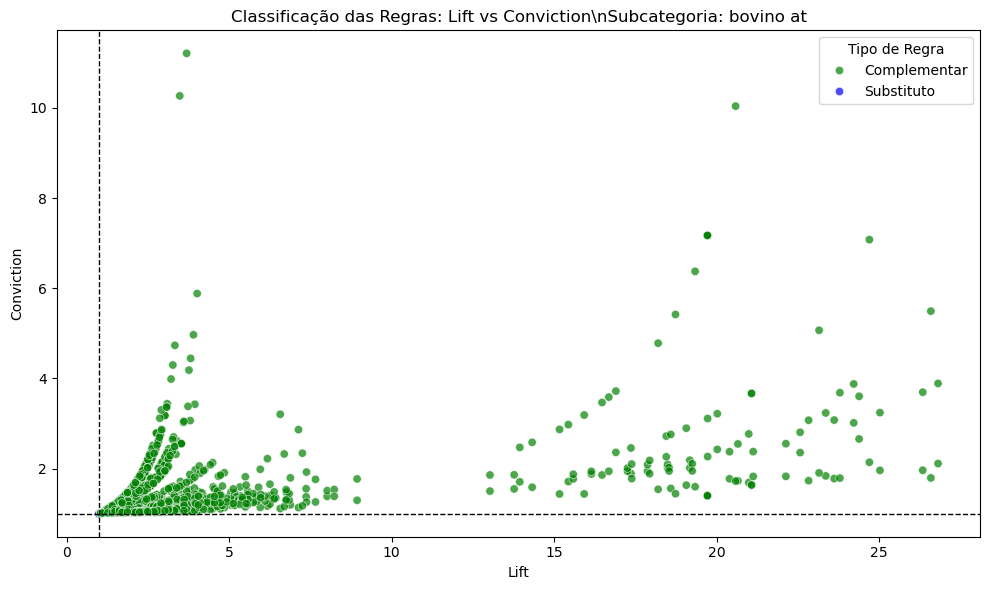

In [184]:
from mlxtend.frequent_patterns import apriori, association_rules

# Use already-prepared one-hot encoded DataFrame
frequent_itemsets_bovino_at = apriori(encoded_df_bovino_at, min_support=0.012, use_colnames=True)
rules_bovino_at = association_rules(frequent_itemsets_bovino_at, metric="confidence", min_threshold=0.01)
rules_bovino_at = rules_bovino_at[rules_bovino_at['antecedents'] != rules_bovino_at['consequents']]

if not rules_bovino_at.empty:
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_bovino_at['tipo_regra'] = rules_bovino_at.apply(classificar_regra, axis=1)

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_bovino_at,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\\nSubcategoria: bovino at')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: bovino at.")


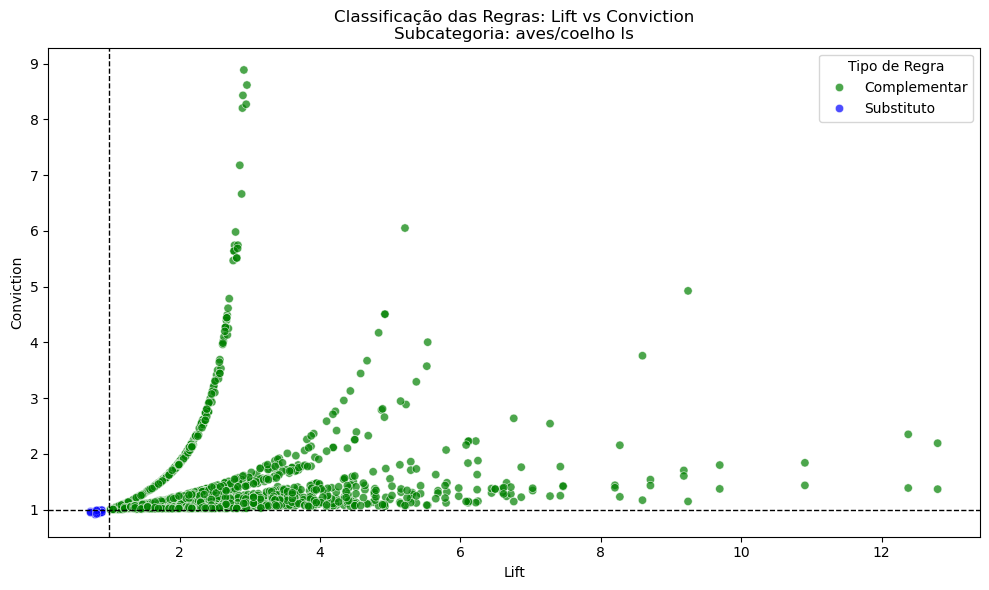

In [186]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for aves/coelho ls
frequent_itemsets_aves_coelho_ls = apriori(encoded_df_aves_coelho_ls, min_support=0.012, use_colnames=True)
rules_aves_coelho_ls = association_rules(frequent_itemsets_aves_coelho_ls, metric="confidence", min_threshold=0.01)
rules_aves_coelho_ls = rules_aves_coelho_ls[rules_aves_coelho_ls['antecedents'] != rules_aves_coelho_ls['consequents']]

# Check if there are any rules
if not rules_aves_coelho_ls.empty:
    
    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_aves_coelho_ls['tipo_regra'] = rules_aves_coelho_ls.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_aves_coelho_ls,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: aves/coelho ls')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: aves/coelho ls.")


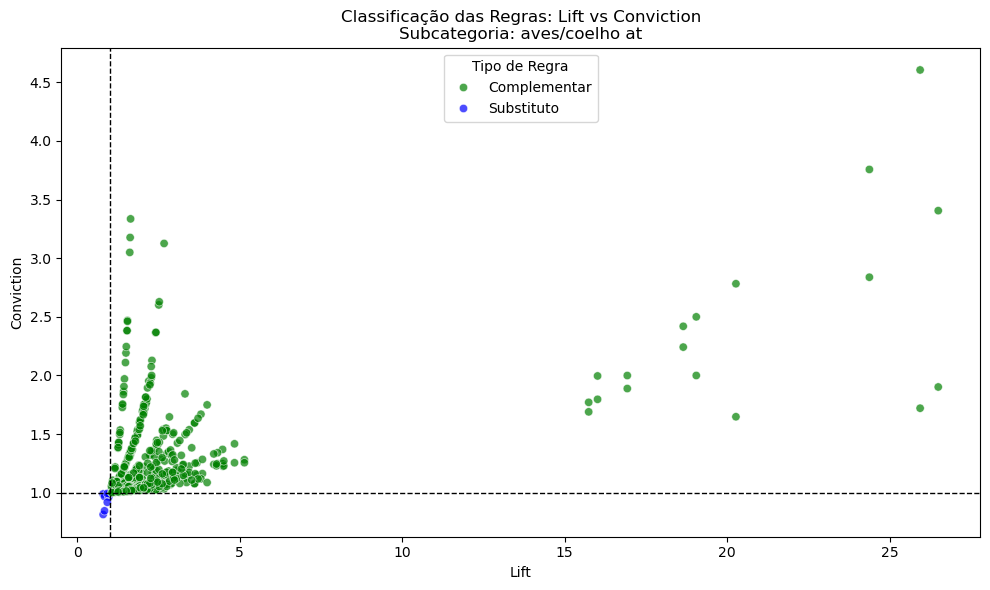

In [188]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for aves/coelho at
frequent_itemsets_aves_coelho_at = apriori(encoded_df_aves_coelho_at, min_support=0.012, use_colnames=True)
rules_aves_coelho_at = association_rules(frequent_itemsets_aves_coelho_at, metric="confidence", min_threshold=0.01)
rules_aves_coelho_at = rules_aves_coelho_at[rules_aves_coelho_at['antecedents'] != rules_aves_coelho_at['consequents']]

# Check if there are any rules
if not rules_aves_coelho_at.empty:
    
    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_aves_coelho_at['tipo_regra'] = rules_aves_coelho_at.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_aves_coelho_at,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: aves/coelho at')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: aves/coelho at.")


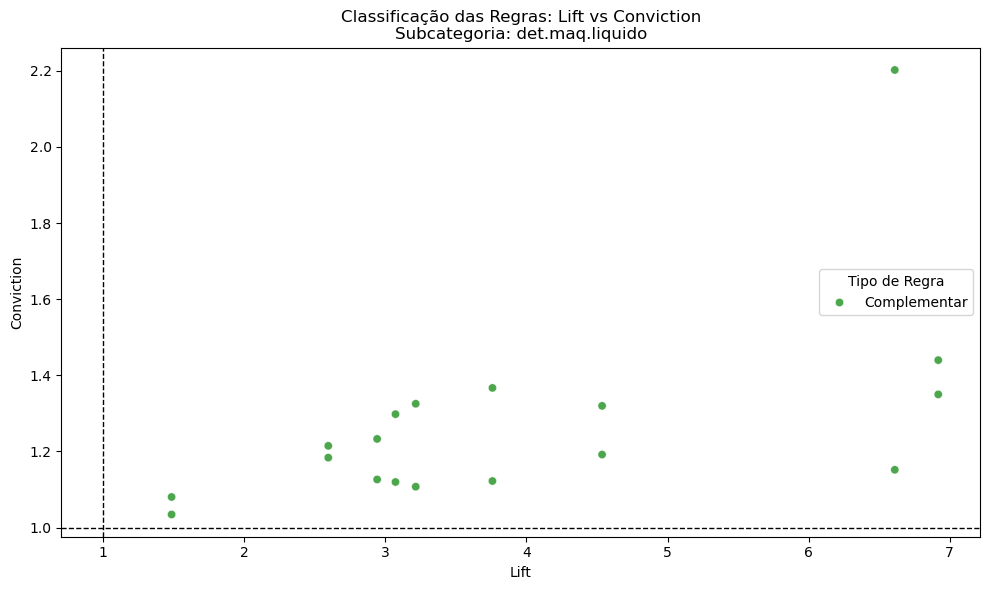

In [192]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for det.maq.liquido
frequent_itemsets_detmaqliquido = apriori(encoded_df_detmaqliquido, min_support=0.012, use_colnames=True)
rules_detmaqliquido = association_rules(frequent_itemsets_detmaqliquido, metric="confidence", min_threshold=0.01)
rules_detmaqliquido = rules_detmaqliquido[rules_detmaqliquido['antecedents'] != rules_detmaqliquido['consequents']]

# Check if rules exist
if not rules_detmaqliquido.empty:
    
    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_detmaqliquido['tipo_regra'] = rules_detmaqliquido.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_detmaqliquido,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: det.maq.liquido')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: det.maq.liquido.")


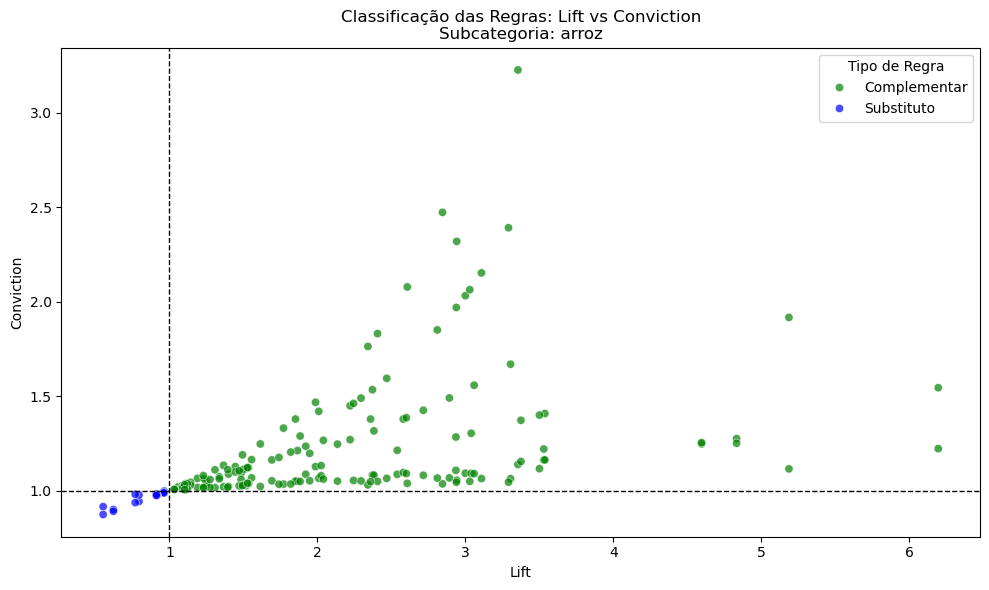

In [194]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for arroz
frequent_itemsets_arroz = apriori(encoded_df_arroz, min_support=0.012, use_colnames=True)
rules_arroz = association_rules(frequent_itemsets_arroz, metric="confidence", min_threshold=0.01)
rules_arroz = rules_arroz[rules_arroz['antecedents'] != rules_arroz['consequents']]

# Check if rules exist
if not rules_arroz.empty:

    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_arroz['tipo_regra'] = rules_arroz.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_arroz,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: arroz')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: arroz.")


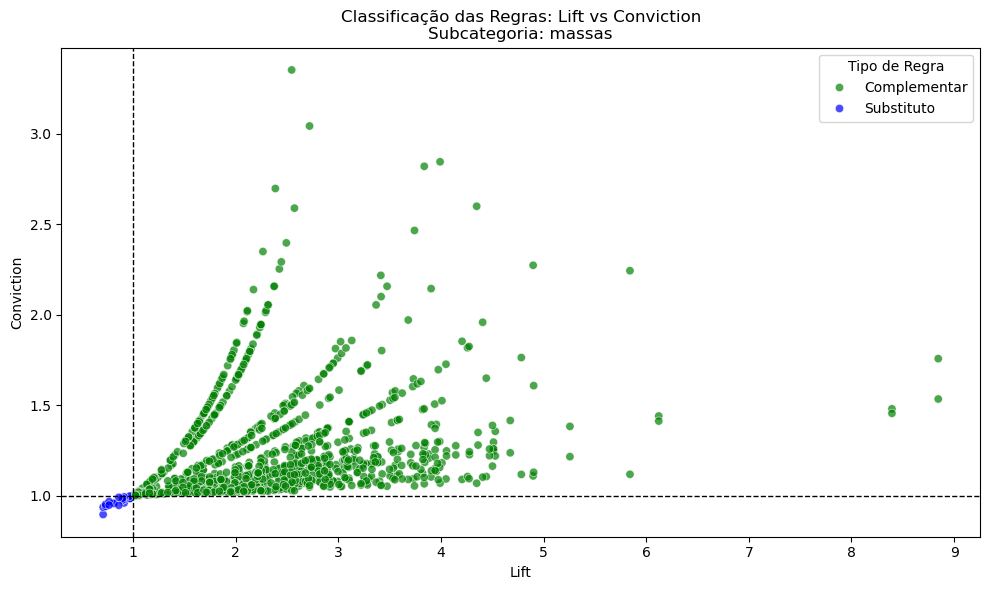

In [196]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for massas
frequent_itemsets_massas = apriori(encoded_df_massas, min_support=0.012, use_colnames=True)
rules_massas = association_rules(frequent_itemsets_massas, metric="confidence", min_threshold=0.01)
rules_massas = rules_massas[rules_massas['antecedents'] != rules_massas['consequents']]

# Check if rules exist
if not rules_massas.empty:

    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_massas['tipo_regra'] = rules_massas.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_massas,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: massas')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: massas.")


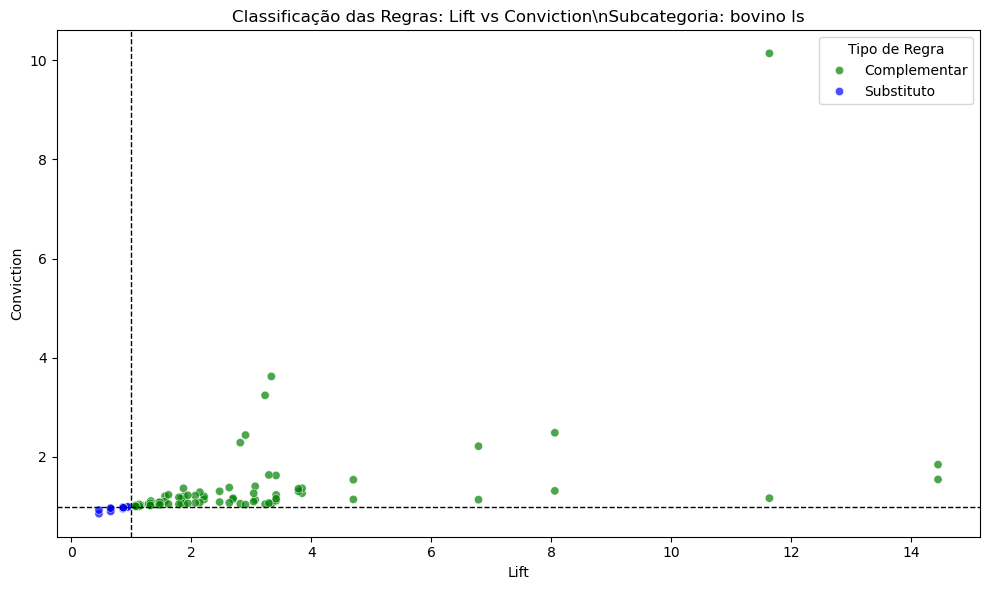

In [198]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for bovino ls
frequent_itemsets_bovino_ls = apriori(encoded_df_bovino_ls, min_support=0.012, use_colnames=True)
rules_bovino_ls = association_rules(frequent_itemsets_bovino_ls, metric="confidence", min_threshold=0.01)
rules_bovino_ls = rules_bovino_ls[rules_bovino_ls['antecedents'] != rules_bovino_ls['consequents']]

# Check if rules exist
if not rules_bovino_ls.empty:

    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_bovino_ls['tipo_regra'] = rules_bovino_ls.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_bovino_ls,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\\nSubcategoria: bovino ls')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: bovino ls.")


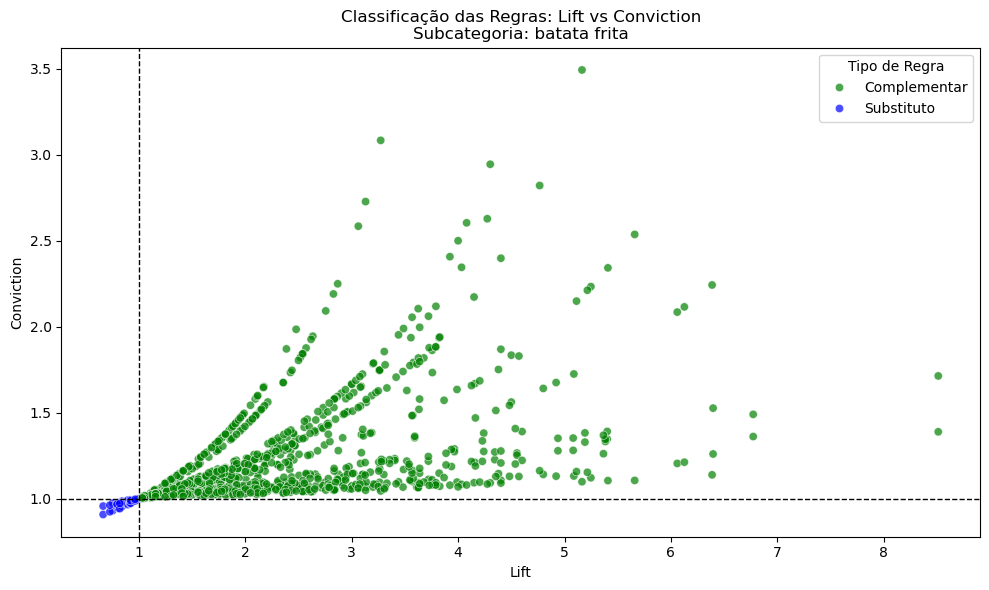

In [200]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for batata frita
frequent_itemsets_batata_frita = apriori(encoded_df_batata_frita, min_support=0.012, use_colnames=True)
rules_batata_frita = association_rules(frequent_itemsets_batata_frita, metric="confidence", min_threshold=0.01)
rules_batata_frita = rules_batata_frita[rules_batata_frita['antecedents'] != rules_batata_frita['consequents']]

# Check if rules exist
if not rules_batata_frita.empty:

    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_batata_frita['tipo_regra'] = rules_batata_frita.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_batata_frita,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: batata frita')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: batata frita.")


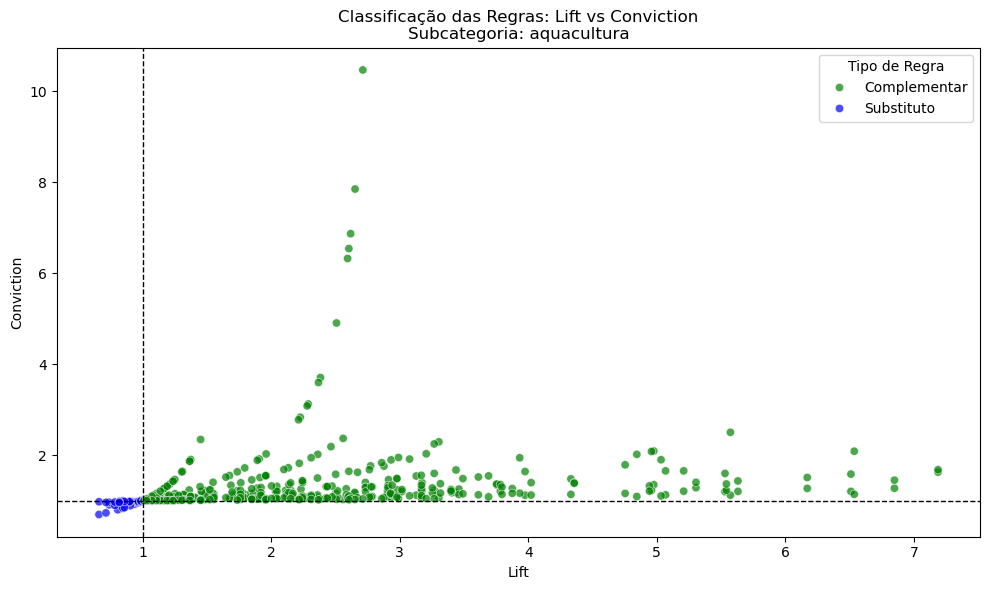

In [202]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# Apriori on encoded basket for aquacultura
frequent_itemsets_aquacultura = apriori(encoded_df_aquacultura, min_support=0.012, use_colnames=True)
rules_aquacultura = association_rules(frequent_itemsets_aquacultura, metric="confidence", min_threshold=0.01)
rules_aquacultura = rules_aquacultura[rules_aquacultura['antecedents'] != rules_aquacultura['consequents']]

# Check if rules exist
if not rules_aquacultura.empty:

    # Classify rule types
    def classificar_regra(row):
        if row['lift'] < 1:
            return 'Substituto'
        elif row['lift'] > 1:
            return 'Complementar'
        else:
            return 'Outro'

    rules_aquacultura['tipo_regra'] = rules_aquacultura.apply(classificar_regra, axis=1)

    # Plot: Lift vs Conviction
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=rules_aquacultura,
        x='lift',
        y='conviction',
        hue='tipo_regra',
        palette={'Substituto': 'blue', 'Complementar': 'green', 'Outro': 'gray'},
        alpha=0.7
    )
    plt.axvline(1, color='black', linestyle='--', linewidth=1)
    plt.axhline(1, color='black', linestyle='--', linewidth=1)
    plt.title('Classificação das Regras: Lift vs Conviction\nSubcategoria: aquacultura')
    plt.xlabel('Lift')
    plt.ylabel('Conviction')
    plt.legend(title='Tipo de Regra')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Sem regras para subcategoria: aquacultura.")


### Another way to analyse min support and confidence values

In [71]:
def run_apriori2(df, subcategory_name, support_values=[0.012, 0.02, 0.03], confidence_values=[0.01, 0.1, 0.15]):
    all_results = {}

    print(f"{'#'*70}")
    print(f"Run Apriori for Subcategory: {subcategory_name}")
    
    for min_support in support_values:
        print(f"\n{'='*60}")
        for min_confidence in confidence_values:
            print(f"[{subcategory_name}] Trying min_support={min_support}, min_confidence={min_confidence} ...")
            frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
            rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
            rules = rules[rules['antecedents'] != rules['consequents']]
            print(f"Found {len(frequent_itemsets)} frequent itemsets and {len(rules)} rules.")
            key = f"support={min_support}_confidence={min_confidence}"
            all_results[key] = {
                'frequent_itemsets': frequent_itemsets,
                'rules': rules
            }
    return all_results

all_rules = run_apriori2(encoded_df, subcategory_name=selected_subcategory)

######################################################################
Run Apriori for Subcategory: cerv.branca nacional

[cerv.branca nacional] Trying min_support=0.012, min_confidence=0.01 ...
Found 78 frequent itemsets and 94 rules.
[cerv.branca nacional] Trying min_support=0.012, min_confidence=0.1 ...
Found 78 frequent itemsets and 87 rules.
[cerv.branca nacional] Trying min_support=0.012, min_confidence=0.15 ...
Found 78 frequent itemsets and 65 rules.

[cerv.branca nacional] Trying min_support=0.02, min_confidence=0.01 ...
Found 41 frequent itemsets and 26 rules.
[cerv.branca nacional] Trying min_support=0.02, min_confidence=0.1 ...
Found 41 frequent itemsets and 26 rules.
[cerv.branca nacional] Trying min_support=0.02, min_confidence=0.15 ...
Found 41 frequent itemsets and 25 rules.

[cerv.branca nacional] Trying min_support=0.03, min_confidence=0.01 ...
Found 28 frequent itemsets and 12 rules.
[cerv.branca nacional] Trying min_support=0.03, min_confidence=0.1 ...
Found 28 freq

## 4. Visualization
* We first used lift and conviction to rank possible substitutes. 
* An then created visual graphics to analyse brand, size substitution.
    * Scatter plot - confidence vs Lift
    * Heatmap - brand switching %
    * Histogram - price difference %
    * Heatmap - unit size switching %
    * Heatmap - frequency of substitutes per original products
    * Bar + Line plot - top 10 substitues (frequency vs Lift)
    * Horizontal barplot - lift vs Original produtc
    * Network graph - graph of product substitutions (lift + confidence)


✅ Running Apriori per subcategory allows for more interpretable substitute patterns.  
✅ Selecting subcategories by revenue is practical — focus on high impact areas.

**Interpreting lift < 1:**  
- Since lift is symmetric, product A → B and B → A both appear.  
- A low lift indicates products are NOT bought together → substitution possible.

**Brand switching analysis:**  
- Countplot shows how frequently brand changes occur in substitute rules.

**Price change patterns:**  
- Scatterplot reveals if customers switch to cheaper or more expensive products when substituting.

**Recommendations:**  
- Focus stock-out substitution on *high-revenue subcategories*.  
- Use price filtering (±20%) to recommend "natural" substitutes.  
- Consider brand affinity → if brand switching is low, stay within brand.

**Next improvements:**  
- Incorporate temporal effects (seasonality).  
- Use additional customer segmentation (loyal vs opportunistic buyers).

######################################################################
Run Apriori for Subcategory: cerv.branca nacional

[cerv.branca nacional] Trying min_support=0.001, min_confidence=0.004 ...
Found 1837 frequent itemsets and 16770 rules before filtering.
Found 403 rules after filtering lift < 1 e conviction entre 0.95 e 1.05.


antecedent_product                   consequent_product  \
2   CERV C/ ALC SUPER BOCK TP 30X25CL         CERV C/ALC CRISTAL TP 6X25CL   
3        CERV C/ALC CRISTAL TP 6X25CL    CERV C/ ALC SUPER BOCK TP 30X25CL   
4   CERV C/ ALC SUPER BOCK TP 30X25CL         CERV C/ALC LATA GUTBIER 50CL   
8   CERV C/ ALC SUPER BOCK TP 30X25CL         CERV C/ALC SAGRES BR 15X25CL   
10  CERV C/ ALC SUPER BOCK TP 30X25CL      CERV C/ALC SAGRES BR TP 24X25CL   
11    CERV C/ALC SAGRES BR TP 24X25CL    CERV C/ ALC SUPER BOCK TP 30X25CL   
12  CERV C/ ALC SUPER BOCK TP 30X25CL      CERV C/ALC SAGRES BRANCA 6X25CL   
14  CERV C/ ALC SUPER BOCK TP 30X25CL  CERV C/ALC SAGRES BRANCA TP 10X25CL   
24  CERV C/ ALC SUPER BOCK TP 30X25CL      CERV. C/ALC. LATA CRISTAL 33 CL   
26  CERV C/ ALC SUPER BOCK TP 30X25CL     CERV. C/ALC. LATA GUTBIER 6*33CL   

   antecedent_brand consequent_brand  antecedent_price  consequent_price  \
2        SUPER BOCK          CRISTAL             13.08              2.27   
3           CRISTAL       SUPER BOCK              2.27             13.08   
4        SUPER BOCK          GUTBIER             13.08              0.56   
8        SUPER BOCK           SAGRES             13.08              6.09   
10       SUPER BOCK           SAGRES             13.08              8.85   
11           SAGRES       SUPER BOCK              8.85             13.08   
12       SUPER BOCK           SAGRES             13.08              3.04   
14       SUPER BOCK           SAGRES             13.08              4.54   
24       SUPER BOCK          CRISTAL             13.08              0.40   
26       SUPER BOCK          GUTBIER             13.08              1.78   

    price_diff_pct   support  confidence      lift  conviction  
2       -82.645260  0.001508    0.009091  0.861039    0.998519  
3       476.211454  0.001508    0.142857  0.861039    0.973102  
4       -95.718654  0.001508    0.009091  0.273967    0.975687  
8       -53.440367  0.008296    0.050000  0.656436    0.972454  
10      -32.339450  0.006033    0.036364  0.790462    0.989997  
11       47.796610  0.006033    0.131148  0.790462    0.959987  
12      -76.758410  0.003771    0.022727  0.424456    0.968466  
14      -65.290520  0.001508    0.009091  0.547934    0.992431  
24      -96.941896  0.001508    0.009091  0.574026    0.993192  
26      -86.391437  0.005279    0.031818  0.781313    0.990802

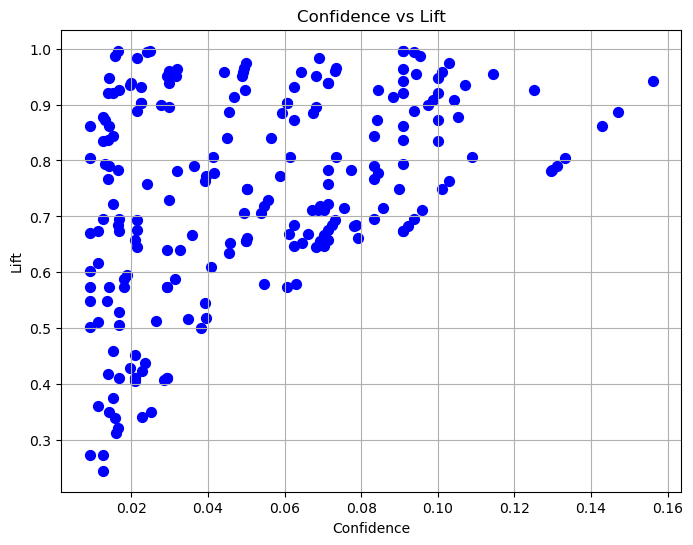

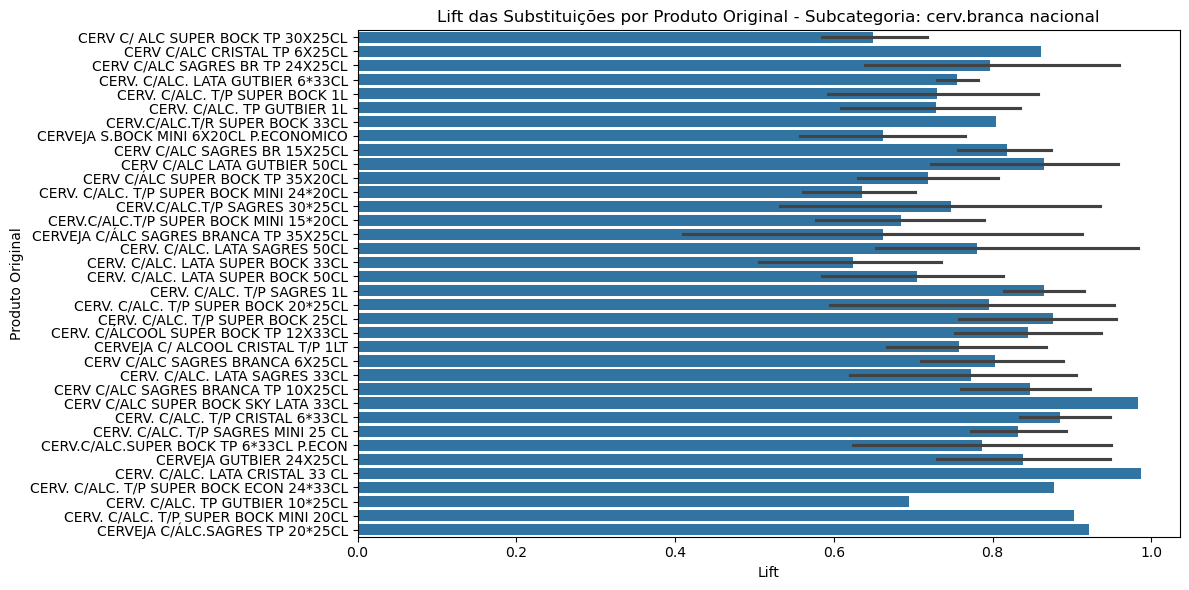

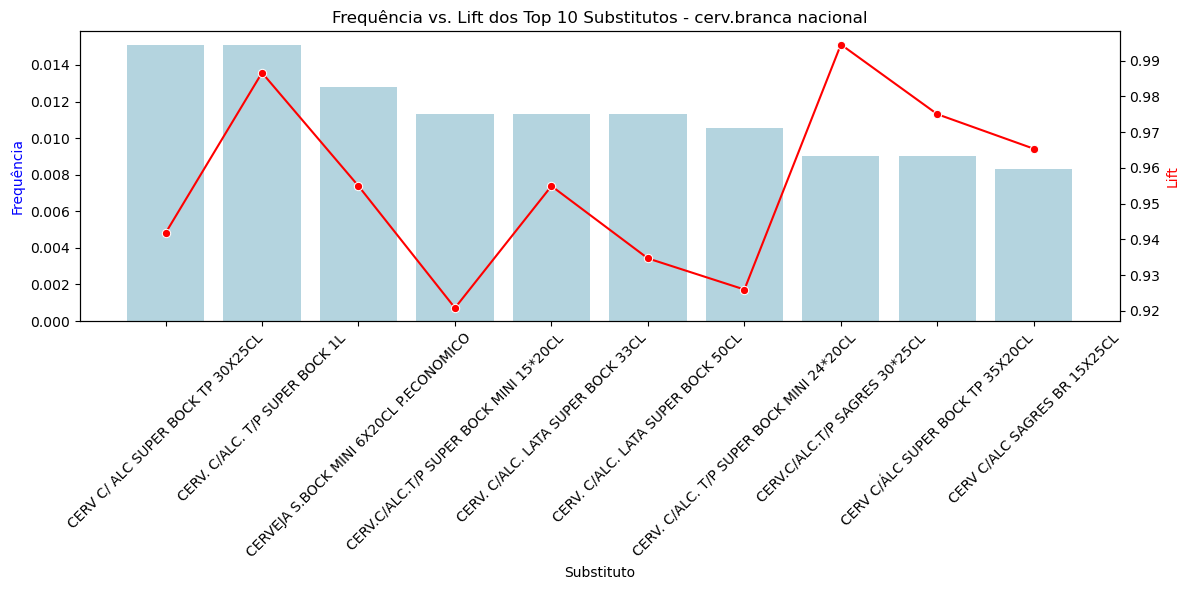

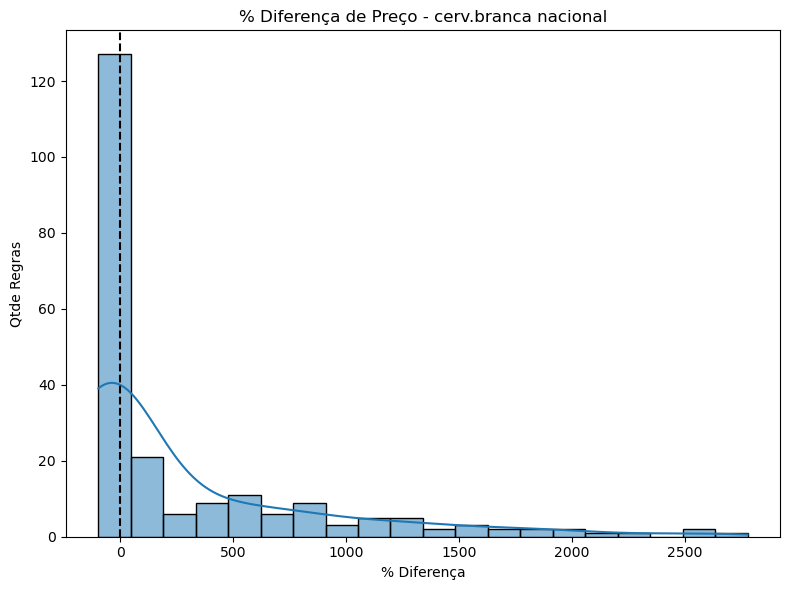

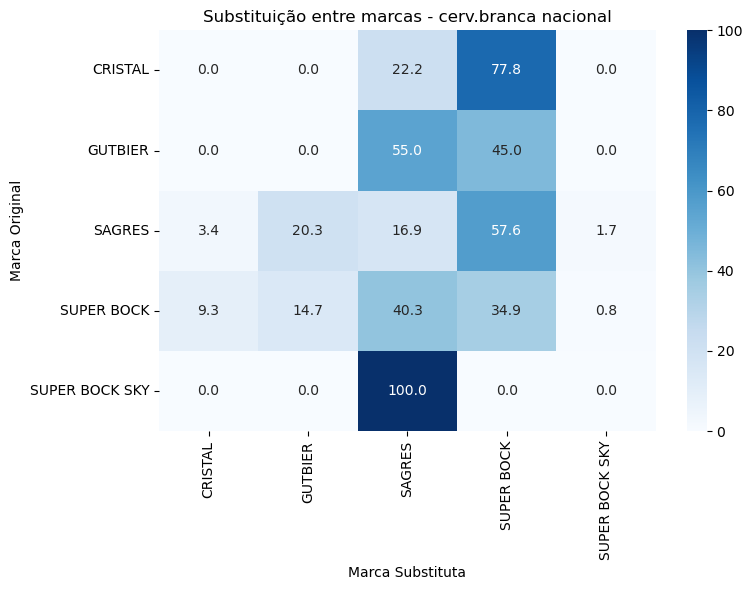

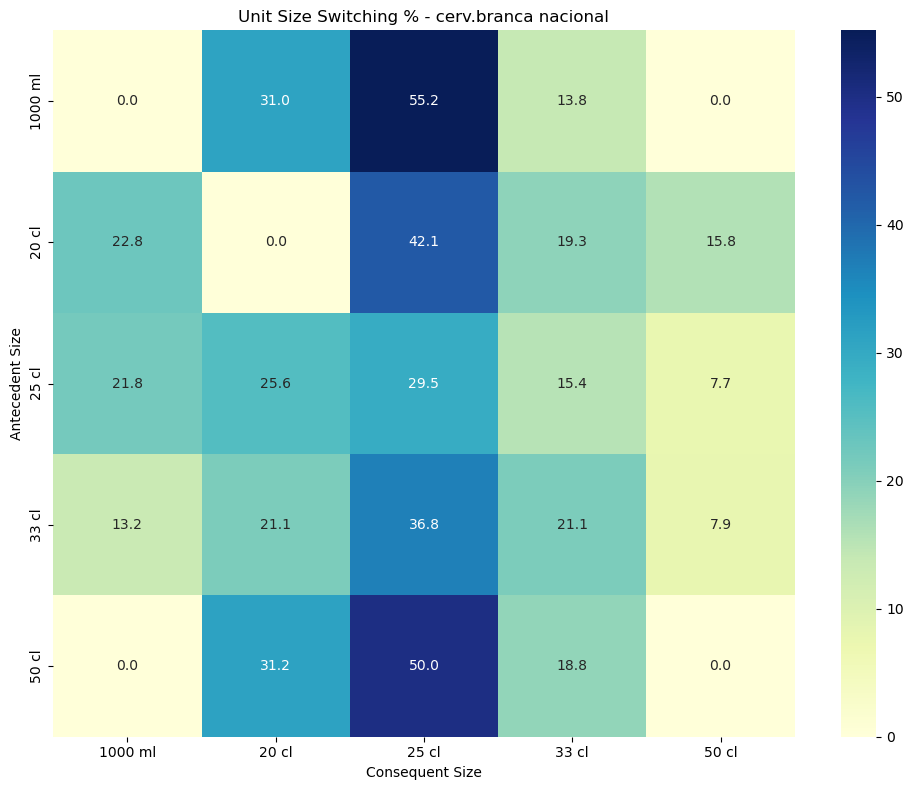

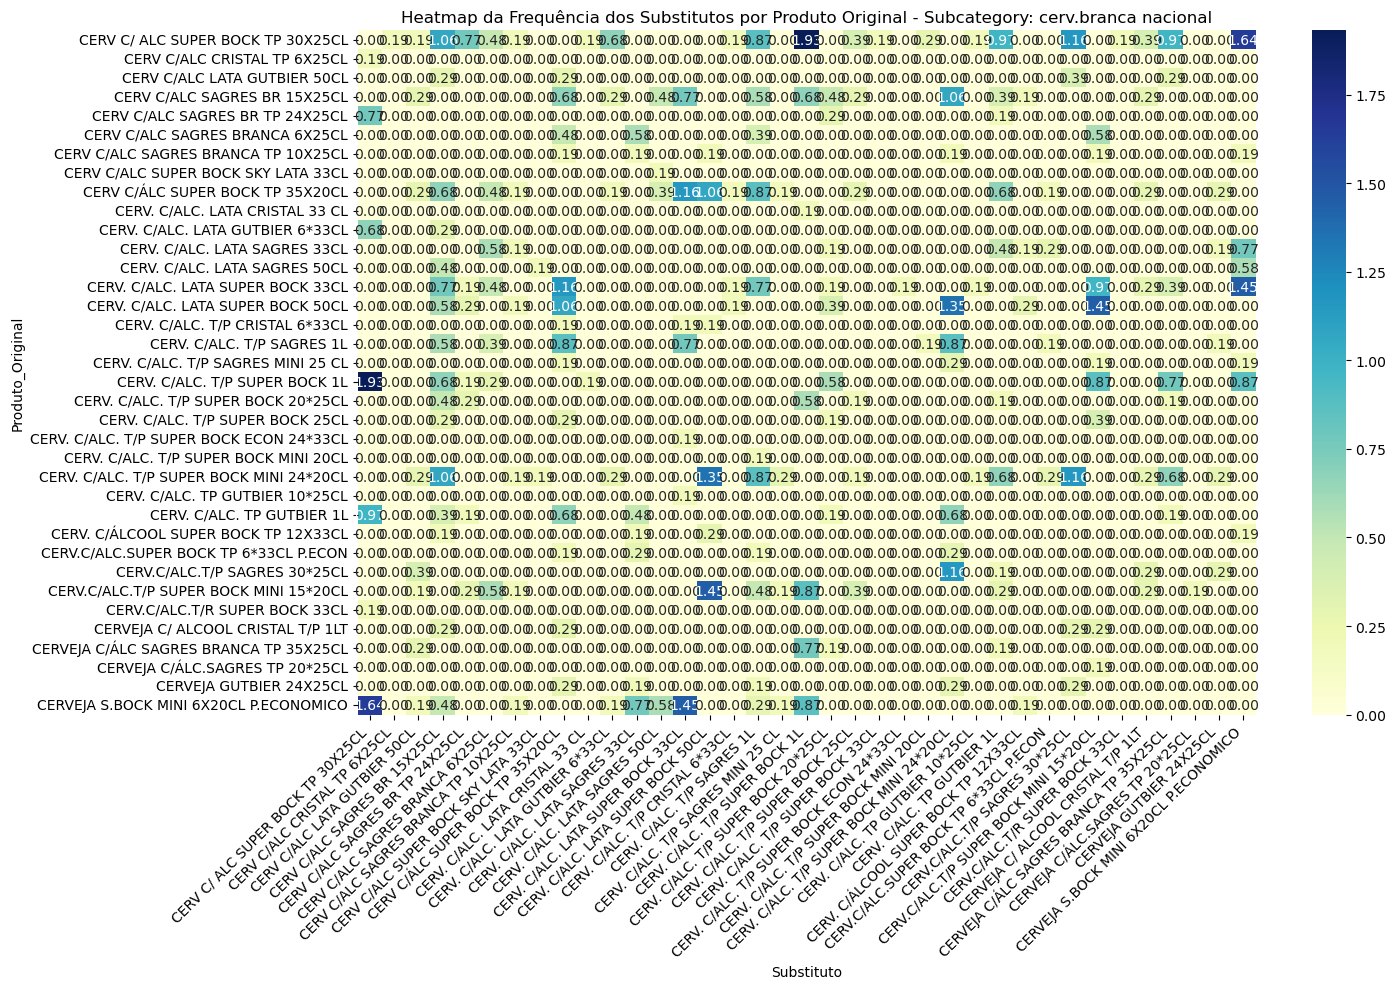

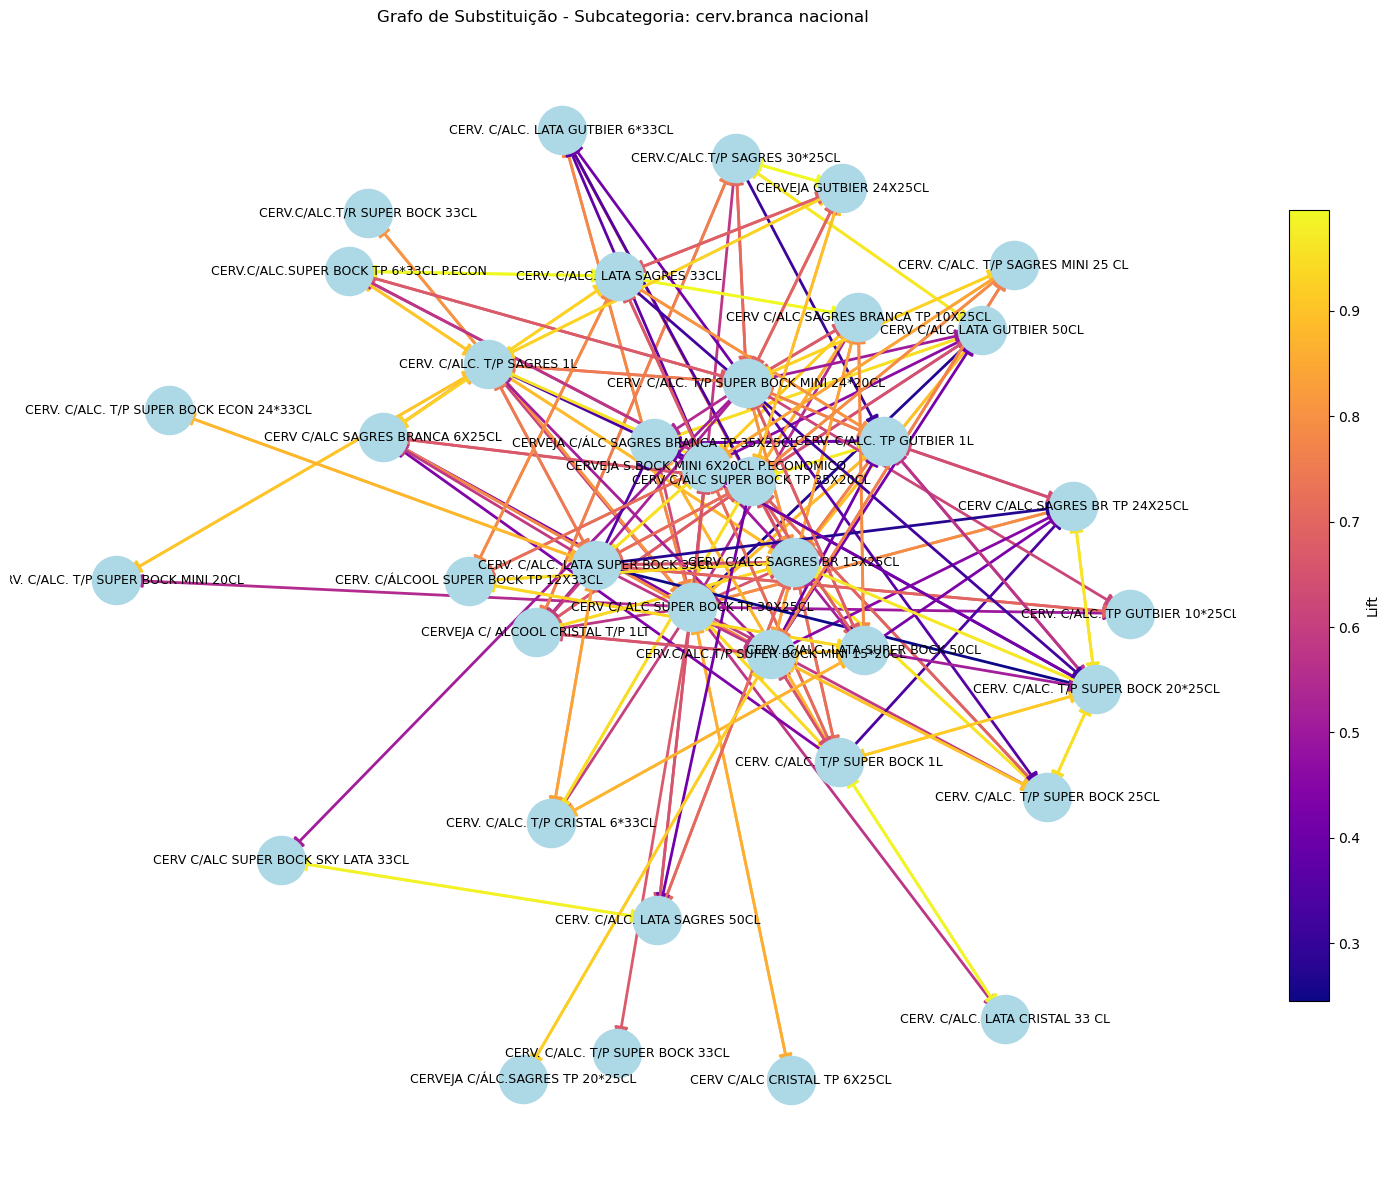

In [73]:
def run_apriori3(df, subcategory_name, support_values=[0.001], confidence_values=[0.004]):
    all_results = {}

    print(f"{'#'*70}")
    print(f"Run Apriori for Subcategory: {subcategory_name}")
    
    for min_support in support_values:
        print(f"\n{'='*60}")
        for min_confidence in confidence_values:
            print(f"[{subcategory_name}] Trying min_support={min_support}, min_confidence={min_confidence} ...")
            frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
            rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=min_confidence)
            rules = rules[rules['antecedents'] != rules['consequents']]
            print(f"Found {len(frequent_itemsets)} frequent itemsets and {len(rules)} rules before filtering.")
            
            # Aplicar filtro adicional com lift < 1 e conviction entre 0.95 e 1.05
            rules = rules[(rules['lift'] < 1) & (rules['conviction'].between(0.95, 1.05))].copy()
            print(f"Found {len(rules)} rules after filtering lift < 1 e conviction entre 0.95 e 1.05.")

            # Enriquecer as regras com as colunas de interesse
            
            subs_rules = rules.copy()
            
            # Maps
            brand_map = df_clean.set_index('product_dsc')['brand_dsc'].to_dict()
            price_map = df_clean.set_index('product_dsc')['unit_price'].to_dict()
            size_value_map = df_clean.set_index('product_dsc')['unit_size_ml_or_g'].to_dict()
            size_label_map = df_clean.set_index('product_dsc')['unit_size_label'].to_dict()
            
            # Adicionar colunas
            subs_rules['antecedent_brand'] = subs_rules['antecedents'].apply(lambda x: ', '.join([brand_map.get(i, 'Unknown Brand') for i in list(x)]))
            subs_rules['consequent_brand'] = subs_rules['consequents'].apply(lambda x: ', '.join([brand_map.get(i, 'Unknown Brand') for i in list(x)]))

            subs_rules['antecedent_price'] = subs_rules['antecedents'].apply(lambda x: np.mean([price_map.get(i, np.nan) for i in list(x)]))
            subs_rules['consequent_price'] = subs_rules['consequents'].apply(lambda x: np.mean([price_map.get(i, np.nan) for i in list(x)]))

            subs_rules['antecedent_size'] = subs_rules['antecedents'].apply(lambda x: np.mean([size_value_map.get(i, np.nan) for i in list(x)]))
            subs_rules['consequent_size'] = subs_rules['consequents'].apply(lambda x: np.mean([size_value_map.get(i, np.nan) for i in list(x)]))

            # Subset de regras simples
            subs_rules_simple = subs_rules[(subs_rules['antecedents'].apply(lambda x: len(x) == 1)) &
                                           (subs_rules['consequents'].apply(lambda x: len(x) == 1))].copy()

            # Diferença percentual de preço
            subs_rules_simple['price_diff_pct'] = ((subs_rules_simple['consequent_price'] - subs_rules_simple['antecedent_price'])
                                                   / subs_rules_simple['antecedent_price']) * 100

            # Labels de tamanho
            subs_rules_simple['antecedent_size_label'] = subs_rules_simple['antecedents'].apply(lambda x: ', '.join([size_label_map.get(i, 'Unknown Size') for i in list(x)]))
            subs_rules_simple['consequent_size_label'] = subs_rules_simple['consequents'].apply(lambda x: ', '.join([size_label_map.get(i, 'Unknown Size') for i in list(x)]))

            # Adicionar colunas para os gráficos
            subs_rules['antecedent_product'] = subs_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
            subs_rules['consequent_product'] = subs_rules['consequents'].apply(lambda x: ', '.join(list(x)))

            subs_rules_simple['antecedent_product'] = subs_rules_simple['antecedents'].apply(lambda x: ', '.join(list(x)))
            subs_rules_simple['consequent_product'] = subs_rules_simple['consequents'].apply(lambda x: ', '.join(list(x)))
            
            # Mostrar tabela ordenada por lift
            if not subs_rules.empty:
                subs_rules = subs_rules.sort_values(by='lift', ascending=False)
                display(subs_rules_simple[['antecedent_product', 'consequent_product', 'antecedent_brand', 'consequent_brand',
                                    'antecedent_price', 'consequent_price', 'price_diff_pct',
                                    'support', 'confidence', 'lift', 'conviction']].head(10))
            
                # Visualizations 
                
                # Confidence vs Lift
                plt.figure(figsize=(8, 6))
                plt.scatter(subs_rules_simple['confidence'], subs_rules_simple['lift'], color='blue', s=50)
                plt.title("Confidence vs Lift")
                plt.xlabel("Confidence")
                plt.ylabel("Lift")
                plt.grid(True)
                plt.show()


                # Lift por Produto Original
                df_substituicoes = subs_rules_simple[['antecedent_product', 'lift']].copy()
                df_substituicoes.rename(columns={
                    'antecedent_product': 'Produto_Original',
                    'lift': 'Lift'
                }, inplace=True)
                
                plt.figure(figsize=(12, 6))
                sns.barplot(x='Lift', y='Produto_Original', data=df_substituicoes, orient='h')
                plt.title(f'Lift das Substituições por Produto Original - Subcategoria: {subcategory_name}')
                plt.xlabel('Lift')
                plt.ylabel('Produto Original')
                plt.tight_layout()
                plt.show()



                # Top 10 substitutos por frequência + lift
                rules_freq = subs_rules_simple[['antecedent_product', 'consequent_product', 'support', 'lift']].copy()
                rules_freq.rename(columns={
                    'antecedent_product': 'Produto_Original',
                    'consequent_product': 'Substituto',
                    'support': 'Frequência',
                    'lift': 'Lift'
                }, inplace=True)

                top10 = rules_freq.groupby('Substituto').agg({
                    'Frequência': 'max',
                    'Lift': 'max'
                }).reset_index().sort_values(by='Frequência', ascending=False).head(10)
            
                fig, ax1 = plt.subplots(figsize=(12,6))
                sns.barplot(x='Substituto', y='Frequência', data=top10, ax=ax1, color='lightblue')
                ax1.set_ylabel('Frequência', color='blue')
                ax1.tick_params(axis='x', rotation=45)
            
                ax2 = ax1.twinx()
                sns.lineplot(x='Substituto', y='Lift', data=top10, ax=ax2, color='red', marker='o')
                ax2.set_ylabel('Lift', color='red')
            
                plt.title(f"Frequência vs. Lift dos Top 10 Substitutos - {subcategory_name}")
                plt.tight_layout()
                plt.show()


                # Histograma % diferença de preço
                plt.figure(figsize=(8,6))
                sns.histplot(subs_rules_simple['price_diff_pct'], bins=20, kde=True)
                plt.title(f'% Diferença de Preço - {subcategory_name}')
                plt.xlabel('% Diferença')
                plt.ylabel('Qtde Regras')
                plt.axvline(0, color='black', linestyle='--')
                plt.tight_layout()
                plt.show()                


                # Brand Switching Heatmap
                brand_matrix = subs_rules_simple.groupby(['antecedent_brand', 'consequent_brand']).size().unstack().fillna(0)
                brand_pct = brand_matrix.div(brand_matrix.sum(axis=1), axis=0) * 100
                plt.figure(figsize=(8,6))
                sns.heatmap(brand_pct, annot=True, fmt=".1f", cmap="Blues")
                plt.title(f'Substituição entre marcas - {subcategory_name}')
                plt.xlabel('Marca Substituta')
                plt.ylabel('Marca Original')
                plt.tight_layout()
                plt.show()


                # Heatmap de unit size switching
                size_switch_matrix = subs_rules_simple.groupby(['antecedent_size_label', 'consequent_size_label']).size().unstack().fillna(0)
                size_switch_pct = size_switch_matrix.div(size_switch_matrix.sum(axis=1), axis=0) * 100
                
                plt.figure(figsize=(10,8))
                sns.heatmap(size_switch_pct, annot=True, fmt=".1f", cmap="YlGnBu")
                plt.title(f'Unit Size Switching % - {subcategory_name}')
                plt.xlabel('Consequent Size')
                plt.ylabel('Antecedent Size')
                plt.tight_layout()
                plt.show()
        
        
                # Pivot table para heatmap
                #Calcular percentual
                total_freq = rules_freq['Frequência'].sum()
                rules_freq['Frequência_pct'] = 100 * rules_freq['Frequência'] / total_freq
                
                # Pivot table para heatmap
                pivot_freq_pct = rules_freq.pivot_table(
                    index='Produto_Original',
                    columns='Substituto',
                    values='Frequência_pct',
                    fill_value=0
                )
                
                # Plot do heatmap
                plt.figure(figsize=(15,10))
                sns.heatmap(pivot_freq_pct, annot=True, fmt='.2f', cmap='YlGnBu')
                plt.title(f'Heatmap da Frequência dos Substitutos por Produto Original - Subcategory: {subcategory_name}')
                plt.xticks(rotation=45, ha='right')
                plt.yticks(rotation=0)
                plt.tight_layout()
                plt.show()



                # Grafo de substituições
                df_grafo = subs_rules_simple[['antecedent_product', 'consequent_product', 'lift', 'confidence']].copy()
                df_grafo.rename(columns={
                    'antecedent_product': 'Produto_Original',
                    'consequent_product': 'Substituto',
                    'lift': 'Lift',
                    'confidence': 'Confiança'
                }, inplace=True)
            
                G = nx.DiGraph()
                for _, row in df_grafo.iterrows():
                    G.add_edge(row['Produto_Original'], row['Substituto'], weight=row['Lift'], confidence=row['Confiança'])
            
                plt.figure(figsize=(14, 12))
                pos = nx.spring_layout(G, k=1, seed=30)
            
                nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='lightblue')
                weights = [edata['weight'] for _, _, edata in G.edges(data=True)]
                min_w, max_w = min(weights), max(weights)
                colors = plt.cm.plasma([(w - min_w) / (max_w - min_w) for w in weights])
                nx.draw_networkx_edges(G, pos, edge_color=colors, width=2, arrows=True, arrowsize=20)
                nx.draw_networkx_labels(G, pos, font_size=9)
            
                sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=min_w, vmax=max_w))
                sm.set_array([])
                cbar = plt.colorbar(sm, ax=plt.gca(), fraction=0.03, pad=0.04)
                cbar.set_label('Lift')
            
                plt.title(f'Grafo de Substituição - Subcategoria: {subcategory_name}')
                plt.axis('off')
                plt.tight_layout()
                plt.show()
                
            
            else:
                print("⚠️ No rules to display.")

            # Salvar no dicionário de resultados
            key = f"support={min_support}_confidence={min_confidence}"
            all_results[key] = {
                'frequent_itemsets': frequent_itemsets,
                'rules': subs_rules,
                'rules_simple': subs_rules_simple
            }

            
    return all_results


all_rules = run_apriori3(encoded_df, subcategory_name=selected_subcategory)

In [207]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apriori for arroz
frequent_itemsets_arroz = apriori(encoded_df_arroz, min_support=0.03, use_colnames=True)
rules_arroz = association_rules(frequent_itemsets_arroz, metric="confidence", min_threshold=0.01)
rules_arroz = rules_arroz[rules_arroz['antecedents'] != rules_arroz['consequents']]

# Filter only substitute rules (lift < 1)
rules_arroz_substitute = rules_arroz[rules_arroz['lift'] < 1]

print("\nSubstitute Association Rules for arroz (Lift < 1)")
display(rules_arroz_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for arroz (Lift < 1)


antecedents                        consequents  \
11     (ARROZ BASMATI CONTINENTE 1KG)          (ARROZ AGULHA CIGALA 1KG)   
10          (ARROZ AGULHA CIGALA 1KG)     (ARROZ BASMATI CONTINENTE 1KG)   
28     (ARROZ BASMATI CONTINENTE 1KG)  (ARROZ VAPORIZADO CONTINENTE 1KG)   
29  (ARROZ VAPORIZADO CONTINENTE 1KG)     (ARROZ BASMATI CONTINENTE 1KG)   
16     (ARROZ BASMATI CONTINENTE 1KG)      (ARROZ AGULHA CONTINENTE 1KG)   
17      (ARROZ AGULHA CONTINENTE 1KG)     (ARROZ BASMATI CONTINENTE 1KG)   
12          (ARROZ AGULHA CIGALA 1KG)    (ARROZ CAROLINO CONTINENTE 1KG)   
13    (ARROZ CAROLINO CONTINENTE 1KG)          (ARROZ AGULHA CIGALA 1KG)   

     support  confidence      lift  
11  0.034359    0.151584  0.620984  
10  0.034359    0.140756  0.620984  
28  0.035385    0.156109  0.911412  
29  0.035385    0.206587  0.911412  
16  0.042051    0.185520  0.915860  
17  0.042051    0.207595  0.915860  
12  0.039487    0.161765  0.961711  
13  0.039487    0.234756  0.961711

In [ ]:
#business insight
# Overall:
# These rules suggest that customers are substituting between types of rice:
# - Agulha, Basmati, Carolino, Vaporizado are not typically bought together.
# - They likely serve similar culinary purposes and are interchangeable in the eyes of customers.
# Useful for stock-out substitution: if one is unavailable, recommend the others with lift < 1.


# Rule 11:
# If a customer buys ARROZ BASMATI CONTINENTE 1KG,
# there's a 15.2% chance they also buy ARROZ AGULHA CIGALA 1KG.
# Lift = 0.62 < 1 → These items are less likely to be bought together than by chance,
# suggesting they are substitutes (customers typically choose one or the other).

# Rule 10 (reverse direction):
# If a customer buys ARROZ AGULHA CIGALA 1KG,
# there's a 14.1% chance they also buy ARROZ BASMATI CONTINENTE 1KG.
# Lift is still 0.62 → reinforces the substitution relationship.

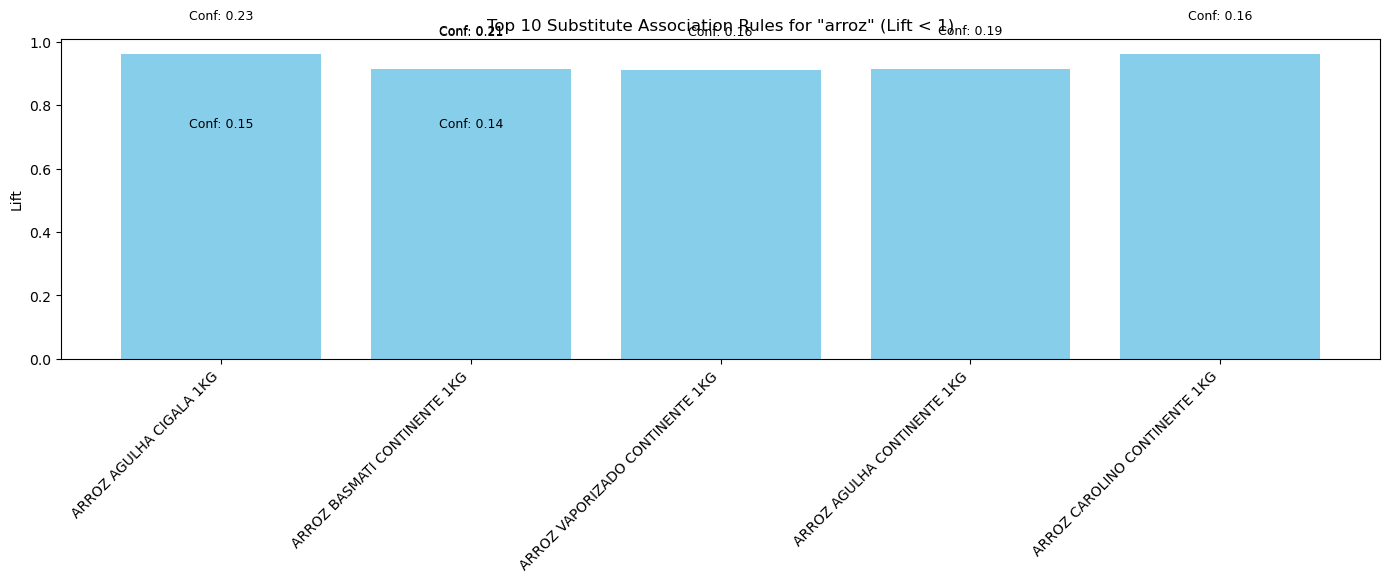

In [210]:
import matplotlib.pyplot as plt

# Top N substitute rules (e.g., top 10 with lowest lift)
top_subs = rules_arroz_substitute.sort_values(by='lift').head(10)

# X labels = consequents
x_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Bar plot: Lift vs Consequents
plt.figure(figsize=(14, 6))
bars = plt.bar(x_labels, top_subs['lift'], color='skyblue')

# Add confidence annotations above bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"Conf: {conf:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Lift')
plt.title('Top 10 Substitute Association Rules for "arroz" (Lift < 1)')
plt.tight_layout()
plt.show()


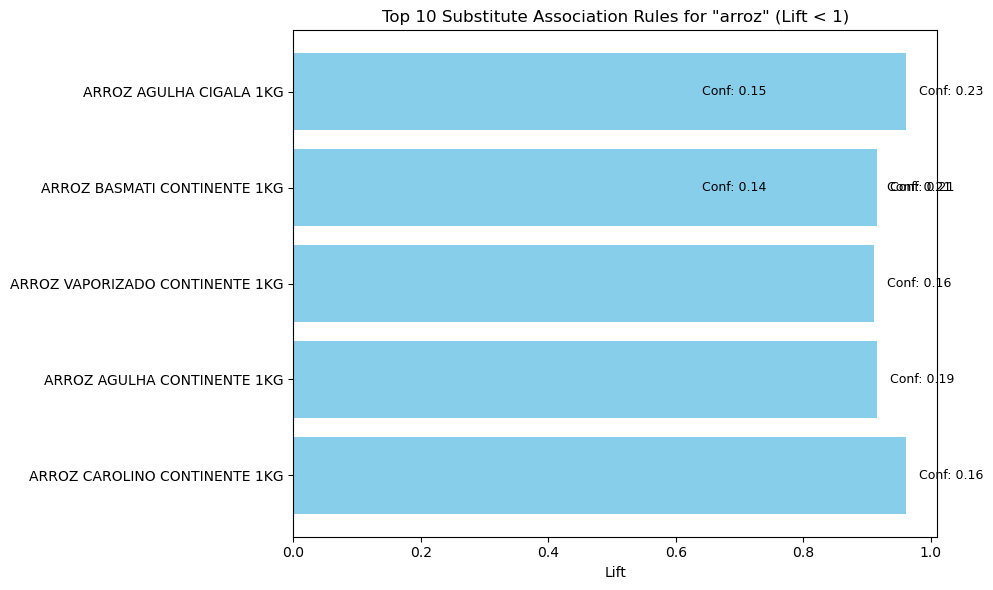

In [226]:
import matplotlib.pyplot as plt

# Top 10 substitute rules with lowest lift
top_subs = rules_arroz_substitute.sort_values(by='lift').head(10)

# Labels = consequents as text
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Bar plot: Lift vs Consequents (horizontal)
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values to the end of each bar
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "arroz" (Lift < 1)')
plt.gca().invert_yaxis()  # Highest lift at the top
plt.tight_layout()
plt.show()


In [222]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apriori for cerveja (cerv.branca nacional)
frequent_itemsets_cervbranca_nacional = apriori(encoded_df_cervbranca_nacional, min_support=0.01, use_colnames=True)
rules_cervbranca_nacional = association_rules(frequent_itemsets_cervbranca_nacional, metric="confidence", min_threshold=0.01)
rules_cervbranca_nacional = rules_cervbranca_nacional[rules_cervbranca_nacional['antecedents'] != rules_cervbranca_nacional['consequents']]

# Filter only substitute rules (lift < 1)
rules_cervbranca_nacional_substitute = rules_cervbranca_nacional[rules_cervbranca_nacional['lift'] < 1]

print("\nSubstitute Association Rules for cerveja (Lift < 1)")
display(rules_cervbranca_nacional_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for cerveja (Lift < 1)


antecedents  \
4          (CERV C/ ALC SUPER BOCK TP 30X25CL)   
5          (CERV. C/ALC. LATA SUPER BOCK 50CL)   
2          (CERV C/ ALC SUPER BOCK TP 30X25CL)   
3          (CERV. C/ALC. LATA SUPER BOCK 33CL)   
79         (CERV. C/ALC. LATA SUPER BOCK 50CL)   
78  (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL)   
14         (CERV C/ ALC SUPER BOCK TP 30X25CL)   
15    (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)   
82    (CERV.C/ALC.T/P SUPER BOCK MINI 15*20CL)   
83         (CERV. C/ALC. LATA SUPER BOCK 50CL)   
6          (CERV C/ ALC SUPER BOCK TP 30X25CL)   
7             (CERV. C/ALC. T/P SUPER BOCK 1L)   
72    (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)   
73         (CERV. C/ALC. LATA SUPER BOCK 33CL)   

                                   consequents   support  confidence      lift  
4          (CERV. C/ALC. LATA SUPER BOCK 50CL)  0.010558    0.063636  0.555144  
5          (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.010558    0.092105  0.555144  
2          (CERV. C/ALC. LATA SUPER BOCK 33CL)  0.012066    0.072727  0.606518  
3          (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.012066    0.100629  0.606518  
79  (CERV. C/ALC. T/P SUPER BOCK MINI 24*20CL)  0.010558    0.092105  0.682299  
78         (CERV. C/ALC. LATA SUPER BOCK 50CL)  0.010558    0.078212  0.682299  
14    (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)  0.012821    0.077273  0.782165  
15         (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.012821    0.129771  0.782165  
82         (CERV. C/ALC. LATA SUPER BOCK 50CL)  0.011312    0.104167  0.908717  
83    (CERV.C/ALC.T/P SUPER BOCK MINI 15*20CL)  0.011312    0.098684  0.908717  
6             (CERV. C/ALC. T/P SUPER BOCK 1L)  0.015083    0.090909  0.941761  
7          (CERV C/ ALC SUPER BOCK TP 30X25CL)  0.015083    0.156250  0.941761  
72         (CERV. C/ALC. LATA SUPER BOCK 33CL)  0.011312    0.114504  0.954919  
73    (CERVEJA S.BOCK MINI 6X20CL P.ECONOMICO)  0.011312    0.094340  0.954919

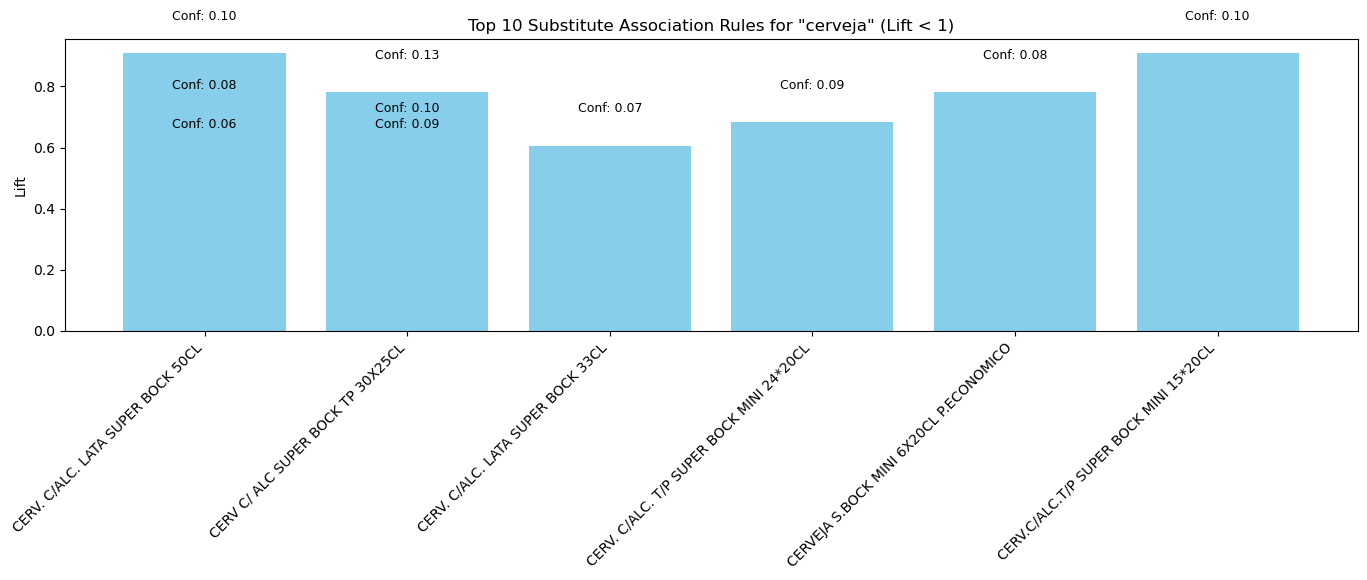

In [224]:
import matplotlib.pyplot as plt

# Top N substitute rules for cerveja (lift < 1)
top_subs = rules_cervbranca_nacional_substitute.sort_values(by='lift').head(10)

# X-axis labels = consequents
x_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Bar plot: Lift vs Consequents
plt.figure(figsize=(14, 6))
bars = plt.bar(x_labels, top_subs['lift'], color='skyblue')

# Add confidence values as annotations
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f"Conf: {conf:.2f}",
             ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.ylabel('Lift')
plt.title('Top 10 Substitute Association Rules for "cerveja" (Lift < 1)')
plt.tight_layout()
plt.show()


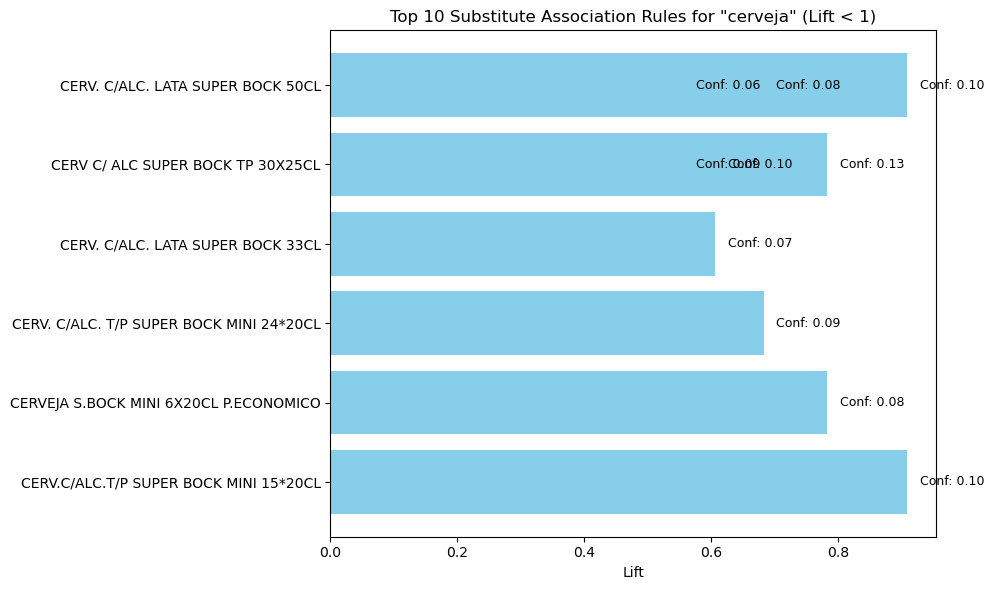

In [228]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for cerveja with lowest lift
top_subs = rules_cervbranca_nacional_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence as text at end of each bar
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "cerveja" (Lift < 1)')
plt.gca().invert_yaxis()  # Puts lowest lift at the top
plt.tight_layout()
plt.show()


In [246]:
from mlxtend.frequent_patterns import apriori, association_rules

# Apriori for bovino at
frequent_itemsets_bovino_at = apriori(encoded_df_bovino_at, min_support=0.03, use_colnames=True)
rules_bovino_at = association_rules(frequent_itemsets_bovino_at, metric="confidence", min_threshold=0.01)
rules_bovino_at = rules_bovino_at[rules_bovino_at['antecedents'] != rules_bovino_at['consequents']]

# Filter only substitute rules (lift < 1)
rules_bovino_at_substitute = rules_bovino_at[rules_bovino_at['lift'] < 1]

print("\nSubstitute Association Rules for bovino at (Lift < 1)")
display(rules_bovino_at_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for bovino at (Lift < 1)


antecedents                   consequents   support  \
31          (VITELÃO COZER - AT)  (NOVILHO BIFE DA VAZIA - AT)  0.037962   
30  (NOVILHO BIFE DA VAZIA - AT)          (VITELÃO COZER - AT)  0.037962   

    confidence      lift  
31    0.265734  0.996255  
30    0.142322  0.996255

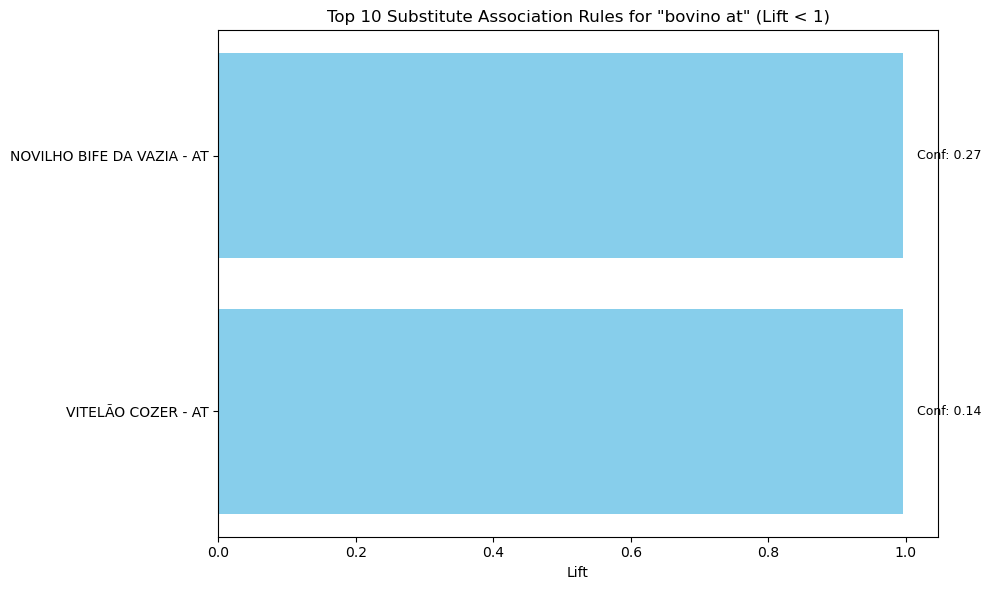

In [232]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for bovino at with lowest lift
top_subs = rules_bovino_at_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "bovino at" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [252]:


# Step 2: Apriori
frequent_itemsets_aves_coelho_ls = apriori(encoded_df_aves_coelho_ls, min_support=0.02, use_colnames=True)
rules_aves_coelho_ls = association_rules(frequent_itemsets_aves_coelho_ls, metric="confidence", min_threshold=0.01)
rules_aves_coelho_ls = rules_aves_coelho_ls[rules_aves_coelho_ls['antecedents'] != rules_aves_coelho_ls['consequents']]

# Step 3: Substitute rules
rules_aves_coelho_ls_substitute = rules_aves_coelho_ls[rules_aves_coelho_ls['lift'] < 1]

# Step 4: Display
print("\nSubstitute Association Rules for aves/coelho ls (Lift < 1)")
display(rules_aves_coelho_ls_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for aves/coelho ls (Lift < 1)


antecedents                     consequents   support  \
1  (ASAS DE FRANGO CONTINENTE LS)  (BIFE DE FRANGO CONTINENTE LS)  0.027476   
0  (BIFE DE FRANGO CONTINENTE LS)  (ASAS DE FRANGO CONTINENTE LS)  0.027476   

   confidence      lift  
1    0.252632  0.798097  
0    0.086799  0.798097

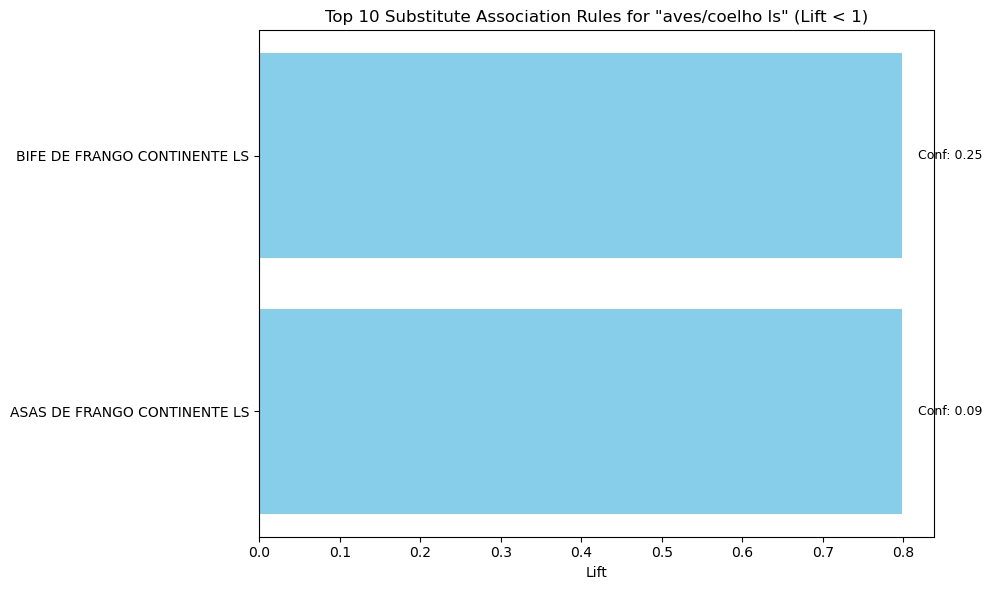

In [328]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "aves/coelho ls" with lowest lift
top_subs = rules_aves_coelho_ls_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "aves/coelho ls" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [278]:
# Prepare basket
encoded_df_aves_coelho_at, basket_aves_coelho_at = prepare_transactions(df_clean, 'aves/coelho at')

# Apriori
frequent_itemsets_aves_coelho_at = apriori(encoded_df_aves_coelho_at, min_support=0.05, use_colnames=True)
rules_aves_coelho_at = association_rules(frequent_itemsets_aves_coelho_at, metric="confidence", min_threshold=0.01)
rules_aves_coelho_at = rules_aves_coelho_at[rules_aves_coelho_at['antecedents'] != rules_aves_coelho_at['consequents']]

# Filter: substitutes
rules_aves_coelho_at_substitute = rules_aves_coelho_at[rules_aves_coelho_at['lift'] < 1]

# Display
print("\nSubstitute Association Rules for aves/coelho at (Lift < 1)")
display(rules_aves_coelho_at_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for aves/coelho at (Lift < 1)


antecedents  \
2        (PEITO DE FRANGO (2KG) COMPRA/AT)   
3   (FRANGO CAMPO INT C/M GRANEL SELECÇÃO)   
8        (PEITO DE FRANGO (2KG) COMPRA/AT)   
9   (FRANGO INTEIRO C/M GRANEL CONTINENTE)   
12                (PERU PEITO (BIFE) - AT)   
13  (FRANGO INTEIRO C/M GRANEL CONTINENTE)   

                               consequents   support  confidence      lift  
2   (FRANGO CAMPO INT C/M GRANEL SELECÇÃO)  0.072174    0.137874  0.834499  
3        (PEITO DE FRANGO (2KG) COMPRA/AT)  0.072174    0.436842  0.834499  
8   (FRANGO INTEIRO C/M GRANEL CONTINENTE)  0.146957    0.280731  0.966588  
9        (PEITO DE FRANGO (2KG) COMPRA/AT)  0.146957    0.505988  0.966588  
12  (FRANGO INTEIRO C/M GRANEL CONTINENTE)  0.079130    0.282609  0.973054  
13                (PERU PEITO (BIFE) - AT)  0.079130    0.272455  0.973054

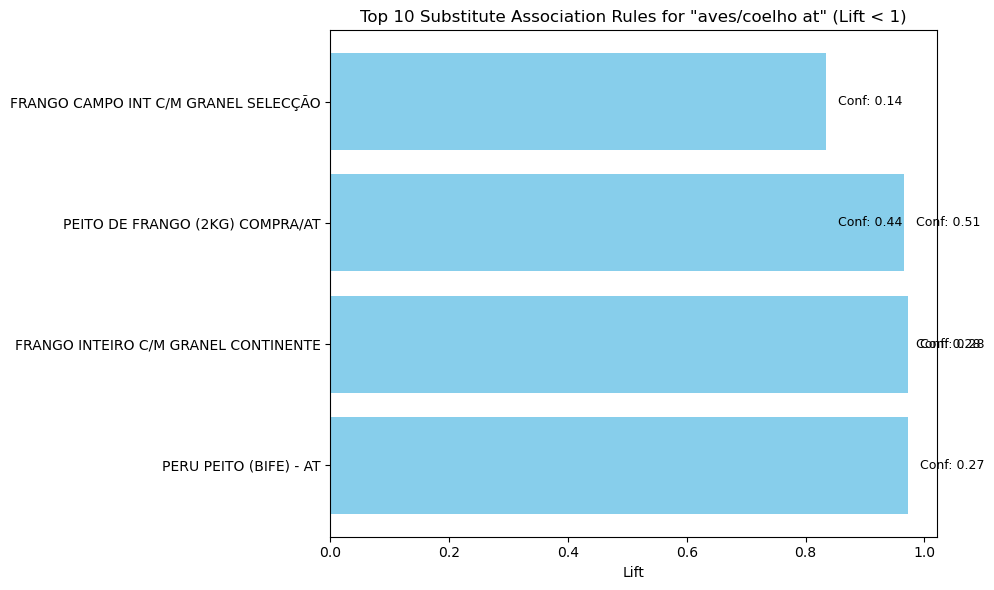

In [330]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "aves/coelho at" with lowest lift
top_subs = rules_aves_coelho_at_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "aves/coelho at" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [300]:
# Step 1: Prepare basket
encoded_df_det_maq_liquido, basket_det_maq_liquido = prepare_transactions(df_clean, 'det.maq.liquido')

# Step 2: Apply Apriori
frequent_itemsets_det_maq_liquido = apriori(encoded_df_det_maq_liquido, min_support=0.0035, use_colnames=True)
rules_det_maq_liquido = association_rules(frequent_itemsets_det_maq_liquido, metric="confidence", min_threshold=0.01)
rules_det_maq_liquido = rules_det_maq_liquido[rules_det_maq_liquido['antecedents'] != rules_det_maq_liquido['consequents']]

# Step 3: Filter substitute rules (lift < 1)
rules_det_maq_liquido_substitute = rules_det_maq_liquido[rules_det_maq_liquido['lift'] < 1]

# Step 4: Display results
print("\nSubstitute Association Rules for det.maq.liquido (Lift < 1)")
display(rules_det_maq_liquido_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for det.maq.liquido (Lift < 1)


antecedents  \
52    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)   
53          (DET LIQ MÁQ ROUPA COLÓNIA CNT 46D)   
32    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)   
33   (DET LIQ MÁQ ROUPA CNT DELICADAS POWER+ 6)   
114   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)   
115       (DET LIQ MÁQ ROUPA SURF TROPICAL 84D)   
50          (DET LIQ MÁQ ROUPA COLÓNIA CNT 46D)   
51    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)   

                                    consequents   support  confidence  \
52          (DET LIQ MÁQ ROUPA COLÓNIA CNT 46D)  0.005542    0.055556   
53    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)  0.005542    0.041667   
32   (DET LIQ MÁQ ROUPA CNT DELICADAS POWER+ 6)  0.003959    0.039683   
33    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)  0.003959    0.061728   
114       (DET LIQ MÁQ ROUPA SURF TROPICAL 84D)  0.003959    0.039683   
115   (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 76D)  0.003959    0.069444   
50    (DET LIQ MÁQ ROUPA SKIP ACTIVE CLEAN 44D)  0.003959    0.029762   
51          (DET LIQ MÁQ ROUPA COLÓNIA CNT 46D)  0.003959    0.094340   

         lift  
52   0.417659  
53   0.417659  
32   0.618754  
33   0.618754  
114  0.696098  
115  0.696098  
50   0.709232  
51   0.709232

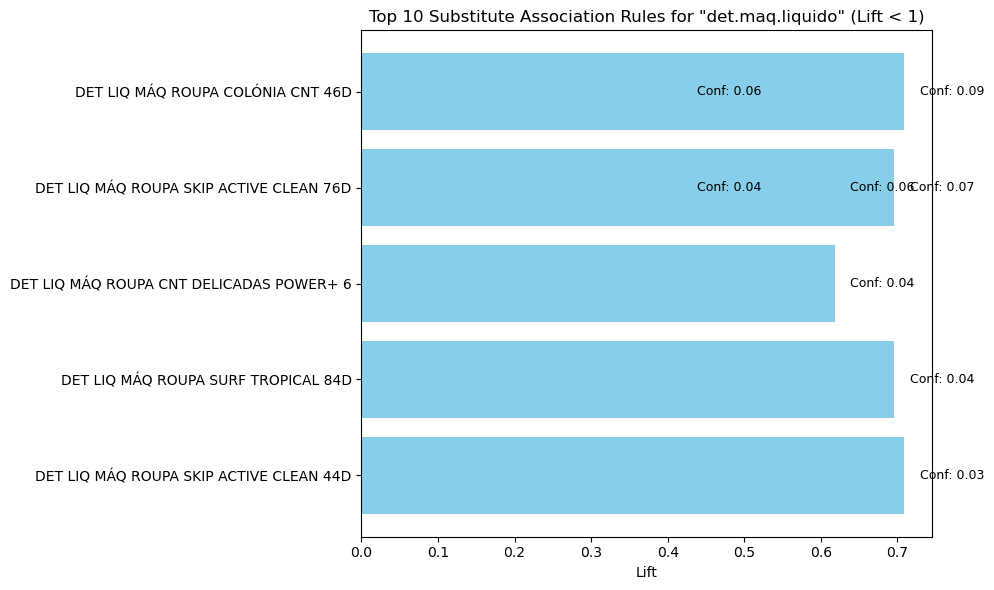

In [332]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "det.maq.liquido" with lowest lift
top_subs = rules_det_maq_liquido_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "det.maq.liquido" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [306]:
# Step 1: Prepare basket
encoded_df_massas, basket_massas = prepare_transactions(df_clean, 'massas')

# Step 2: Apply Apriori
frequent_itemsets_massas = apriori(encoded_df_massas, min_support=0.025, use_colnames=True)
rules_massas = association_rules(frequent_itemsets_massas, metric="confidence", min_threshold=0.01)
rules_massas = rules_massas[rules_massas['antecedents'] != rules_massas['consequents']]

# Step 3: Filter substitute rules (lift < 1)
rules_massas_substitute = rules_massas[rules_massas['lift'] < 1]

# Step 4: Display results
print("\nSubstitute Association Rules for massas (Lift < 1)")
display(rules_massas_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for massas (Lift < 1)


antecedents  \
12  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS)   
13              (ESPARGUETE CONTINENTE 1KG)   
73          (MAS.ESPIRAIS CONTINENTE 500GR)   
72  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS)   

                                consequents   support  confidence      lift  
12              (ESPARGUETE CONTINENTE 1KG)  0.036789    0.198454  0.706400  
13  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS)  0.036789    0.130952  0.706400  
73  (ESPARGUETE MILANEZA 500G + 10% GRÁTIS)  0.026756    0.150134  0.809873  
72          (MAS.ESPIRAIS CONTINENTE 500GR)  0.026756    0.144330  0.809873

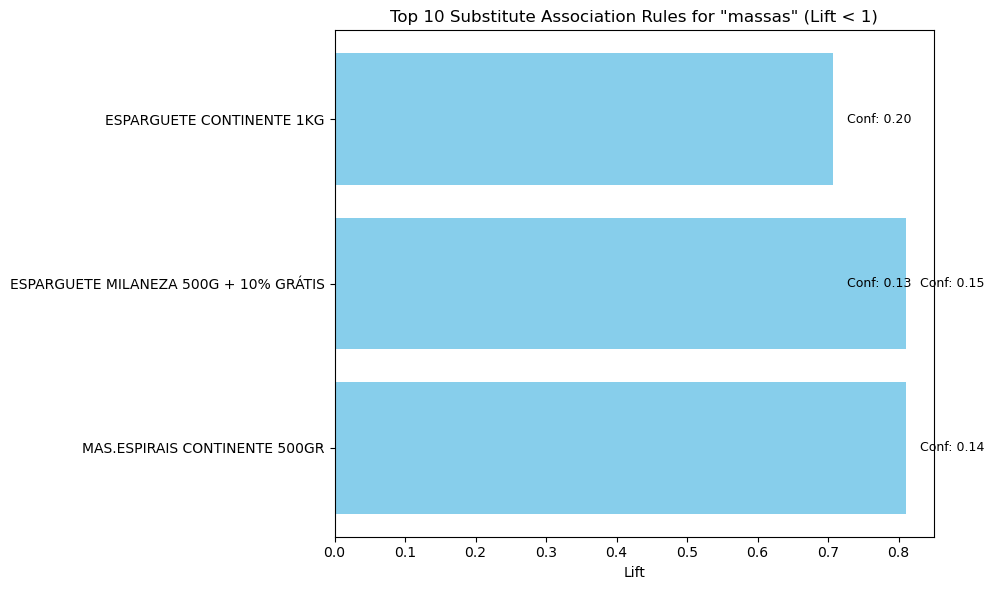

In [334]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "massas" with lowest lift
top_subs = rules_massas_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "massas" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [314]:
# Step 1: Prepare basket
encoded_df_bovino_ls, basket_bovino_ls = prepare_transactions(df_clean, 'bovino ls')

# Step 2: Apply Apriori
frequent_itemsets_bovino_ls = apriori(encoded_df_bovino_ls, min_support=0.015, use_colnames=True)
rules_bovino_ls = association_rules(frequent_itemsets_bovino_ls, metric="confidence", min_threshold=0.01)
rules_bovino_ls = rules_bovino_ls[rules_bovino_ls['antecedents'] != rules_bovino_ls['consequents']]

# Step 3: Filter substitute rules (lift < 1)
rules_bovino_ls_substitute = rules_bovino_ls[rules_bovino_ls['lift'] < 1]

# Step 4: Display results
print("\nSubstitute Association Rules for bovino ls (Lift < 1)")
display(rules_bovino_ls_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for bovino ls (Lift < 1)


antecedents  \
19  (NOVILHO BIFE TRASEIRO NACIONAL CNT LS)   
18        (NOVILHO BIFE VAZIA NACIONAL SKP)   
31      (NOVILHO JARDINEIRA/GUISAR KG - LS)   
30      (NOVILHO ESCALOPES NACIONAL CNT LS)   

                                consequents   support  confidence      lift  
19        (NOVILHO BIFE VAZIA NACIONAL SKP)  0.015873    0.067010  0.857523  
18  (NOVILHO BIFE TRASEIRO NACIONAL CNT LS)  0.015873    0.203125  0.857523  
31      (NOVILHO ESCALOPES NACIONAL CNT LS)  0.020757    0.125926  0.866667  
30      (NOVILHO JARDINEIRA/GUISAR KG - LS)  0.020757    0.142857  0.866667

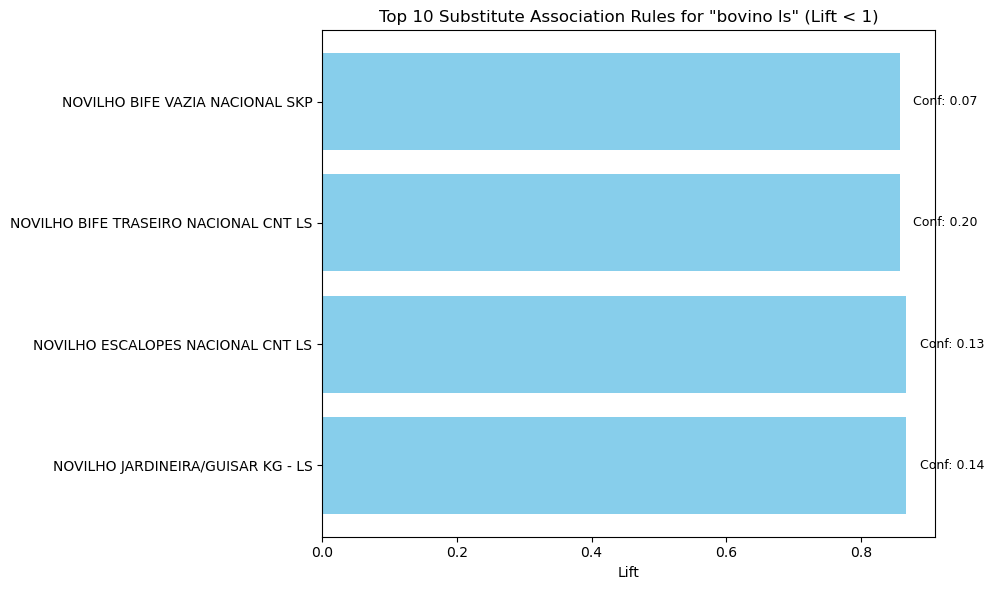

In [336]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "bovino ls" with lowest lift
top_subs = rules_bovino_ls_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "bovino ls" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [318]:
# Step 1: Prepare basket
encoded_df_batata_frita, basket_batata_frita = prepare_transactions(df_clean, 'batata frita')

# Step 2: Apply Apriori
frequent_itemsets_batata_frita = apriori(encoded_df_batata_frita, min_support=0.02, use_colnames=True)
rules_batata_frita = association_rules(frequent_itemsets_batata_frita, metric="confidence", min_threshold=0.01)
rules_batata_frita = rules_batata_frita[rules_batata_frita['antecedents'] != rules_batata_frita['consequents']]

# Step 3: Filter substitute rules (lift < 1)
rules_batata_frita_substitute = rules_batata_frita[rules_batata_frita['lift'] < 1]

# Step 4: Display results
print("\nSubstitute Association Rules for batata frita (Lift < 1)")
display(rules_batata_frita_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for batata frita (Lift < 1)


antecedents  \
67   (BATATA FRITA CAMPONESA CONTINENTE 175 GR)   
66                (BATATA FRITA LAY'S SAL 160G)   
74   (BATATA FRITA CAMPONESA CONTINENTE 175 GR)   
75   (BATATA FRITA ONDULADA C/SAL RUFFLES 160G)   
147     (BATATA FRITA PALHA CONT.POUPANCA 400G)   
146  (BATATA FRITA ONDULADA C/SAL RUFFLES 160G)   
168        (BATATA FRITA RUFFLES PRESUNTO 150G)   
169     (BATATA FRITA PALHA CONT.POUPANCA 400G)   

                                    consequents   support  confidence  \
67                (BATATA FRITA LAY'S SAL 160G)  0.020360    0.088843   
66   (BATATA FRITA CAMPONESA CONTINENTE 175 GR)  0.020360    0.166667   
74   (BATATA FRITA ONDULADA C/SAL RUFFLES 160G)  0.024621    0.107438   
75   (BATATA FRITA CAMPONESA CONTINENTE 175 GR)  0.024621    0.185053   
147  (BATATA FRITA ONDULADA C/SAL RUFFLES 160G)  0.027462    0.109228   
146     (BATATA FRITA PALHA CONT.POUPANCA 400G)  0.027462    0.206406   
168     (BATATA FRITA PALHA CONT.POUPANCA 400G)  0.027936    0.232283   
169        (BATATA FRITA RUFFLES PRESUNTO 150G)  0.027936    0.111111   

         lift  
67   0.727273  
66   0.727273  
74   0.807506  
75   0.807506  
147  0.820958  
146  0.820958  
168  0.923885  
169  0.923885

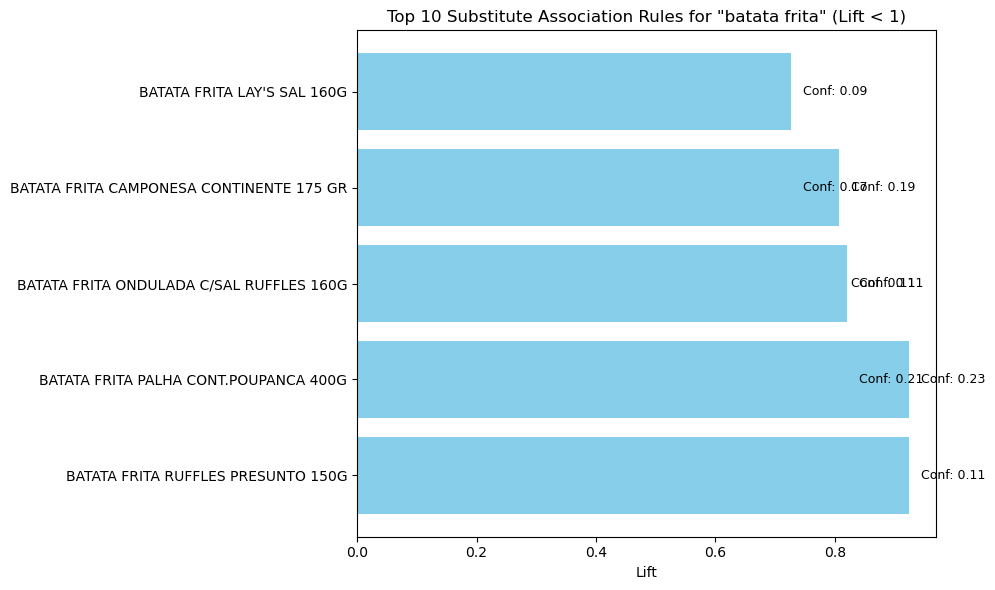

In [338]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "batata frita" with lowest lift
top_subs = rules_batata_frita_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "batata frita" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [326]:
# Step 1: Prepare basket
encoded_df_aquacultura, basket_aquacultura = prepare_transactions(df_clean, 'aquacultura')

# Step 2: Apply Apriori
frequent_itemsets_aquacultura = apriori(encoded_df_aquacultura, min_support=0.08, use_colnames=True)
rules_aquacultura = association_rules(frequent_itemsets_aquacultura, metric="confidence", min_threshold=0.01)
rules_aquacultura = rules_aquacultura[rules_aquacultura['antecedents'] != rules_aquacultura['consequents']]

# Step 3: Filter substitute rules (lift < 1)
rules_aquacultura_substitute = rules_aquacultura[rules_aquacultura['lift'] < 1]

# Step 4: Display results
print("\nSubstitute Association Rules for aquacultura (Lift < 1)")
display(rules_aquacultura_substitute[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift'))



Substitute Association Rules for aquacultura (Lift < 1)


antecedents                   consequents   support  \
5    (DOURADA MÉDIA (200-600G))         (ROBALO GRANDE +600G)  0.088798   
4         (ROBALO GRANDE +600G)    (DOURADA MÉDIA (200-600G))  0.088798   
2      (DOURADA GRANDE (+600G))  (ROBALO MÉDIO (200-600G) KG)  0.086066   
3  (ROBALO MÉDIO (200-600G) KG)      (DOURADA GRANDE (+600G))  0.086066   
0      (DOURADA GRANDE (+600G))    (DOURADA MÉDIA (200-600G))  0.142077   
1    (DOURADA MÉDIA (200-600G))      (DOURADA GRANDE (+600G))  0.142077   
6  (ROBALO MÉDIO (200-600G) KG)    (DOURADA MÉDIA (200-600G))  0.187158   
7    (DOURADA MÉDIA (200-600G))  (ROBALO MÉDIO (200-600G) KG)  0.187158   

   confidence      lift  
5    0.158537  0.805894  
4    0.451389  0.805894  
2    0.318182  0.920589  
3    0.249012  0.920589  
0    0.525253  0.937768  
1    0.253659  0.937768  
6    0.541502  0.966779  
7    0.334146  0.966779

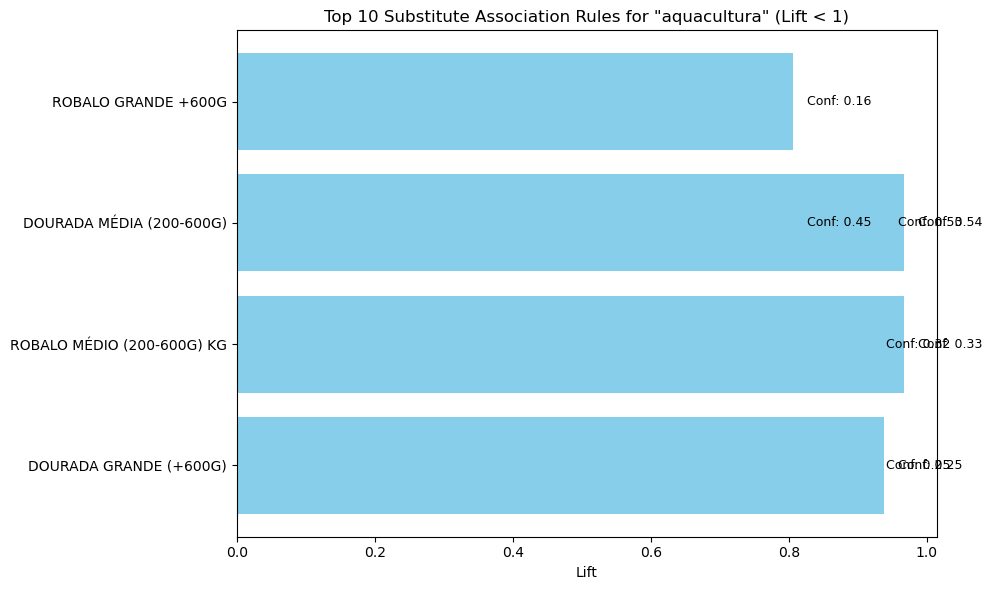

In [344]:
import matplotlib.pyplot as plt

# Top 10 substitute rules for "aquacultura" with lowest lift
top_subs = rules_aquacultura_substitute.sort_values(by='lift').head(10)

# Y-axis labels = consequents
y_labels = [', '.join(map(str, r)) for r in top_subs['consequents']]

# Create horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(y_labels, top_subs['lift'], color='skyblue')

# Add confidence values at end of bars
for bar, conf in zip(bars, top_subs['confidence']):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"Conf: {conf:.2f}", va='center', fontsize=9)

plt.xlabel('Lift')
plt.title('Top 10 Substitute Association Rules for "aquacultura" (Lift < 1)')
plt.gca().invert_yaxis()  # Show lowest lift on top
plt.tight_layout()
plt.show()


In [359]:
#TOP SUBSTITUTES FOR EACH CATEGORY

# Global thresholds for all subcategories
min_support = 0.01  # Minimum support: ensures rules apply to at least 1% of transactions
min_confidence = 0.1  # Minimum confidence: ensures at least 10% of antecedent transactions also have the consequent

# These thresholds are a solid starting point to find meaningful substitute rules
# - Use higher values if you want stronger, more confident associations
# - Use lower values if you're getting too few rules

# Example adjustments:
# min_support = 0.005   # Allows less frequent product combinations
# min_confidence = 0.05 # Allows weaker but still interesting associations

# Monitor the number of rules per subcategory and adjust if needed



In [361]:
# Global thresholds for all subcategories
min_support = 0.01  # Minimum support: ensures rules apply to at least 1% of transactions
min_confidence = 0.1  # Minimum confidence: ensures at least 10% of antecedent transactions also have the consequent

# Substitute rule sets per subcategory
substitute_sets = [
    ("bovino at", rules_bovino_at_substitute),
    ("aves/coelho ls", rules_aves_coelho_ls_substitute),
    ("aves/coelho at", rules_aves_coelho_at_substitute),
    ("det.maq.liquido", rules_det_maq_liquido_substitute),
    ("massas", rules_massas_substitute),
    ("bovino ls", rules_bovino_ls_substitute),
    ("batata frita", rules_batata_frita_substitute),
    ("aquacultura", rules_aquacultura_substitute),
    ("cerv.branca nacional", rules_cervbranca_nacional_substitute),
    ("arroz", rules_arroz_substitute)
]

# Collect the top substitute rule for each subcategory (applying global thresholds)
top_substitutes = []

for name, rules_df in substitute_sets:
    # Apply global support and confidence filters
    filtered_rules = rules_df[
        (rules_df['support'] >= min_support) &
        (rules_df['confidence'] >= min_confidence)
    ]
    
    # If there are valid rules, pick the one with the lowest lift (best substitute)
    if not filtered_rules.empty:
        top_rule = filtered_rules.sort_values(by='lift').iloc[0]
        top_substitutes.append({
            "Subcategory": name,
            "Antecedents": ', '.join(map(str, top_rule['antecedents'])),
            "Consequents": ', '.join(map(str, top_rule['consequents'])),
            "Support": top_rule['support'],
            "Confidence": top_rule['confidence'],
            "Lift": top_rule['lift']
        })

# Convert results into a DataFrame
top_subs_df_filtered = pd.DataFrame(top_substitutes)

# Display table sorted by lift (best substitutes on top)
display(top_subs_df_filtered.sort_values(by='Lift'))

Subcategory                            Antecedents  \
7  cerv.branca nacional      CERV. C/ALC. LATA SUPER BOCK 33CL   
8                 arroz           ARROZ BASMATI CONTINENTE 1KG   
3                massas  ESPARGUETE MILANEZA 500G + 10% GRÁTIS   
5          batata frita            BATATA FRITA LAY'S SAL 160G   
1        aves/coelho ls           ASAS DE FRANGO CONTINENTE LS   
6           aquacultura               DOURADA MÉDIA (200-600G)   
2        aves/coelho at        PEITO DE FRANGO (2KG) COMPRA/AT   
4             bovino ls        NOVILHO BIFE VAZIA NACIONAL SKP   
0             bovino at                     VITELÃO COZER - AT   

                                Consequents   Support  Confidence      Lift  
7         CERV C/ ALC SUPER BOCK TP 30X25CL  0.012066    0.100629  0.606518  
8                   ARROZ AGULHA CIGALA 1KG  0.034359    0.151584  0.620984  
3                 ESPARGUETE CONTINENTE 1KG  0.036789    0.198454  0.706400  
5  BATATA FRITA CAMPONESA CONTINENTE 175 GR  0.020360    0.166667  0.727273  
1              BIFE DE FRANGO CONTINENTE LS  0.027476    0.252632  0.798097  
6                       ROBALO GRANDE +600G  0.088798    0.158537  0.805894  
2      FRANGO CAMPO INT C/M GRANEL SELECÇÃO  0.072174    0.137874  0.834499  
4     NOVILHO BIFE TRASEIRO NACIONAL CNT LS  0.015873    0.203125  0.857523  
0                NOVILHO BIFE DA VAZIA - AT  0.037962    0.265734  0.996255

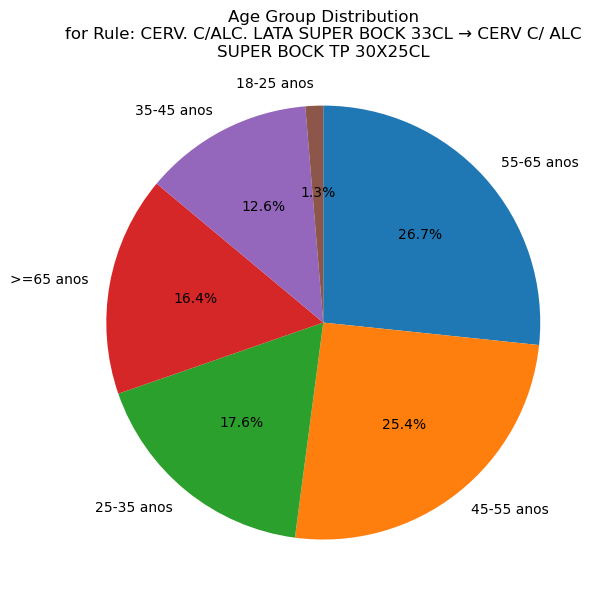

In [369]:
import matplotlib.pyplot as plt
import textwrap

# Define the specific rule (antecedents + consequents)
products = [
    "CERV. C/ALC. LATA SUPER BOCK 33CL", 
    "CERV C/ ALC SUPER BOCK TP 30X25CL"
]

# Filter transactions that contain any of the products in the rule
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Get age group distribution
age_group_counts = matching_rows['age_group'].value_counts()

# Skip if no data found
if age_group_counts.empty:
    print("⚠️ No transactions found for the selected rule.")
else:
    # Prepare label for chart
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')  # Keep it circular
    plt.tight_layout()
    plt.show()



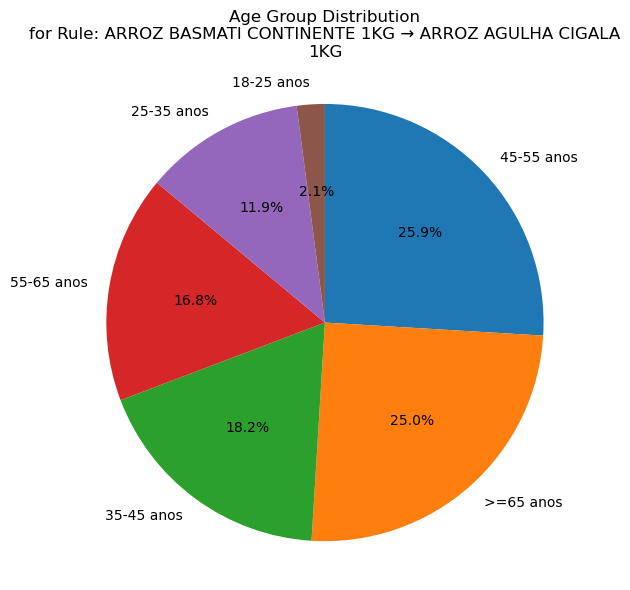

In [371]:
import matplotlib.pyplot as plt
import textwrap

# Define the two products from the substitution rule
products = [
    "ARROZ BASMATI CONTINENTE 1KG",
    "ARROZ AGULHA CIGALA 1KG"
]

# Filter rows that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Get distribution of age groups
age_group_counts = matching_rows['age_group'].value_counts()

# Check if any data exists
if age_group_counts.empty:
    print("⚠️ No transactions found for the selected 'arroz' rule.")
else:
    # Rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


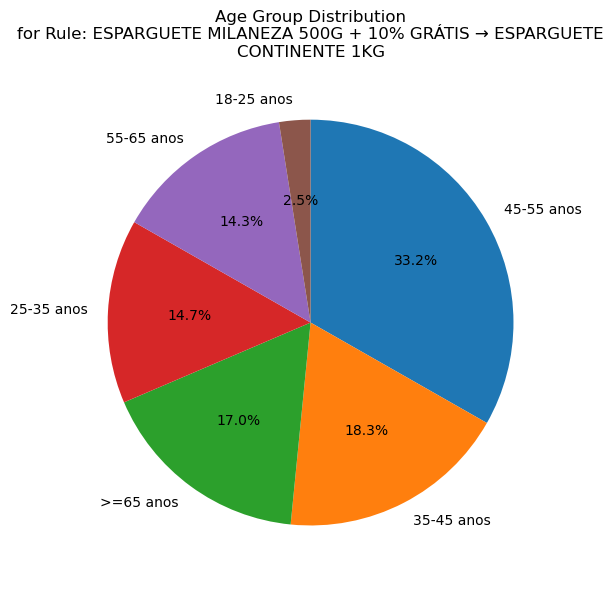

In [373]:
import matplotlib.pyplot as plt
import textwrap

# Define the products involved in the rule
products = [
    "ESPARGUETE MILANEZA 500G + 10% GRÁTIS",
    "ESPARGUETE CONTINENTE 1KG"
]

# Filter transactions involving either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count occurrences per age group
age_group_counts = matching_rows['age_group'].value_counts()

# Check for data
if age_group_counts.empty:
    print("⚠️ No transactions found for the selected 'massas' rule.")
else:
    # Format the rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


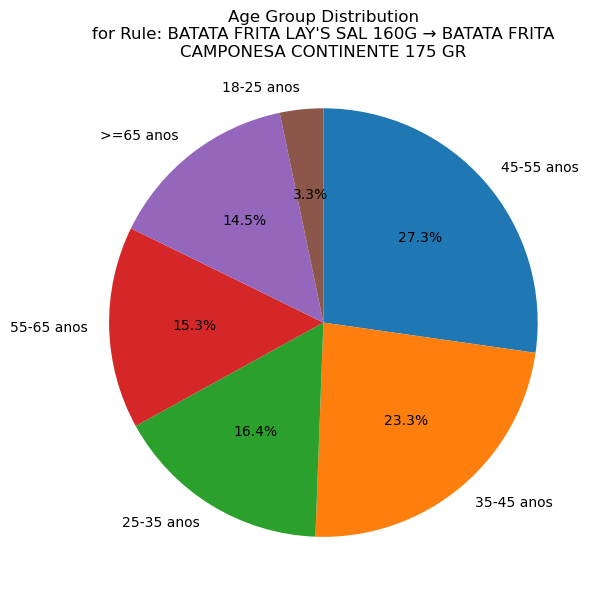

In [375]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitution rule
products = [
    "BATATA FRITA LAY'S SAL 160G",
    "BATATA FRITA CAMPONESA CONTINENTE 175 GR"
]

# Filter rows in df_clean that include any of the products
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count how many times each age group appears
age_group_counts = matching_rows['age_group'].value_counts()

# Plot only if data is available
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'batata frita' rule.")
else:
    # Format label for display
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Create pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


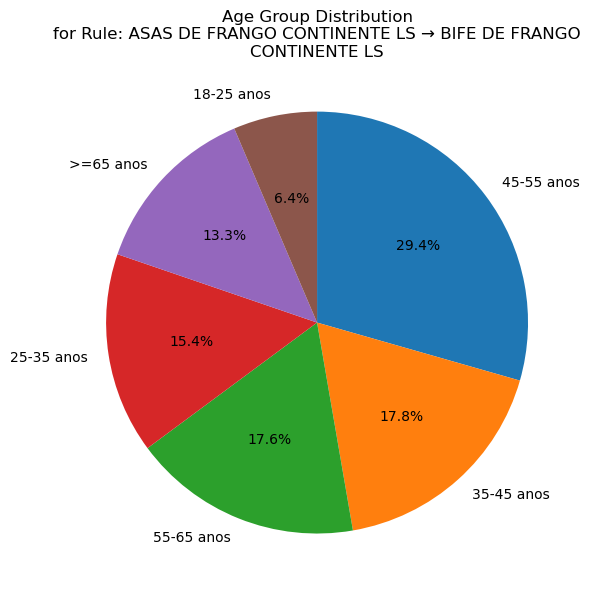

In [377]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "ASAS DE FRANGO CONTINENTE LS",
    "BIFE DE FRANGO CONTINENTE LS"
]

# Filter relevant transactions
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the age groups
age_group_counts = matching_rows['age_group'].value_counts()

# If there is data, plot it
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'aves/coelho ls' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Plot pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')  # Keep pie circular
    plt.tight_layout()
    plt.show()


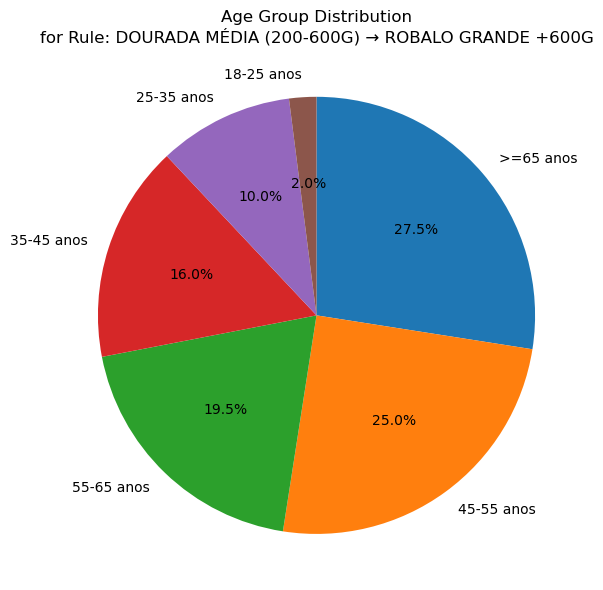

In [379]:
import matplotlib.pyplot as plt
import textwrap

# Define the products involved in the substitution rule
products = [
    "DOURADA MÉDIA (200-600G)",
    "ROBALO GRANDE +600G"
]

# Filter transactions containing either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the age groups
age_group_counts = matching_rows['age_group'].value_counts()

# If data exists, plot it
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'aquacultura' rule.")
else:
    # Format and wrap the rule label for readability
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')  # Equal aspect keeps chart circular
    plt.tight_layout()
    plt.show()


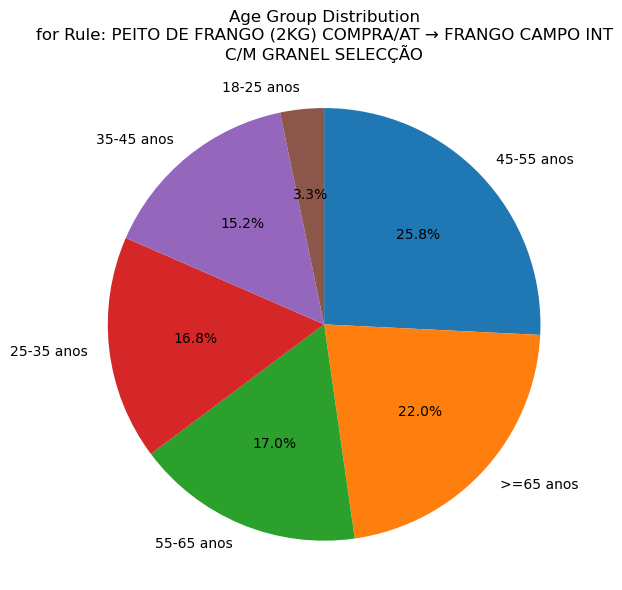

In [381]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "PEITO DE FRANGO (2KG) COMPRA/AT",
    "FRANGO CAMPO INT C/M GRANEL SELECÇÃO"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the age groups
age_group_counts = matching_rows['age_group'].value_counts()

# If data exists, plot it
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'aves/coelho at' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


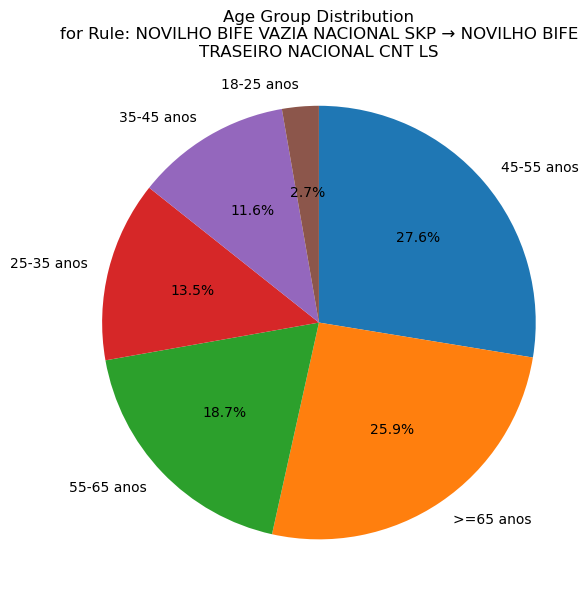

In [383]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "NOVILHO BIFE VAZIA NACIONAL SKP",
    "NOVILHO BIFE TRASEIRO NACIONAL CNT LS"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the age groups
age_group_counts = matching_rows['age_group'].value_counts()

# If data exists, plot it
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'bovino ls' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


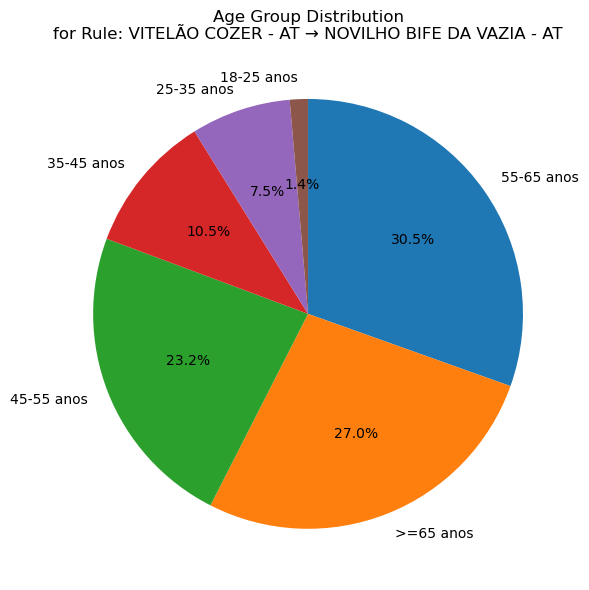

In [386]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "VITELÃO COZER - AT",
    "NOVILHO BIFE DA VAZIA - AT"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the age groups
age_group_counts = matching_rows['age_group'].value_counts()

# If data exists, plot it
if age_group_counts.empty:
    print("⚠️ No transactions found for this 'bovino at' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(
        age_group_counts,
        labels=age_group_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        counterclock=False
    )
    plt.title(f'Age Group Distribution\nfor Rule: {wrapped_label}')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


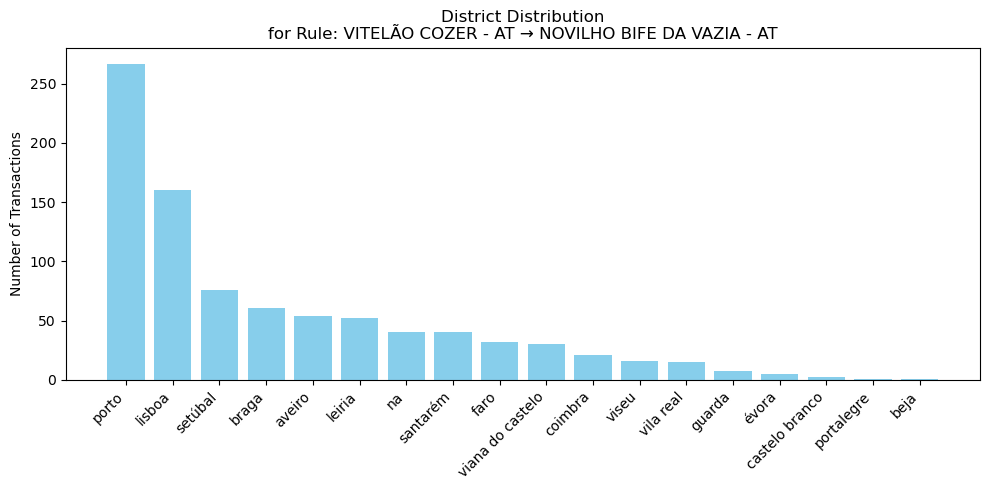

In [389]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "VITELÃO COZER - AT",
    "NOVILHO BIFE DA VAZIA - AT"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'bovino at' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


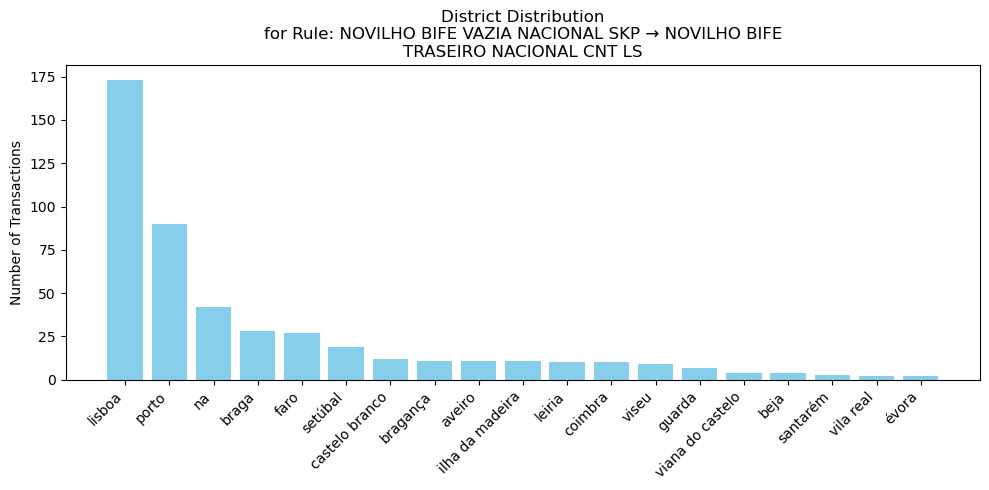

In [391]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "NOVILHO BIFE VAZIA NACIONAL SKP",
    "NOVILHO BIFE TRASEIRO NACIONAL CNT LS"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'bovino ls' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


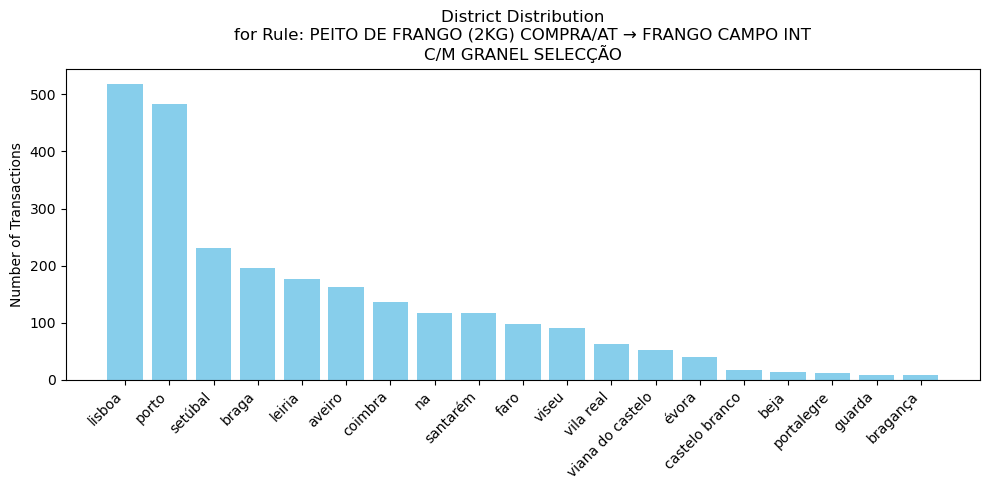

In [393]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "PEITO DE FRANGO (2KG) COMPRA/AT",
    "FRANGO CAMPO INT C/M GRANEL SELECÇÃO"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'aves/coelho at' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


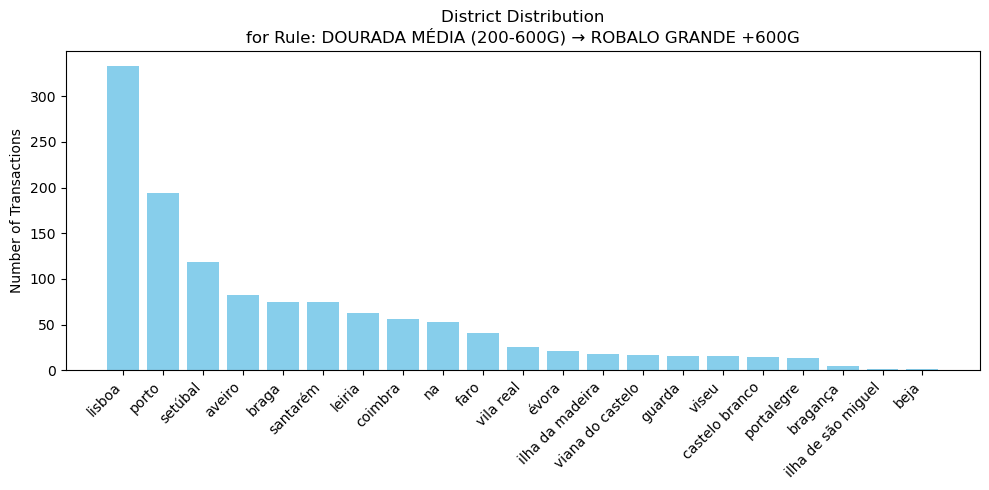

In [395]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "DOURADA MÉDIA (200-600G)",
    "ROBALO GRANDE +600G"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'aquacultura' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


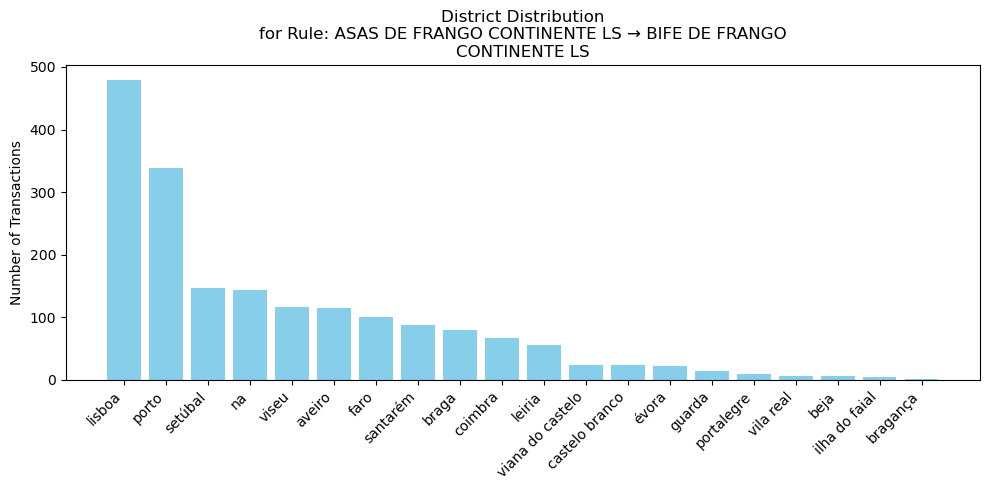

In [397]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "ASAS DE FRANGO CONTINENTE LS",
    "BIFE DE FRANGO CONTINENTE LS"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'aves/coelho ls' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


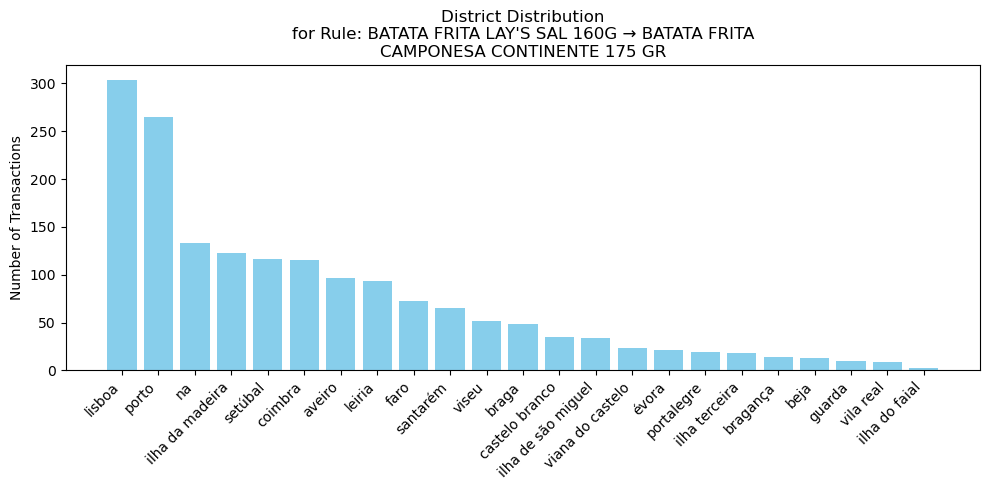

In [399]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "BATATA FRITA LAY'S SAL 160G",
    "BATATA FRITA CAMPONESA CONTINENTE 175 GR"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'batata frita' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


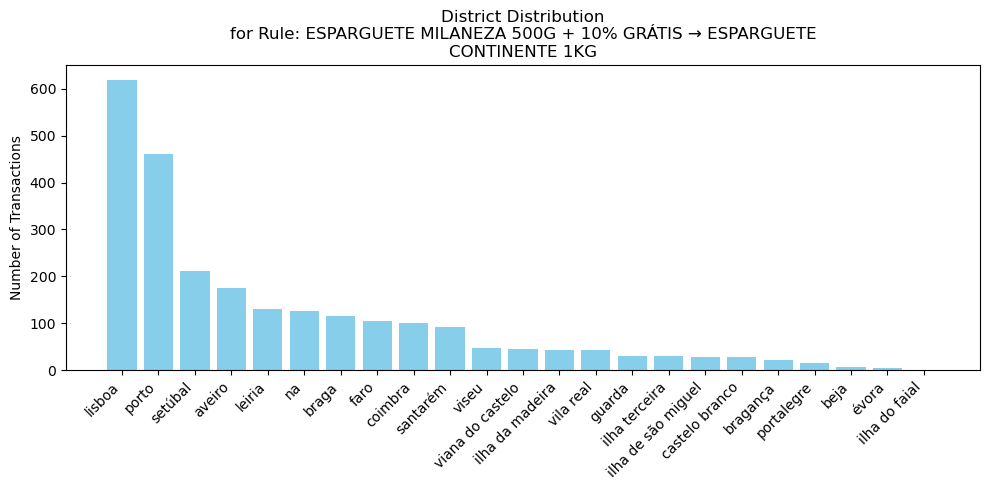

In [403]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "ESPARGUETE MILANEZA 500G + 10% GRÁTIS",
    "ESPARGUETE CONTINENTE 1KG"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'massas' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


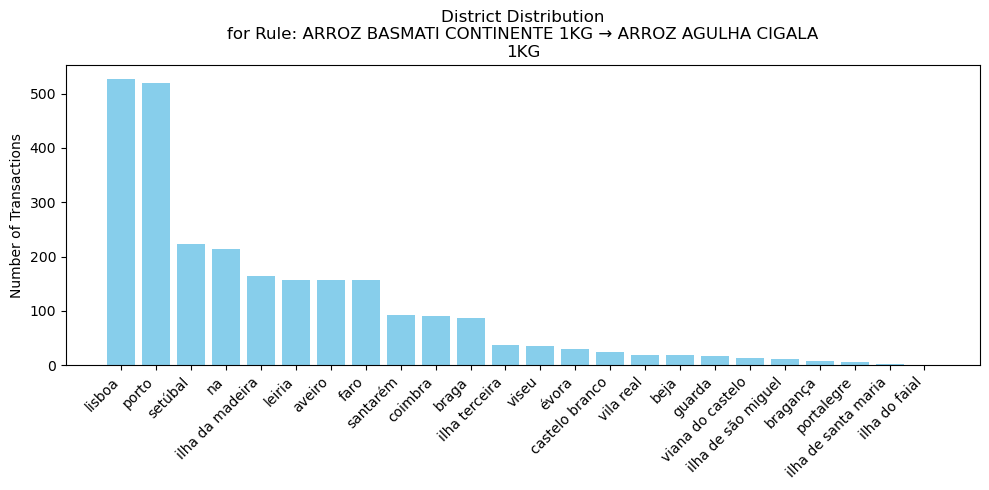

In [405]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "ARROZ BASMATI CONTINENTE 1KG",
    "ARROZ AGULHA CIGALA 1KG"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'arroz' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


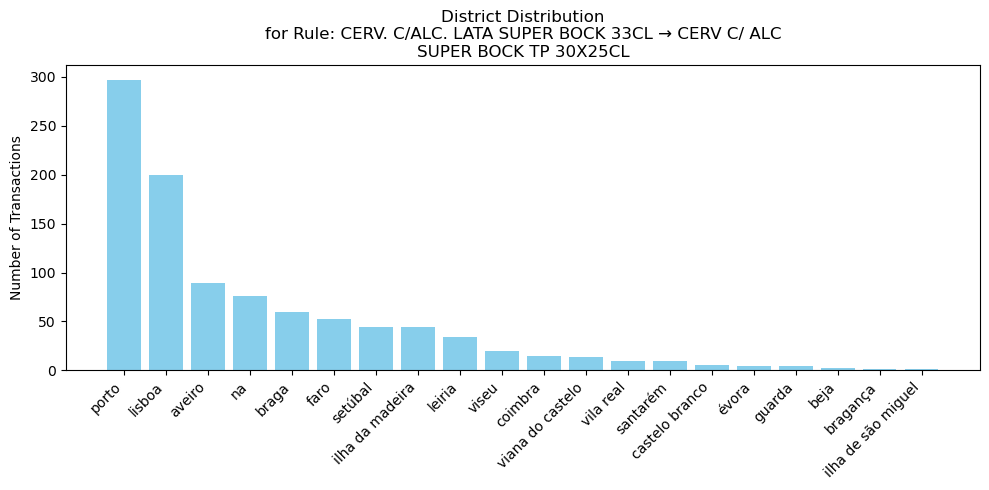

In [407]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the rule
products = [
    "CERV. C/ALC. LATA SUPER BOCK 33CL",
    "CERV C/ ALC SUPER BOCK TP 30X25CL"
]

# Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Count the districts
district_counts = matching_rows['district'].value_counts()

# If data exists, plot it
if district_counts.empty:
    print("⚠️ No transactions found for this 'cerveja' rule.")
else:
    # Format rule label
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    # Bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(district_counts.index, district_counts.values, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Number of Transactions')
    plt.title(f'District Distribution\nfor Rule: {wrapped_label}')
    plt.tight_layout()
    plt.show()


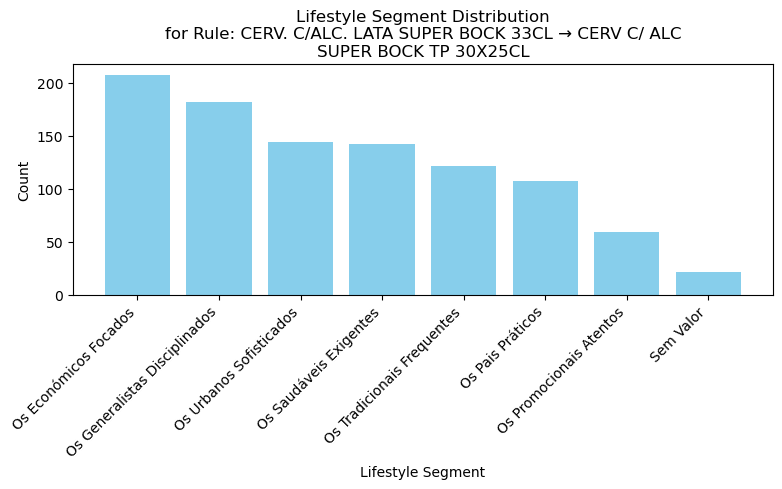

In [420]:

import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "CERV. C/ALC. LATA SUPER BOCK 33CL",
    "CERV C/ ALC SUPER BOCK TP 30X25CL"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



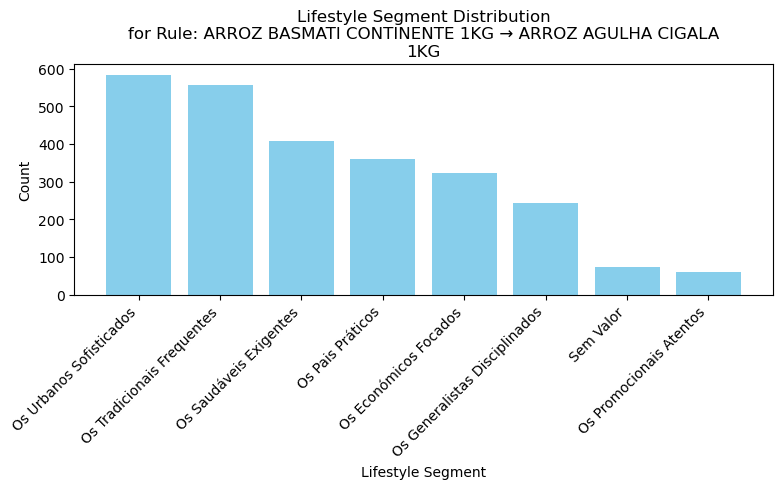

In [422]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (arroz)
products = [
    "ARROZ BASMATI CONTINENTE 1KG",
    "ARROZ AGULHA CIGALA 1KG"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


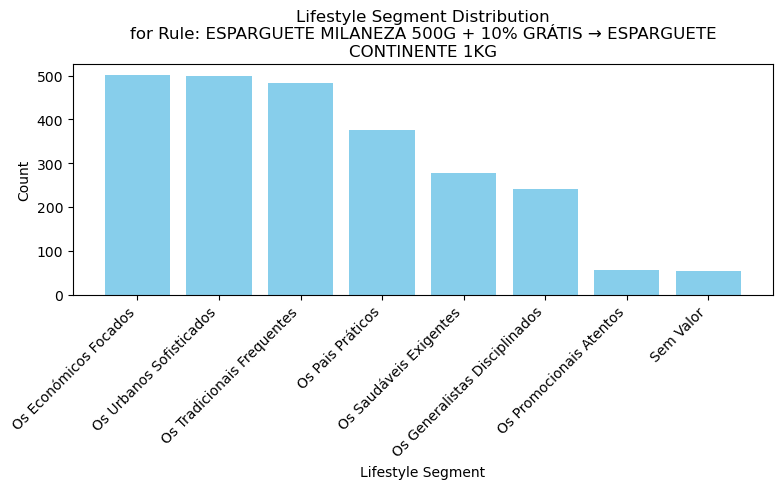

In [424]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (massas)
products = [
    "ESPARGUETE MILANEZA 500G + 10% GRÁTIS",
    "ESPARGUETE CONTINENTE 1KG"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


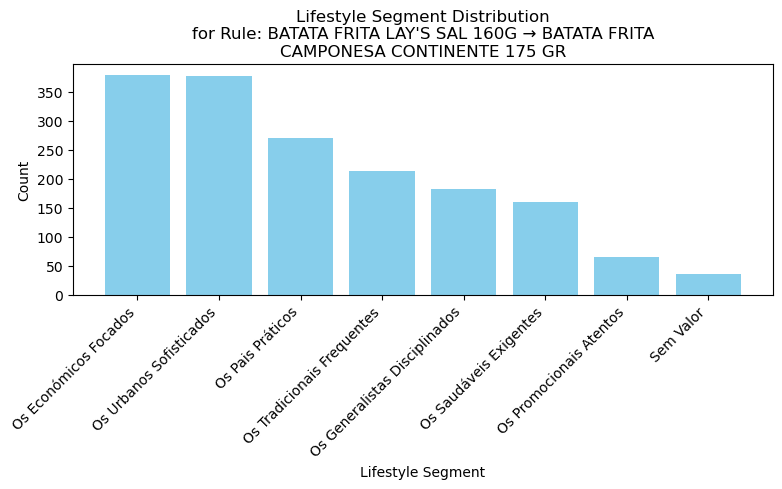

In [426]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (batata frita)
products = [
    "BATATA FRITA LAY'S SAL 160G",
    "BATATA FRITA CAMPONESA CONTINENTE 175 GR"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


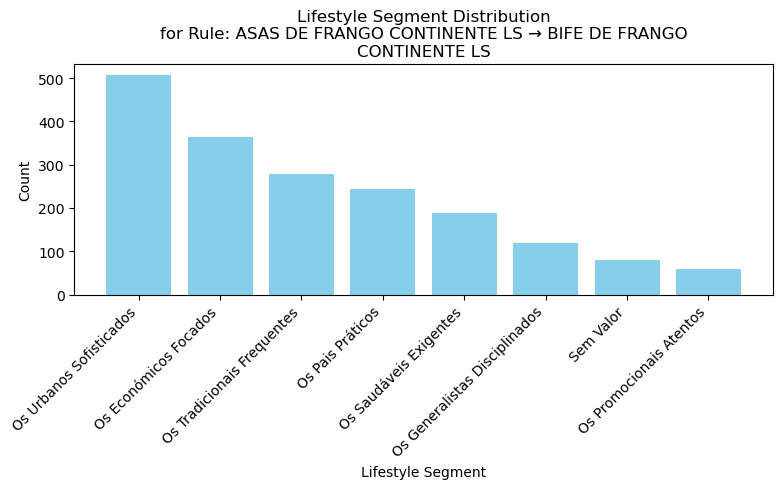

In [428]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (aves/coelho ls)
products = [
    "ASAS DE FRANGO CONTINENTE LS",
    "BIFE DE FRANGO CONTINENTE LS"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


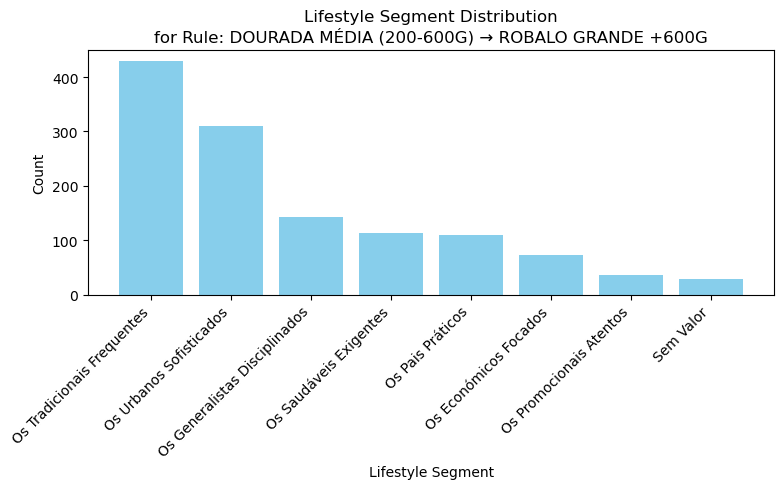

In [430]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (aquacultura)
products = [
    "DOURADA MÉDIA (200-600G)",
    "ROBALO GRANDE +600G"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


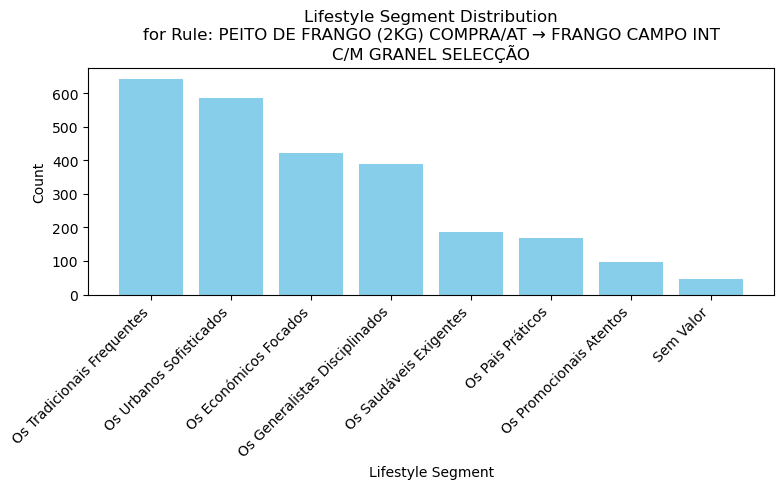

In [434]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (aves/coelho at)
products = [
    "PEITO DE FRANGO (2KG) COMPRA/AT",
    "FRANGO CAMPO INT C/M GRANEL SELECÇÃO"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


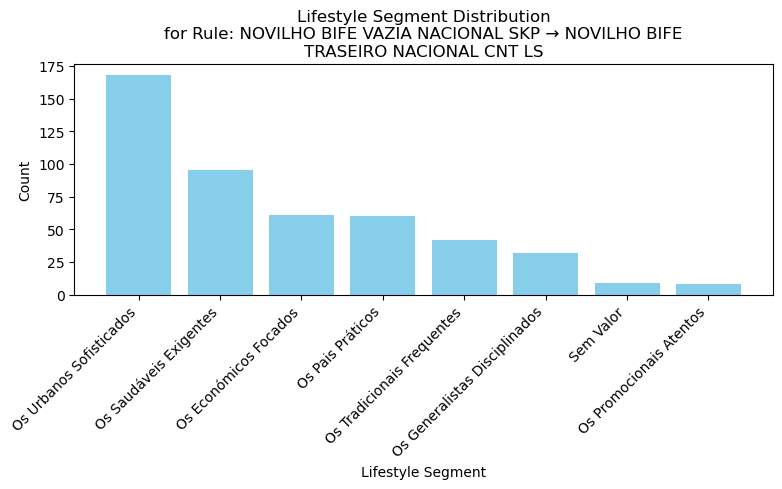

In [436]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (bovino ls)
products = [
    "NOVILHO BIFE VAZIA NACIONAL SKP",
    "NOVILHO BIFE TRASEIRO NACIONAL CNT LS"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


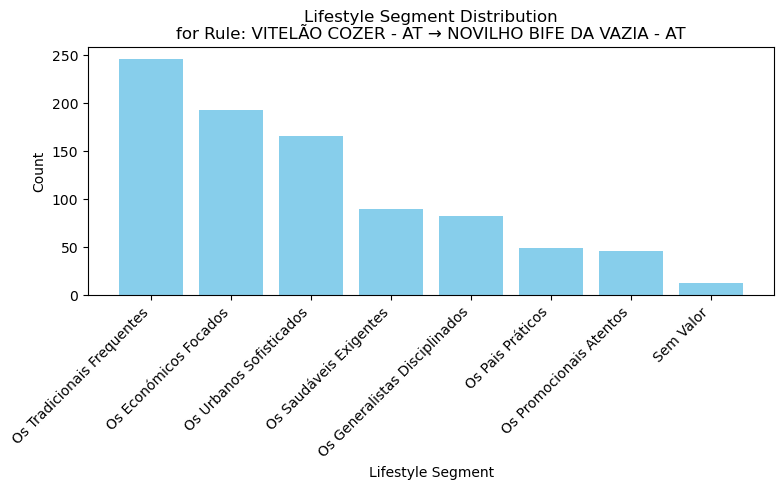

In [439]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (bovino at)
products = [
    "VITELÃO COZER - AT",
    "NOVILHO BIFE DA VAZIA - AT"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestyle segments
lifestyle_counts = matching_rows['segment_dsc_lifestyle'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestyle_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestyle_counts.index, lifestyle_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestyle Segment')
    plt.title(f'Lifestyle Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


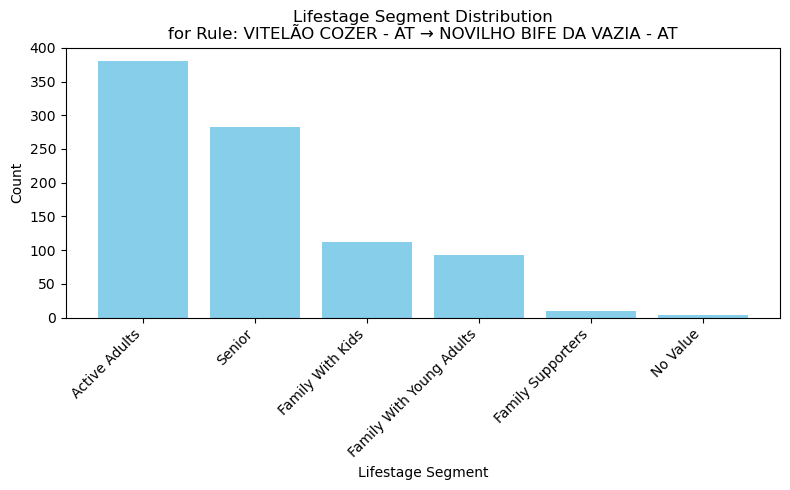

In [443]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule (bovino at)
products = [
    "VITELÃO COZER - AT",
    "NOVILHO BIFE DA VAZIA - AT"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


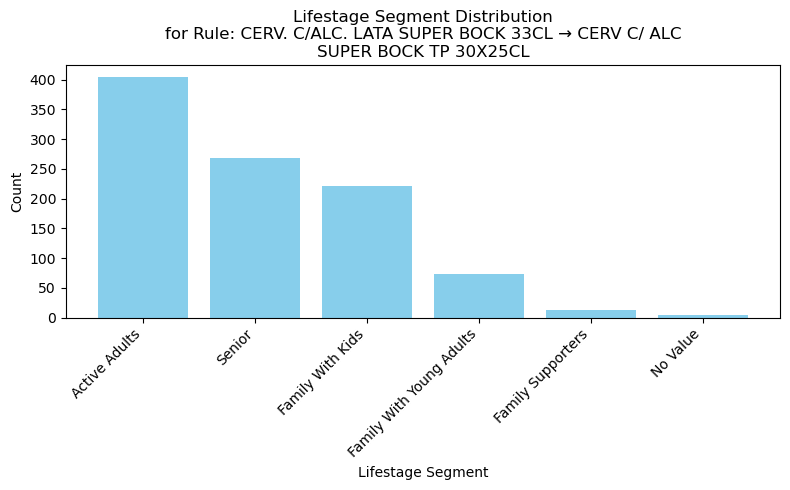

In [445]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "CERV. C/ALC. LATA SUPER BOCK 33CL",
    "CERV C/ ALC SUPER BOCK TP 30X25CL"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


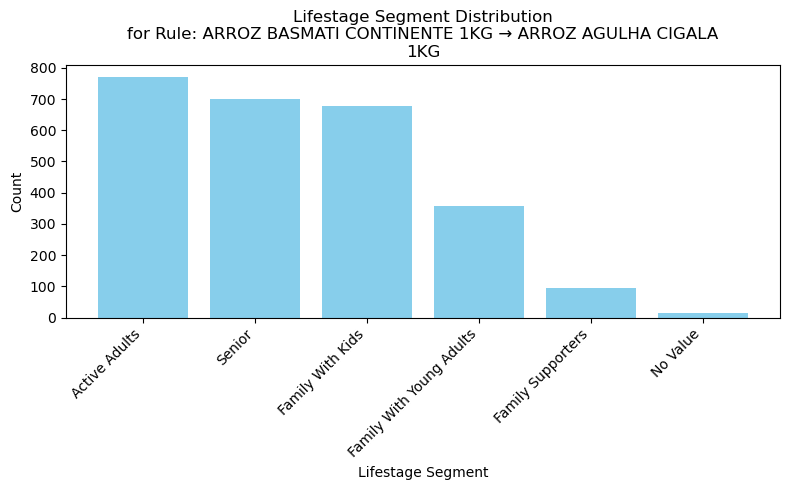

In [447]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "ARROZ BASMATI CONTINENTE 1KG",
    "ARROZ AGULHA CIGALA 1KG"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


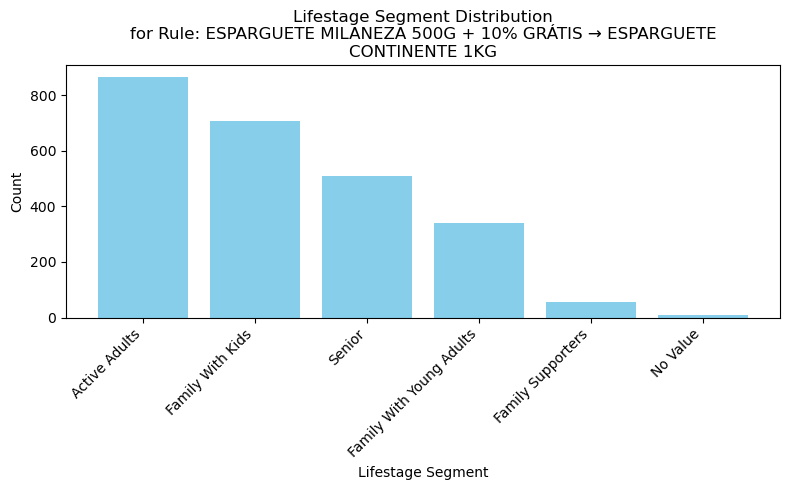

In [449]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "ESPARGUETE MILANEZA 500G + 10% GRÁTIS",
    "ESPARGUETE CONTINENTE 1KG"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


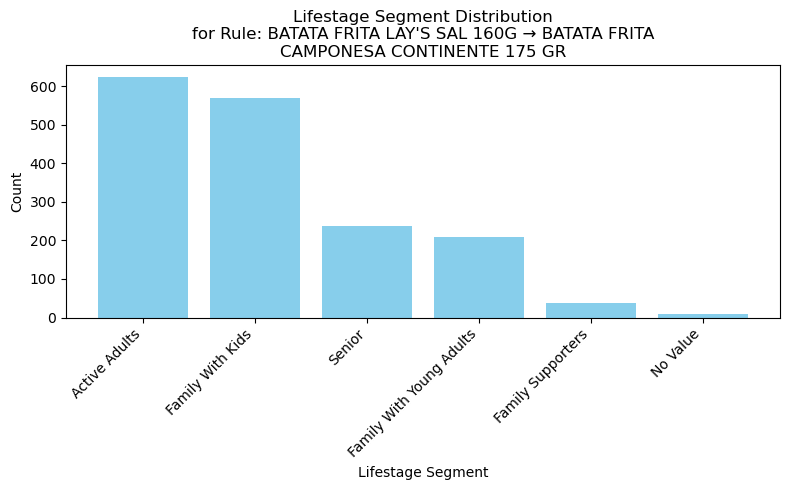

In [451]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "BATATA FRITA LAY'S SAL 160G",
    "BATATA FRITA CAMPONESA CONTINENTE 175 GR"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


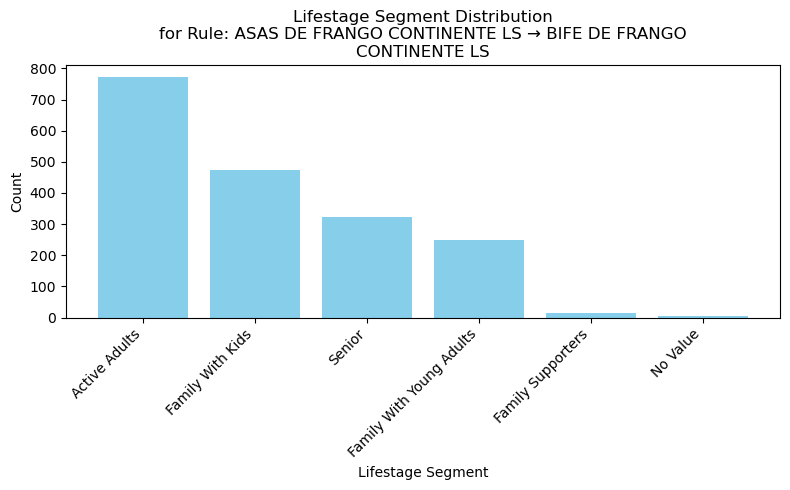

In [453]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "ASAS DE FRANGO CONTINENTE LS",
    "BIFE DE FRANGO CONTINENTE LS"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


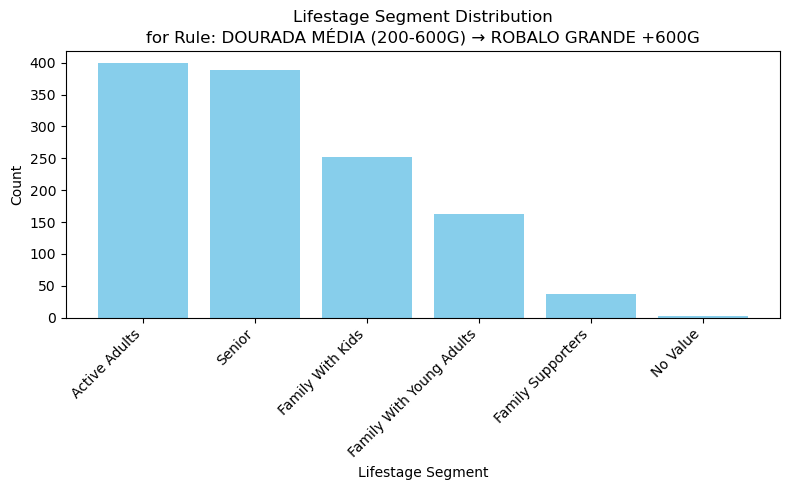

In [455]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "DOURADA MÉDIA (200-600G)",
    "ROBALO GRANDE +600G"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


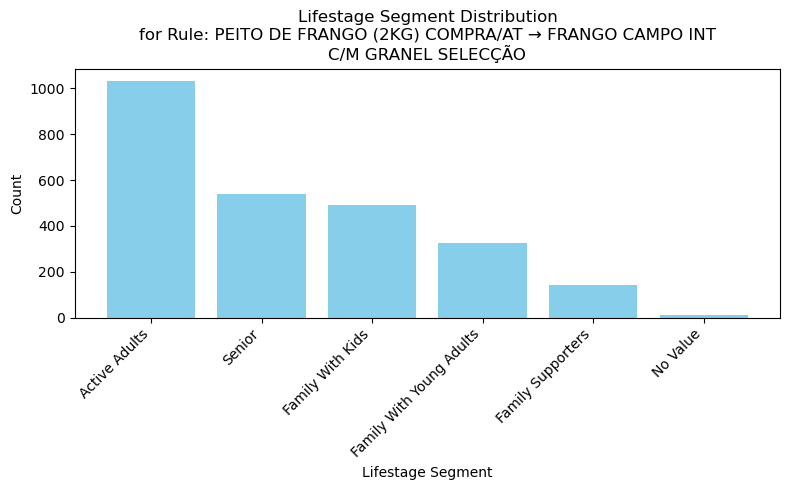

In [457]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "PEITO DE FRANGO (2KG) COMPRA/AT",
    "FRANGO CAMPO INT C/M GRANEL SELECÇÃO"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


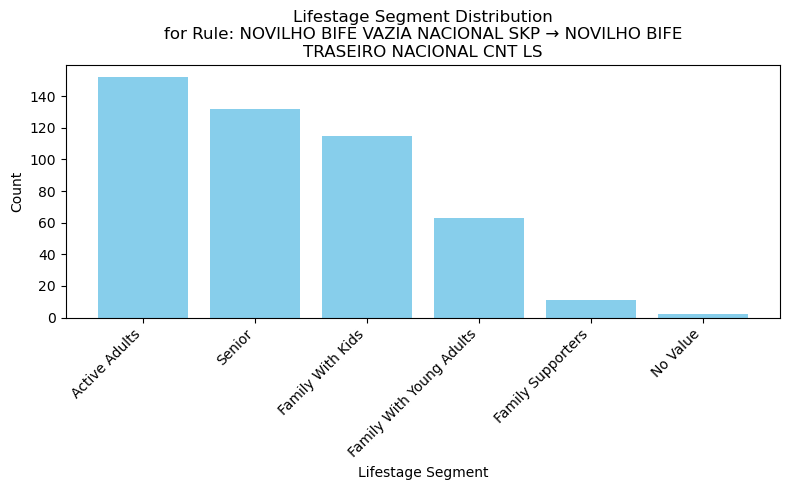

In [459]:
import matplotlib.pyplot as plt
import textwrap

# Define the products in the substitute rule
products = [
    "NOVILHO BIFE VAZIA NACIONAL SKP",
    "NOVILHO BIFE TRASEIRO NACIONAL CNT LS"
]

# Step 1: Filter transactions that contain either product
matching_rows = df_clean[df_clean['product_dsc'].isin(products)]

# Step 2: Count lifestage segments
lifestage_counts = matching_rows['segment_dsc_lifestage'].value_counts()

# Step 3: Plot bar chart if data exists
if lifestage_counts.empty:
    print("⚠️ No transactions found for this rule.")
else:
    rule_label = " → ".join(products)
    wrapped_label = '\n'.join(textwrap.wrap(rule_label, width=50))

    plt.figure(figsize=(8, 5))
    bars = plt.bar(lifestage_counts.index, lifestage_counts.values, color='skyblue')
    plt.ylabel('Count')
    plt.xlabel('Lifestage Segment')
    plt.title(f'Lifestage Segment Distribution\nfor Rule: {wrapped_label}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
